<a href="https://colab.research.google.com/github/KAKADIYAS/GrindAI/blob/main/Ra_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Surface Roughness (Ra) Prediction Using SVR, GPR, and XGBoost ♟

## ▶  Dependancies importing ⛴

In [ ]:
# Importing Dependances
!pip install scikit-optimize
!pip install optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import xgboost as xgb
import skopt
import matplotlib.font_manager as fm

from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_classif
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR

from scipy.stats import loguniform, uniform
from scipy.interpolate import griddata
from scipy.stats import spearmanr, chi2_contingency, pearsonr

from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.acquisition import gaussian_ei
from IPython.display import display

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern


import warnings
warnings.filterwarnings('ignore')

# Times new roman font Installation and setup, Times New Roman variants (Regular, Bold, Italic, Bold-Italic)
font_urls = {
    'TimesNewRoman.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf',
    'TimesNewRoman-Bold.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Bold.ttf',
    'TimesNewRoman-Italic.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Italic.ttf',
    'TimesNewRoman-BoldItalic.ttf': 'https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman%20Bold%20Italic.ttf'
}

# Download all font variants
for font_name, url in font_urls.items():
    !wget -O {font_name} {url}
    print(f"Downloaded: {font_name}")

font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    if 'TimesNewRoman' in font_file:
        print(font_file)
        fm.fontManager.addfont(font_file)

mpl.rcParams['font.serif'] = "Times New Roman"

--2025-09-07 22:54:55--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2025-09-07 22:54:56--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘TimesNewRoman.ttf’

TimesNewRoman.ttf   100%[===================>] 814.89K  --.-KB/s    in 0.06s   

2025-09-07 22:54:56 (14.0 MB/s) - ‘TimesNewRoman.ttf’ saved [834452/834452]

Downloade

## ▶  Dataset loading and pre-processing ♋
The first section focuses on baseline model development using the initial dataset, which consists of 224 samples divided into three subclasses. This stage evaluates the performance of SVR, GPR, and XGBoost models on relatively less complex data. In this dataset, the process parameters are distributed across fixed discrete levels:

Spindle Speed (RPM): 6000, 8000, 10000, 12000, 14000

Feed Speed (mm/min): 150, 250, 350, 450, 550

In [ ]:
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
import time
import joblib
from scipy.stats import loguniform, uniform

In [ ]:
# Loading a dataset [Main dataset with Dataset 1 (224 samples)]
file_path = "/content/drive/MyDrive/Thesis 2025/Main_Merged.xlsx"

df = pd.read_excel(file_path)

# duplicate column value elimination
#df = df.drop(columns=['F4', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F60', 'F61', 'F62', 'F63', 'F108', ])
df = df.drop(columns=['Mz_mean', 'Fx_var', 'Fy_var', 'Fz_var', 'Mz_var', 'Fx_peak_to_valley', 'Fy_peak_to_valley', 'Fz_peak_to_valley', 'Mz_peak_to_valley', 'grinding_force_ratio', 'Fx_variation', 'Fy_variation', 'Fz_variation', 'TorqueRipple', ])
df = df.iloc[:, :-3] # last columns Rq and Rz deletion

#

# Adding a new feature-Class column acording to the Tool specification, An extra feature which helps the prediction.
df['Class'] = [1]*75 + [2]*74 + [3]*75 + [4]*198

# Spliting dataset 1 and dataset 2
#df1 = df.iloc[0:224]
#df2 = df.iloc[224:422]

# Adjusting (Material Removal rate) in Datast 2 to match the equation with Dataset 1
#df2['Material_removal_rate']= df2['Material_removal_rate']*60

# Combine dataset back using
#df = pd.concat([df1, df2],ignore_index=True)

# Removing outlier values Ra greater than 2.7
#df = df[df['Ra'] <= 2.7]
#df.index = range(1, len(df) + 1)
#df = df3

class_1 = df.iloc[0:75]
class_2 = df.iloc[75:149]
class_3 = df.iloc[149:224]
#class_4 = df.iloc[224:422] # or df.iloc[224:422] for full dataset
#class_1 = class_1[class_1['Ra'] <= 2.7]
#class_2 = class_2[class_2['Ra'] <= 2.7]

df = pd.concat([class_1,class_2,class_3],ignore_index=True)
#df=pd.concat([class_1,class_4],ignore_index=True)
df
# Deoping empty columns
#df= df.drop(columns=['Ra','Rq','Rz'])


,Experiment number,Diameter_mm_,RPM,Feedspeed_mm_min_,Depth of cut (mm),Speed,Material_removal_rate,Fm,Fx_mean,Fy_mean,...,Fz_dom_freq,Mz_dom_freq,Fx_wav_energy,Fy_wav_energy,Fz_wav_energy,Mz_wav_energy,Power_FxMz,ForceRatio_XY,Ra,Class
0,1,9.1,8000,450,0.2,3.809867,819.0,32.617431,9.498633,2.062786,...,133.266300,133.266300,7732272.0,3165410.0,40280780,18028.480,-5.821875,0.612532,1.950,1
1,2,9.1,10000,550,0.2,4.762333,1001.0,32.492091,9.706576,2.165298,...,166.424500,166.424500,5325575.0,2017660.0,28710580,9867.243,-5.443558,0.541082,2.120,1
2,3,9.1,10000,250,0.2,4.762333,455.0,23.042639,6.550310,1.266939,...,166.670700,166.670700,5396246.0,3073559.0,31378100,6938.267,-2.157427,0.556796,1.277,1
3,4,9.1,12000,550,0.2,5.714800,1001.0,31.571103,9.031477,1.764113,...,199.726000,200.253000,5791527.0,2674003.0,25211420,5935.158,-4.300787,0.606307,1.868,1
4,5,9.1,6000,250,0.2,2.857400,455.0,30.297367,8.977198,1.523270,...,100.109600,100.109600,10254120.0,2673728.0,52833610,11357.750,-3.739369,0.559406,1.661,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,220,8.5,12000,350,0.2,5.338000,595.0,73.727830,16.924690,3.906631,...,199.974300,199.974300,28851380.0,2428584.0,381786500,44538.050,-14.090030,0.280579,0.670,3
220,221,8.5,10000,550,0.2,4.448333,935.0,103.829760,23.887810,5.743292,...,0.400456,0.400456,41455450.0,3358884.0,490620600,51671.670,-28.773060,0.291461,0.557,3
221,222,8.5,6000,350,0.2,2.669000,595.0,107.836270,25.618110,6.276137,...,0.258141,0.258141,73228850.0,5895722.0,819077100,68227.430,-28.006140,0.295783,0.592,3
222,223,8.5,12000,350,0.2,5.338000,595.0,70.230538,13.659560,3.468812,...,0.247924,0.247924,24485890.0,2017131.0,364526100,16730.680,-7.818900,0.254827,0.544,3



 Violine Plot


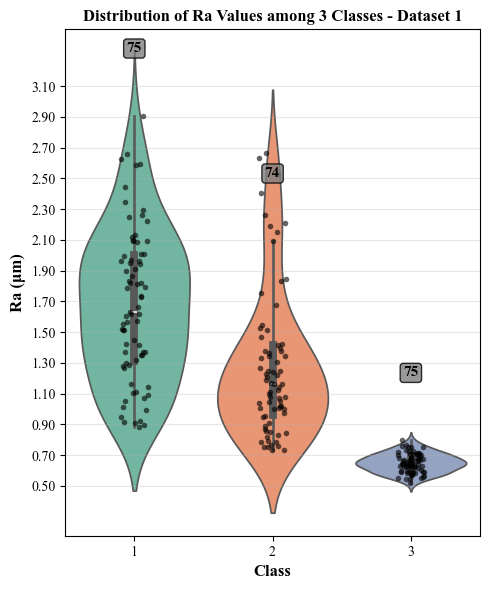

In [ ]:
# Violine Plot for Ra Values by Class

def plot_boxplots(class_1, class_2, class_3):
    """Box plots showing distribution of Ra values"""
    # Combine all data with class labels
    all_data = pd.concat([class_1, class_2, class_3])

    # Create parameter combination column
    all_data['Parameters'] = all_data['RPM'].astype(str) + '-' + all_data['Feedspeed_mm_min_'].astype(str)

    # Reset matplotlib to defaults first
    plt.rcdefaults()
    plt.rcParams.update({
            'font.family': 'serif',  # Using serif to match sample
            'font.serif': ['Times New Roman'],})
    # Create violin plot
    plt.figure(figsize=(5, 6))
    ax = sns.violinplot(data=all_data, x='Class', y='Ra', palette='Set2')
    plt.title('Distribution of Ra Values among 3 Classes - Dataset 1', fontsize=12, fontweight='bold')
    plt.xlabel('Class', fontsize=12, fontweight='bold')
    plt.ylabel('Ra (μm)', fontsize=12, fontweight='bold')
    #plt.yticks(np.arange(all_data['Ra'].min(), all_data['Ra'].max() + 0.2, 0.2))
    plt.yticks(np.arange(0.5, 3.0 + 0.2, 0.2))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
    plt.grid(True, alpha=0.3)

    # Add mean values as points
    sns.stripplot(data=all_data, x='Class', y='Ra', color='black', size=4, alpha=0.6)

    # Add count labels at the tip of each box (Q3 or upper whisker)
    class_counts = all_data['Class'].value_counts().sort_index()

    # Get box plot statistics for each class
    for i, (class_name, count) in enumerate(class_counts.items()):
        class_data = all_data[all_data['Class'] == class_name]['Ra']

        # Calculate the upper whisker position (1.5 * IQR above Q3)
        q1 = class_data.quantile(0.25)
        q3 = class_data.quantile(0.75)
        iqr = q3 - q1
        upper_whisker = q3 + 1.5 * iqr

        # Use the actual maximum within the whisker range
        whisker_max = min(upper_whisker, class_data.max())

        # Small offset above the whisker tip
        y_offset = (all_data['Ra'].max() - all_data['Ra'].min()) * 0.02

        # Add count label at the whisker tip
        ax.text(i, whisker_max +0.4 + y_offset, f'{count}',
                ha='center', va='center_baseline', fontweight='bold',
                fontsize=11, color='black',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='grey', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":

    print("\n Violine Plot")
    plot_boxplots(class_1, class_2, class_3)


RPM vs Ra outliers: 7 (3.1%)

RPM vs Ra Outliers (7):
Row Index | RPM     | Ra      | Expected Ra | Deviation
-------------------------------------------------------
      44 |  8000.0 |   2.594 |       1.287 |     1.307
      52 |  8000.0 |   2.589 |       1.287 |     1.302
      56 |  6000.0 |   2.660 |       1.371 |     1.289
      58 | 12000.0 |   2.906 |       1.119 |     1.787
      76 | 10000.0 |   2.528 |       1.203 |     1.325
      80 |  8000.0 |   2.633 |       1.287 |     1.346
      91 |  6000.0 |   2.668 |       1.371 |     1.297
Feedspeed vs Ra outliers: 3 (1.3%)

Feedspeed vs Ra Outliers (3):
Row Index | Feedspeed | Ra      | Expected Ra | Deviation
----------------------------------------------------------
      58 |     150.0 |   2.906 |       0.966 |     1.940
      80 |     450.0 |   2.633 |       1.320 |     1.313
      91 |     450.0 |   2.668 |       1.320 |     1.348


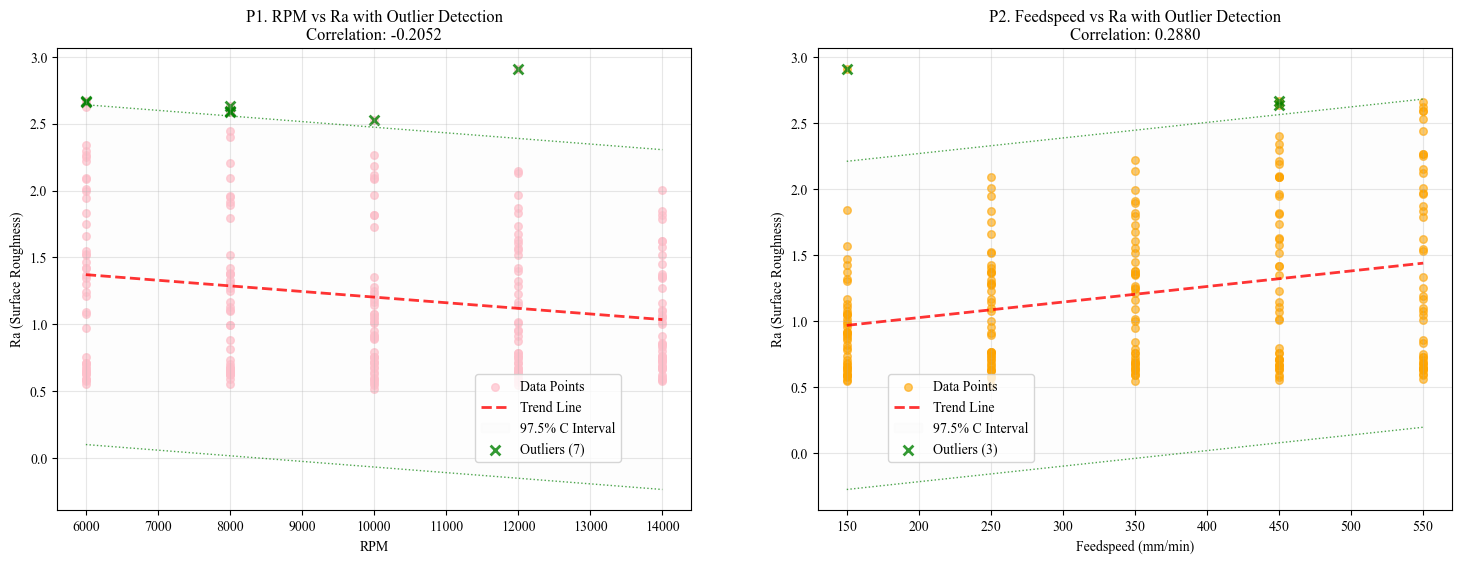

In [ ]:
def create_detailed_relationship_plots(df):
    """
    Create additional detailed plots with outlier detection intervals
    """
    fig, axes = plt.subplots(1,2, figsize=(18, 6))

    # 1. RPM vs Ra with trend line and intervals
    ax1 = axes[0]

    # Calculate trend line
    z = np.polyfit(df['RPM'], df['Ra'], 1)
    p = np.poly1d(z)
    rpm_sorted = df['RPM'].sort_values()
    trend_line = p(rpm_sorted)

    # Calculate residuals and standard deviation
    predicted_ra = p(df['RPM'])
    residuals = df['Ra'] - predicted_ra
    std_residual = np.std(residuals)

    # Create confidence intervals (parallel to trend line)
    upper_bound = trend_line + 2.24 * std_residual  # 95% interval
    lower_bound = trend_line - 2.24 * std_residual

    # Plot data points
    ax1.scatter(df['RPM'], df['Ra'], alpha=0.7, s=30, c='pink', label='Data Points')

    # Plot trend line
    ax1.plot(rpm_sorted, trend_line, "r--", alpha=0.8, linewidth=2, label='Trend Line')

    # Plot confidence intervals
    ax1.fill_between(rpm_sorted, lower_bound, upper_bound,
                     alpha=0.01, color='gray', label='97.5% C Interval')
    ax1.plot(rpm_sorted, upper_bound, 'g:', linewidth=1, alpha=0.7)
    ax1.plot(rpm_sorted, lower_bound, 'g:', linewidth=1, alpha=0.7)

    # Identify outliers
    outliers_mask = (df['Ra'] > predicted_ra + 2.24 * std_residual) | (df['Ra'] < predicted_ra - 2.24 * std_residual)
    outliers = df[outliers_mask]
    ax1.scatter(outliers['RPM'], outliers['Ra'], color='green', s=50, alpha=0.8,
                marker='x', linewidth=2, label=f'Outliers ({len(outliers)})')

    ax1.set_xlabel('RPM')
    ax1.set_ylabel('Ra (Surface Roughness)')
    ax1.set_title(f'P1. RPM vs Ra with Outlier Detection\nCorrelation: {df["RPM"].corr(df["Ra"]):.4f}')
    ax1.grid(True, alpha=0.3)
    ax1.legend( bbox_to_anchor=(0.9, 0.2))



    # 2. Feedspeed vs Ra with trend line and intervals
    ax2 = axes[ 1]

    # Calculate trend line
    z2 = np.polyfit(df['Feedspeed_mm_min_'], df['Ra'], 1)
    p2 = np.poly1d(z2)
    feed_sorted = df['Feedspeed_mm_min_'].sort_values()
    trend_line2 = p2(feed_sorted)

    # Calculate residuals and standard deviation
    predicted_ra2 = p2(df['Feedspeed_mm_min_'])
    residuals2 = df['Ra'] - predicted_ra2
    std_residual2 = np.std(residuals2)

    # Create confidence intervals
    upper_bound2 = trend_line2 + 2.24 * std_residual2
    lower_bound2 = trend_line2 - 2.24 * std_residual2

    # Plot data points
    ax2.scatter(df['Feedspeed_mm_min_'], df['Ra'], alpha=0.6, s=30, color='orange', label='Data Points')

    # Plot trend line
    ax2.plot(feed_sorted, trend_line2, "r--", alpha=0.8, linewidth=2, label='Trend Line')

    # Plot confidence intervals
    ax2.fill_between(feed_sorted, lower_bound2, upper_bound2,
                     alpha=0.01, color='gray', label='97.5% C Interval')
    ax2.plot(feed_sorted, upper_bound2, 'g:', linewidth=1, alpha=0.7)
    ax2.plot(feed_sorted, lower_bound2, 'g:', linewidth=1, alpha=0.7)

    # Identify outliers
    outliers_mask2 = (df['Ra'] > predicted_ra2 + 2.24 * std_residual2) | (df['Ra'] < predicted_ra2 - 2.24 * std_residual2)
    outliers2 = df[outliers_mask2]
    ax2.scatter(outliers2['Feedspeed_mm_min_'], outliers2['Ra'], color='green', s=50, alpha=0.8,
                marker='x', linewidth=2, label=f'Outliers ({len(outliers2)})')

    ax2.set_xlabel('Feedspeed (mm/min)')
    ax2.set_ylabel('Ra (Surface Roughness)')
    ax2.set_title(f'P2. Feedspeed vs Ra with Outlier Detection\nCorrelation: {df["Feedspeed_mm_min_"].corr(df["Ra"]):.4f}')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(0.1, 0.2))


    # Print outlier statistics
    print(f"RPM vs Ra outliers: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
    print(f"\nRPM vs Ra Outliers ({len(outliers)}):")
    print("Row Index | RPM     | Ra      | Expected Ra | Deviation")
    print("-" * 55)
    for idx in outliers.index:
        rpm_val = df.loc[idx, 'RPM']
        ra_val = df.loc[idx, 'Ra']
        expected_ra = p(rpm_val)
        deviation = ra_val - expected_ra
        print(f"{idx:8d} | {rpm_val:7.1f} | {ra_val:7.3f} | {expected_ra:11.3f} | {deviation:9.3f}")
    print(f"Feedspeed vs Ra outliers: {len(outliers2)} ({len(outliers2)/len(df)*100:.1f}%)")
    print(f"\nFeedspeed vs Ra Outliers ({len(outliers2)}):")
    print("Row Index | Feedspeed | Ra      | Expected Ra | Deviation")
    print("-" * 58)
    for idx in outliers2.index:
        feed_val = df.loc[idx, 'Feedspeed_mm_min_']
        ra_val = df.loc[idx, 'Ra']
        expected_ra = p2(feed_val)
        deviation = ra_val - expected_ra
        print(f"{idx:8d} | {feed_val:9.1f} | {ra_val:7.3f} | {expected_ra:11.3f} | {deviation:9.3f}")


    # ... rest of your existing plots remain the same ...


create_detailed_relationship_plots(df)

Outlier deletion where Ra is greater than equal to 2.7 µm

In [ ]:
# Removing few data points where Ra is >= 2.7
df = df[df['Ra'] <= 2.7]

Feature Selection Method

Selected 96 features between Material_removal_rate and Ra
MULTIVARIATE FEATURE SELECTION RESULTS
Analyzed: 96 features
Selected: 30 top features
Multicollinear pairs: 36

Top 10 Features:
 1. Specific_grinding_energy: 0.3812
 2. Fz_wav_energy: 0.2961
 3. Fz_energy: 0.2871
 4. Fz_max: 0.2423
 5. Fz_median: 0.2383
 6. Fz_rms: 0.2373
 7. Fz_mean: 0.2337
 8. Fm: 0.2323
 9. Fz_snr: 0.2322
10. Fz_std: 0.2303
Selected 96 features between Material_removal_rate and Ra


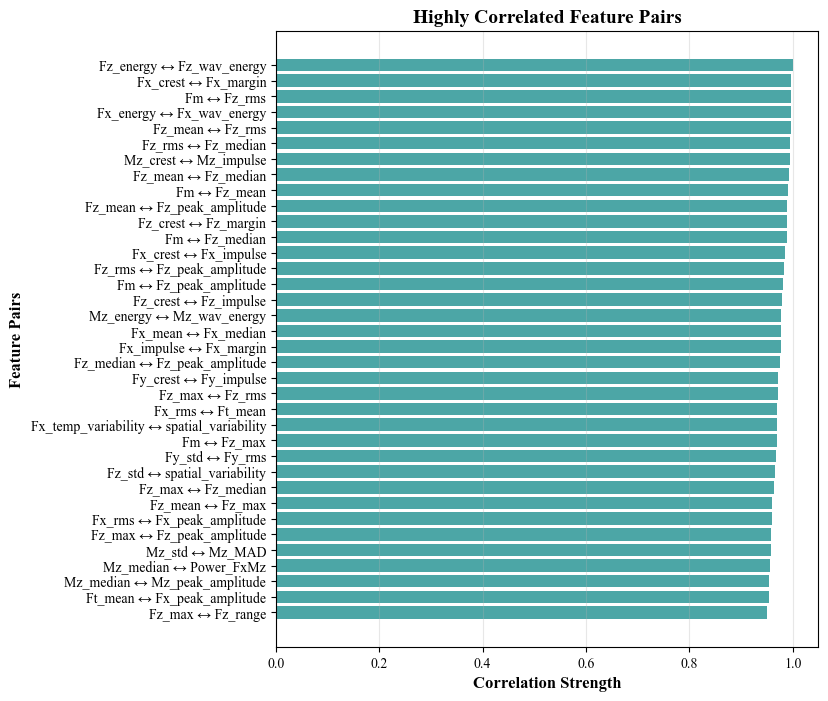


Feature Categories:
RPM_dominant: 10 features
Feedspeed_dominant: 10 features
Ra_predictive: 15 features
Balanced: 19 features

 Top 30 Features (Ready for Modelling):
['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_max', 'Fz_median', 'Fz_rms', 'Fz_mean', 'Fm', 'Fz_snr', 'Fz_std', 'Fz_peak_amplitude', 'Fx_wav_energy', 'Fz_dom_freq', 'spatial_variability', 'Fx_temp_variability', 'ForceRatio_XY', 'Fz_margin', 'Fx_energy', 'Fx_median', 'Fx_mean', 'Fz_crest', 'Fx_rms', 'Fz_impulse', 'Fz_temp_variability', 'Fz_skew', 'Fz_range', 'Fy_mean', 'Ft_mean', 'Fx_peak_amplitude', 'Fx_dom_freq']


In [ ]:
# MULTIVARIATE FEATURE SELECTION PIPELINE
# Efficient analysis of F-features with RPM, Feedspeed, Ra dependencies

class MultivariateFeatureSelector:

    def __init__(self,df, target_features=['RPM', 'Feedspeed_mm_min_', 'Ra']):
        """
        Initialize with features between MaterialRemovedRate and Ra (Excel columns H to DM = 110 features)
        """
        self.target_features = target_features
        self.results = {}

        if df is not None:
            # Get all columns between MaterialRemovedRate and Ra
            all_columns = df.columns.tolist()

            try:
                start_idx = all_columns.index('Material_removal_rate') + 1  # Start after MaterialRemovedRate
                end_idx = all_columns.index('Ra')  # End before Ra
                self.f_features = all_columns[start_idx:end_idx]  # Extract 110 features between H-DM

                print(f"Selected {len(self.f_features)} features between Material_removal_rate and Ra")

            except ValueError as e:
                print(f"Column not found: {e}")
                self.f_features = []
        else:
            print("Warning: No dataframe provided")
            self.f_features = []

    def mutual_information_analysis(self, X, y_dict):
        """Compute mutual information for all targets"""
        mi_results = {}
        for target, y in y_dict.items():
            mi_scores = mutual_info_regression(X, y, random_state=42)
            mi_results[target] = pd.Series(mi_scores, index=X.columns)
        return mi_results

    def partial_correlation_analysis(self, df, control_vars=['RPM', 'Feedspeed_mm_min_']):
        """Compute partial correlations controlling for process parameters"""
        from sklearn.linear_model import LinearRegression

        partial_corr_results = {}
        y_ra = df['Ra'].values
        X_control = df[control_vars].values

        # Remove control variable effects from Ra
        reg_ra = LinearRegression().fit(X_control, y_ra)
        ra_residuals = y_ra - reg_ra.predict(X_control)

        for feature in self.f_features:
            if feature in df.columns:
                y_feature = df[feature].values

                # Remove control variable effects from feature
                reg_feature = LinearRegression().fit(X_control, y_feature)
                feature_residuals = y_feature - reg_feature.predict(X_control)

                # Correlation between residuals
                corr, p_value = pearsonr(feature_residuals, ra_residuals)
                partial_corr_results[feature] = {'correlation': corr, 'p_value': p_value}

        return pd.DataFrame(partial_corr_results).T

    def lasso_selection(self, X, y, cv=5):
        """LASSO feature selection with cross-validation"""
        lasso = LassoCV(cv=cv, random_state=42, max_iter=1000)
        lasso.fit(X, y)

        feature_importance = pd.Series(np.abs(lasso.coef_), index=X.columns)
        selected_features = feature_importance[feature_importance > 0].index.tolist()

        return {
            'importance': feature_importance,
            'selected': selected_features,
            'alpha': lasso.alpha_,
            'score': lasso.score(X, y)
        }

    def random_forest_importance(self, X, y):
        """Random Forest feature importance with permutation"""
        rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
        rf.fit(X, y)

        # Permutation importance
        perm_importance = permutation_importance(rf, X, y, n_repeats=5, random_state=42)

        return {
            'rf_importance': pd.Series(rf.feature_importances_, index=X.columns),
            'perm_importance': pd.Series(perm_importance.importances_mean, index=X.columns),
            'perm_std': pd.Series(perm_importance.importances_std, index=X.columns)
        }

    def correlation_matrix_analysis(self, df):
        """Analyze correlation patterns"""
        f_data = df[self.f_features]
        target_data = df[self.target_features]

        # F-feature correlations with targets
        correlations = {}
        for target in self.target_features:
            correlations[target] = f_data.corrwith(df[target])

        # Inter F-feature correlations
        f_corr_matrix = f_data.corr()

        return {
            'target_correlations': pd.DataFrame(correlations),
            'f_feature_correlations': f_corr_matrix
        }

    def detect_multicollinearity(self, X, threshold=0.95):
        """Detect highly correlated feature pairs"""
        corr_matrix = X.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        high_corr_pairs = []
        for column in upper_triangle.columns:
            high_corr_features = upper_triangle.index[upper_triangle[column] > threshold].tolist()
            for feature in high_corr_features:
                high_corr_pairs.append((feature, column, upper_triangle.loc[feature, column]))

        return high_corr_pairs

    def comprehensive_selection(self, df, top_k=30):
        """Complete feature selection pipeline"""
        X_f = df[self.f_features]

        y_dict = {target: df[target] for target in self.target_features}

        # 1. Mutual Information Analysis
        mi_results = self.mutual_information_analysis(X_f, y_dict)

        # 2. Partial Correlation (Ra only)
        partial_corr = self.partial_correlation_analysis(df)

        # 3. Correlation Analysis
        corr_results = self.correlation_matrix_analysis(df)

        # 4. Random Forest Analysis (Ra prediction)
        rf_results = self.random_forest_importance(X_f, df['Ra'])

        # 5. LASSO Selection (Ra prediction)
        lasso_results = self.lasso_selection(X_f, df['Ra'])

        # 6. Multicollinearity Detection
        high_corr_pairs = self.detect_multicollinearity(X_f)

        '''
        print("high_corr_pairs:", high_corr_pairs[:5])  # Prints the
        print("Type:", type(high_corr_pairs))
        '''

        # Combine results for ranking
        ranking_df = pd.DataFrame(index=self.f_features)

        # Add all scores
        ranking_df['MI_RPM'] = mi_results['RPM'].reindex(self.f_features, fill_value=0)
        ranking_df['MI_Feedspeed'] = mi_results['Feedspeed_mm_min_'].reindex(self.f_features, fill_value=0)
        ranking_df['MI_Ra'] = mi_results['Ra'].reindex(self.f_features, fill_value=0)
        ranking_df['Partial_Corr_Ra'] = partial_corr['correlation'].reindex(self.f_features, fill_value=0)
        ranking_df['RF_Importance'] = rf_results['rf_importance'].reindex(self.f_features, fill_value=0)
        ranking_df['Perm_Importance'] = rf_results['perm_importance'].reindex(self.f_features, fill_value=0)
        ranking_df['LASSO_Importance'] = lasso_results['importance'].reindex(self.f_features, fill_value=0)
        ranking_df['Corr_Ra'] = corr_results['target_correlations']['Ra'].reindex(self.f_features, fill_value=0)

        # Create composite scores
        ranking_df['MI_Composite'] = (ranking_df['MI_RPM'] + ranking_df['MI_Feedspeed'] + ranking_df['MI_Ra']) / 3
        ranking_df['Overall_Score'] = (
            0.25 * ranking_df['MI_Composite'] +
            0.20 * np.abs(ranking_df['Partial_Corr_Ra']) +
            0.20 * ranking_df['RF_Importance'] +
            0.20 * ranking_df['Perm_Importance'] +
            0.15 * ranking_df['LASSO_Importance']
        )

        # Rank features
        ranking_df = ranking_df.sort_values('Overall_Score', ascending=False)
        top_features = ranking_df.head(top_k).index.tolist()

        # Store results
        self.results = {
            'ranking': ranking_df,
            'top_features': top_features,
            'mi_results': mi_results,
            'partial_correlation': partial_corr,
            'correlation_analysis': corr_results,
            'rf_results': rf_results,
            'lasso_results': lasso_results,
            'multicollinearity': high_corr_pairs,
            'summary': self._create_summary(ranking_df, top_features, high_corr_pairs)
        }

        return self.results

    def _create_summary(self, ranking_df, top_features, high_corr_pairs):
        """Create analysis summary"""
        return {
            'total_features_analyzed': len(self.f_features),
            'top_features_selected': len(top_features),
            'high_correlation_pairs': len(high_corr_pairs),
            'top_10_features': top_features[:10],
            'score_range': {
                'max': ranking_df['Overall_Score'].max(),
                'min': ranking_df['Overall_Score'].min(),
                'mean': ranking_df['Overall_Score'].mean()
            }
        }

    def get_feature_categories(self):
        """Categorize features by their dominant relationships"""
        if not self.results:
            return "Run comprehensive_selection first"

        ranking = self.results['ranking']
        categories = {}

        # RPM-dominant features
        rpm_dominant = ranking[ranking['MI_RPM'] > ranking[['MI_Feedspeed', 'MI_Ra']].max(axis=1)].head(10)
        categories['RPM_dominant'] = rpm_dominant.index.tolist()

        # Feedspeed-dominant features
        feedspeed_dominant = ranking[ranking['MI_Feedspeed'] > ranking[['MI_RPM', 'MI_Ra']].max(axis=1)].head(10)
        categories['Feedspeed_dominant'] = feedspeed_dominant.index.tolist()

        # Ra-predictive features
        ra_predictive = ranking.nlargest(15, 'MI_Ra')
        categories['Ra_predictive'] = ra_predictive.index.tolist()

        # Balanced features (high in multiple categories)
        balanced = ranking[ranking['MI_Composite'] > ranking['MI_Composite'].quantile(0.8)]
        categories['Balanced'] = balanced.index.tolist()

        return categories

    def plot_multicollinearity(self, df):
        """
        Plot correlation strength of highly correlated feature pairs.
        pairs: list of tuples (feature1, feature2, correlation)
        """
        X_f = df[self.f_features]

        high_corr_pairs = self.detect_multicollinearity(X_f)

        if not high_corr_pairs:
            print("No highly correlated pairs found.")
            return

        # Clean and convert to DataFrame
        cleaned_pairs = [(f1, f2, float(corr)) for f1, f2, corr in high_corr_pairs]
        corr_df = pd.DataFrame(cleaned_pairs, columns=["Feature1", "Feature2", "Correlation"])  # Changed name

        # Create label like "Feature1 ↔ Feature2"
        corr_df["Pair"] = corr_df["Feature1"] + " ↔ " + corr_df["Feature2"]

        # Sort by correlation strength
        corr_df = corr_df.sort_values("Correlation", ascending=False)

        # Plot
        plt.figure(figsize=(7, 8))
        plt.barh(corr_df["Pair"], corr_df["Correlation"], color="teal", alpha=0.7)
        plt.xlabel("Correlation Strength", fontsize=12, fontweight="bold")
        plt.ylabel("Feature Pairs", fontsize=12, fontweight="bold")
        plt.title("Highly Correlated Feature Pairs", fontsize=14, fontweight="bold")
        plt.gca().invert_yaxis()  # Highest correlation on top
        plt.grid(axis="x", alpha=0.3)
        plt.show()


# Usage Pipeline
def run_feature_selection_pipeline(df, top_k=30):
    """Main pipeline execution"""

    selector = MultivariateFeatureSelector(df)
    results = selector.comprehensive_selection(df, top_k=top_k)

    print("="*50)
    print("MULTIVARIATE FEATURE SELECTION RESULTS")
    print("="*50)

    # Summary
    summary = results['summary']
    print(f"Analyzed: {summary['total_features_analyzed']} features")
    print(f"Selected: {summary['top_features_selected']} top features")
    print(f"Multicollinear pairs: {summary['high_correlation_pairs']}")

    # Top features
    print(f"\nTop 10 Features:")
    for i, feature in enumerate(summary['top_10_features'], 1):
        score = results['ranking'].loc[feature, 'Overall_Score']
        print(f"{i:2d}. {feature}: {score:.4f}")

    fs = MultivariateFeatureSelector(df)

    # Step 1: Detect and plot multicollinearity
    fs.plot_multicollinearity(df)


    # Feature categories
    categories = selector.get_feature_categories()
    print(f"\nFeature Categories:")
    for category, features in categories.items():
        print(f"{category}: {len(features)} features")

    return {
        'selector': selector,
        'results': results,
        'categories': categories,
        'selected_features': results['top_features']
    }

# Execute pipeline
pipeline_results = run_feature_selection_pipeline(df, top_k=30)

# Access results
selected_features = pipeline_results['selected_features']
feature_ranking = pipeline_results['results']['ranking']
feature_categories = pipeline_results['categories']



# Get top 30 features in list format
top_30_features = pipeline_results['results']['ranking'].head(30).index.tolist()

print("\n Top 30 Features (Ready for Modelling):")
print(top_30_features)

 # ▶  SVR (Support vector Regression) Dataset 1

Total combinations: 25
Train size: 148
Validation size: 50
Test size: 25

=== Starting Feature Selection ===
Initial number of features: 33
Skipping ANOVA screening (only 33 features)

Step 2: RFE for final feature selection...
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.

Selected 30 features using RFE

Top 30 selected features:
1. RPM
2. Material_removal_rate
3. Specific_grinding_energy
4. Fz_wav_energy
5. Fz_energy
6. Fz_max
7. Fz_median
8. Fz_rms
9. Fz_mean
10. Fm
11. Fz_snr
12. Fz_std
13. Fz_peak_amplitude
14. Fx_wav_energy
15. spatial_variability
16. Fx_temp_variability
17. ForceRatio_XY
18. Fz_margin
19. Fx_energy
20. Fx_median
21. Fx_mean
22. Fz_crest
23. Fx_rms
24. Fz_impulse
25. Fz_temp_variability
26. Fz_skew
27. Fz_range
28. Fy_mean
29. Ft_mean
30. Fx_peak_amplitude

Feature Rankings (1 = selected, higher = less important):
                     Feature  Ranking
0                        RPM        1
2      Materi

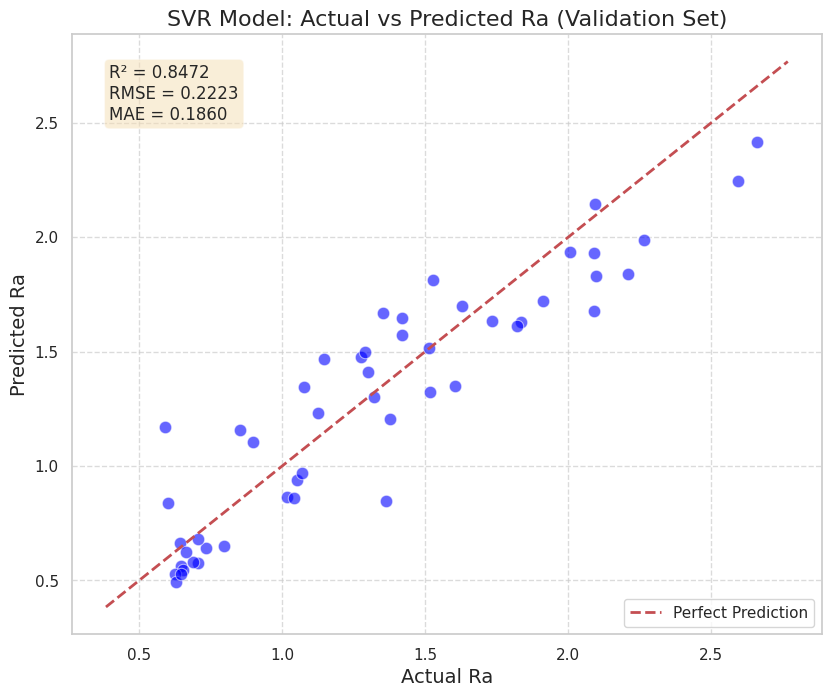


Actual vs. Predicted Values for Ra (Test Set):
 Actual  Predicted  Absolute Error  Percentage Error
 0.6290     0.5377          0.0913           14.5172
 2.1200     2.1025          0.0175            0.8255
 0.5160     0.5587          0.0427            8.2775
 1.8350     1.8711          0.0361            1.9676
 1.9450     1.7516          0.1934            9.9414
 0.6210     0.5411          0.0799           12.8714
 2.1330     1.6263          0.5067           23.7554
 0.6250     0.5719          0.0531            8.4918
 0.9130     1.2490          0.3360           36.7999
 2.0890     1.9393          0.1497            7.1669
 0.9940     1.2597          0.2657           26.7280
 1.4200     0.9170          0.5030           35.4196
 2.2950     2.0833          0.2117            9.2262
 2.2640     2.0992          0.1648            7.2802
 1.8200     1.4172          0.4028           22.1297
 0.7530     1.0601          0.3071           40.7852
 1.3070     1.1271          0.1799           13.765

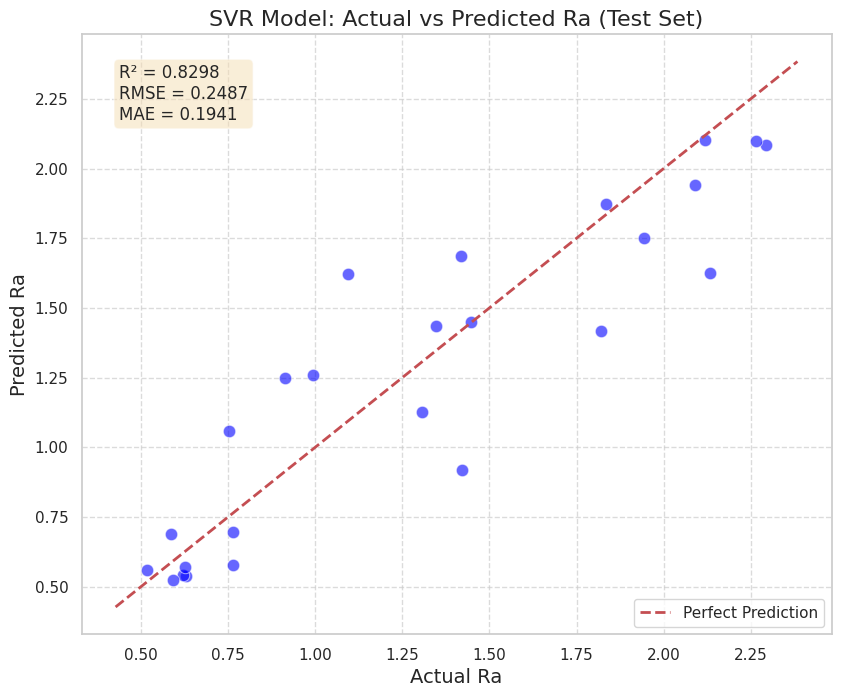


Initial Model Performance Metrics:
  Target  Train RMSE  Val RMSE  Test RMSE  Train MAE   Val MAE  Test MAE  \
0     Ra    0.222702  0.222262   0.248695   0.154116  0.186027  0.194073   

   Train R²    Val R²   Test R²  
0  0.839237  0.847195  0.829763  

=== Starting optimized hyperparameter tuning ===

=== Tuning SVR for Ra target ===
Stage 1: Finding best kernel type...
Kernel: linear, Validation RMSE: 0.222262
Kernel: poly, Validation RMSE: 0.345323
Kernel: rbf, Validation RMSE: 0.191353
Kernel: sigmoid, Validation RMSE: 3.711280
Best kernel: rbf with RMSE: 0.191353
Stage 2: Fine-tuning parameters for rbf kernel...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Tuning completed in 2.81 seconds
Best parameters: {'C': np.float64(2.24645516805326), 'epsilon': np.float64(0.016632480579933266), 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score (neg MSE): -0.06649455943804984
Best CV RMSE: 0.25786539015162513
Validation RMSE with best params: 0.1701

=== Best Parameters Su

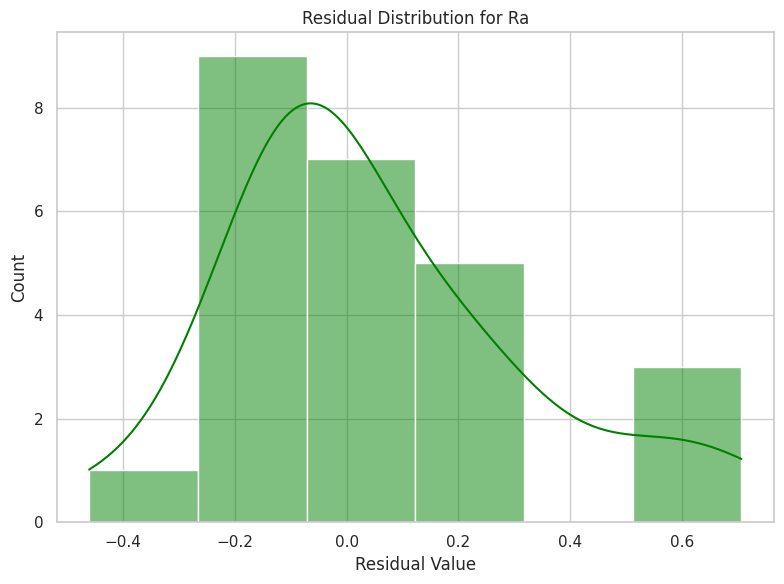

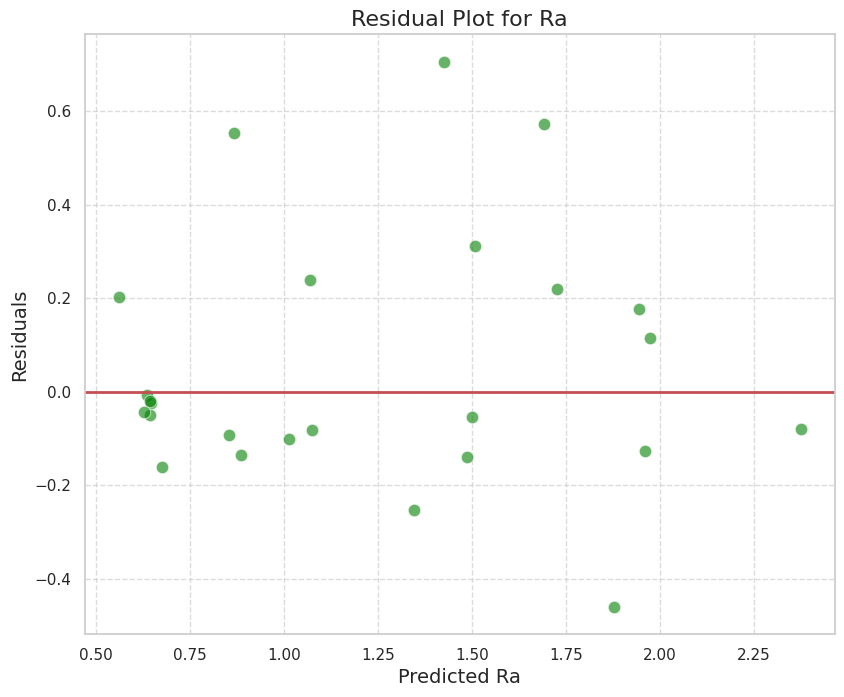


=============== FINAL RESULTS ===============

Actual vs. Predicted Values for Ra (Training Set):
Training Set Size: 148
Average Error: 0.0786
Average Percentage Error: 6.54%

Actual vs. Predicted Values for Ra (Validation Set):
 Actual  Predicted  Absolute Error  Percentage Error
 2.0960     2.0514          0.0446            2.1258
 2.2090     1.9434          0.2656           12.0235
 2.2640     2.0653          0.1987            8.7778
 1.0770     1.0490          0.0280            2.6039
 1.1460     1.3199          0.1739           15.1756
 1.2770     1.1815          0.0955            7.4797
 0.6000     0.5295          0.0705           11.7557
 0.6440     0.5708          0.0732           11.3614
 1.8340     1.7246          0.1094            5.9644
 2.0900     1.7720          0.3180           15.2147
 1.0520     1.1594          0.1074           10.2060
 0.7350     0.9684          0.2334           31.7533
 1.0180     1.0821          0.0641            6.2999
 1.6060     1.5103          

In [ ]:
# Load the dataset
df = df

# Define the top 30 F features (replace with your actual top 30 features)
top_30_f_features =  ['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_max', 'Fz_median', 'Fz_rms', 'Fz_mean', 'Fm', 'Fz_snr', 'Fz_std', 'Fz_peak_amplitude', 'Fx_wav_energy', 'Fz_dom_freq', 'spatial_variability', 'Fx_temp_variability', 'ForceRatio_XY', 'Fz_margin', 'Fx_energy', 'Fx_median', 'Fx_mean', 'Fz_crest', 'Fx_rms', 'Fz_impulse', 'Fz_temp_variability', 'Fz_skew', 'Fz_range', 'Fy_mean', 'Ft_mean', 'Fx_peak_amplitude', 'Fx_dom_freq']
# Additional features to include
additional_features = [ 'RPM', 'Feedspeed_mm_min_', 'Material_removal_rate']

# Target variable
target_var = 'Ra'

# Combine all features
all_features = additional_features + top_30_f_features

# Create X (features) and y (target)
X = df[all_features]
y_ra = df['Ra']

# Custom train-validation-test split based on RPM and Feedspeed combinations
def custom_train_val_test_split(df):
    """
    Custom split ensuring proper distribution across train, validation, and test sets.
    For each RPM-Feedspeed combination (assuming 9 samples each):
    - 6 samples for training (150 total)
    - 2 samples for validation (50 total)
    - 1 sample for testing (25 total)
    """
    # Get unique RPM-Feedspeed combinations
    combinations = df[['RPM', 'Feedspeed_mm_min_']].drop_duplicates().values

    train_indices = []
    val_indices = []
    test_indices = []

    print(f"Total combinations: {len(combinations)}")

    for rpm, feedspeed in combinations:
        # Get indices for this combination
        indices = df[(df['RPM'] == rpm) & (df['Feedspeed_mm_min_'] == feedspeed)].index.tolist()

        # Shuffle to randomize selection
        np.random.shuffle(indices)

        # Assuming 9 samples per combination
        if len(indices) >= 9:
            test_indices.extend(indices[:1])      # 1 for testing
            val_indices.extend(indices[1:3])       # 2 for validation
            train_indices.extend(indices[3:])      # 6 for training
        elif len(indices) >= 3:
            # If less than 9 samples, distribute proportionally
            test_size = max(1, len(indices) // 9)
            val_size = max(1, len(indices) // 4)

            test_indices.extend(indices[:test_size])
            val_indices.extend(indices[test_size:test_size+val_size])
            train_indices.extend(indices[test_size+val_size:])
        else:
            # If very few samples, use all for training
            train_indices.extend(indices)

    # Create train, validation, and test sets
    X_train = X.loc[train_indices]
    X_val = X.loc[val_indices]
    X_test = X.loc[test_indices]

    y_train = y_ra.loc[train_indices]
    y_val = y_ra.loc[val_indices]
    y_test = y_ra.loc[test_indices]

    print(f"Train size: {len(train_indices)}")
    print(f"Validation size: {len(val_indices)}")
    print(f"Test size: {len(test_indices)}")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Set random seed for reproducibility
np.random.seed(42)

# Perform the custom train-validation-test split
X_train, X_val, X_test, y_train, y_val, y_test = custom_train_val_test_split(df)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ==== FEATURE SELECTION SECTION ====
from sklearn.feature_selection import f_regression, SelectKBest, RFE, RFECV

print("\n=== Starting Feature Selection ===")
print(f"Initial number of features: {len(all_features)}")

# Step 1: ANOVA F-test for initial screening (35 features to 50 features)
# Since we have 35 features total, we'll keep all for initial screening
if len(all_features) > 50:
    print("\nStep 1: ANOVA F-test screening...")
    f_selector = SelectKBest(f_regression, k=50)
    X_train_prescreened = f_selector.fit_transform(X_train_scaled, y_train)
    X_val_prescreened = f_selector.transform(X_val_scaled)
    X_test_prescreened = f_selector.transform(X_test_scaled)

    # Get prescreened feature names
    prescreened_features = np.array(all_features)[f_selector.get_support()]
    print(f"Features after ANOVA screening: {len(prescreened_features)}")
else:
    # If we have 50 or fewer features, skip ANOVA
    X_train_prescreened = X_train_scaled
    X_val_prescreened = X_val_scaled
    X_test_prescreened = X_test_scaled
    prescreened_features = np.array(all_features)
    print(f"Skipping ANOVA screening (only {len(all_features)} features)")

# Step 2: RFE for final feature selection (to 30 features)
if len(prescreened_features) > 30:
    print("\nStep 2: RFE for final feature selection...")

    # Use linear SVR for RFE (faster and provides feature importance)
    # Removed random_state as SVR does not support it
    rfe_estimator = SVR(kernel='linear', C=1.0)

    # Option 1: RFE with fixed number of features
    rfe_selector = RFE(rfe_estimator, n_features_to_select=30, step=1, verbose=1)
    rfe_selector.fit(X_train_prescreened, y_train)

    # Transform all datasets
    X_train_rfe = rfe_selector.transform(X_train_prescreened)
    X_val_rfe = rfe_selector.transform(X_val_prescreened)
    X_test_rfe = rfe_selector.transform(X_test_prescreened)

    # Get selected feature names
    selected_features = prescreened_features[rfe_selector.support_]
    feature_ranking = rfe_selector.ranking_

    print(f"\nSelected {len(selected_features)} features using RFE")
    print("\nTop 30 selected features:")
    for i, feature in enumerate(selected_features):
        print(f"{i+1}. {feature}")

    # Create a dataframe showing all features and their rankings
    feature_ranking_df = pd.DataFrame({
        'Feature': prescreened_features,
        'Ranking': feature_ranking
    }).sort_values('Ranking')

    print("\nFeature Rankings (1 = selected, higher = less important):")
    print(feature_ranking_df.head(35))

    # Option 2: RFECV to find optimal number of features (uncomment to use)
    """
    print("\nAlternative: Using RFECV to find optimal number of features...")
    # Removed random_state from SVR inside RFECV
    rfecv_selector = RFECV(
        SVR(kernel='linear', C=1.0), # Removed random_state=42
        min_features_to_select=20,
        cv=3,
        scoring='neg_mean_squared_error',
        step=1,
        n_jobs=-1,
        verbose=1
    )
    rfecv_selector.fit(X_train_prescreened, y_train)

    print(f"Optimal number of features: {rfecv_selector.n_features_}")

    # Plot the cross-validation scores
    plt.figure(figsize=(10, 6))
    # Use cv_results_['mean_test_score'] instead of grid_scores_
    plt.plot(range(rfecv_selector.min_features_to_select, len(prescreened_features) + 1),
         -rfecv_selector.cv_results_['mean_test_score'])  # Convert back to positive RMSE
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross-validation RMSE')
    plt.title('RFECV: Optimal Feature Selection')
    plt.axvline(x=rfecv_selector.n_features_, color='r', linestyle='--',
                label=f'Optimal: {rfecv_selector.n_features_} features')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Use RFECV results
    X_train_rfe = rfecv_selector.transform(X_train_prescreened)
    X_val_rfe = rfecv_selector.transform(X_val_prescreened)
    X_test_rfe = rfecv_selector.transform(X_test_prescreened)
    selected_features = prescreened_features[rfecv_selector.support_]


    # Update the scaled datasets to use selected features
    X_train_scaled = X_train_rfe
    X_val_scaled = X_val_rfe
    X_test_scaled = X_test_rfe

    # Update all_features to reflect selected features
    all_features = selected_features.tolist()

    print(f"\nFeature selection complete. Using {len(all_features)} features for model training.")

    # Save the feature selectors for later use
    if len(all_features) > 50:
        joblib.dump(f_selector, 'anova_selector.pkl')
    joblib.dump(rfe_selector, 'rfe_selector.pkl')
else:
    print(f"\nNo feature selection needed (only {len(all_features)} features)")
    selected_features = all_features
    """
# Updated plotting function using Seaborn
def plot_svr_predictions(y_test, y_pred, target_name, set_name="Test"):
    """
    Creates an enhanced Seaborn plot for SVR model predictions with metrics
    """
    # Calculate metrics for the text box
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })

    # Set the Seaborn style
    sns.set(style="whitegrid")

    # Create figure
    plt.figure(figsize=(10, 8))

    # Create scatter plot
    sns.scatterplot(x='Actual', y='Predicted', data=plot_df, color='blue',
                   s=80, alpha=0.6)

    # Get axis limits for perfect prediction line
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    padding = (max_val - min_val) * 0.05
    min_val -= padding
    max_val += padding

    # Plot perfect prediction line
    plt.plot([min_val, max_val], [min_val, max_val], 'r--',
             linewidth=2, label='Perfect Prediction')

    # Add metrics text box
    metrics_text = (
        f"R² = {r2:.4f}\n"
        f"RMSE = {rmse:.4f}\n"
        f"MAE = {mae:.4f}"
    )
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Set labels and title
    plt.xlabel(f'Actual {target_name}', fontsize=14)
    plt.ylabel(f'Predicted {target_name}', fontsize=14)
    plt.title(f'SVR Model: Actual vs Predicted {target_name} ({set_name} Set)', fontsize=16)

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add legend
    plt.legend(loc='lower right')

    # Adjust layout
    plt.tight_layout()

    # Add a bit of space
    plt.subplots_adjust(bottom=0.15, top=0.9, left=0.15, right=0.9)

    # Print actual vs predicted values for this target
    comparison_df = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': y_pred,
        'Absolute Error': np.abs(y_test.values - y_pred),
        'Percentage Error': 100 * np.abs(y_test.values - y_pred) / y_test.values
    })

    print(f"\nActual vs. Predicted Values for {target_name} ({set_name} Set):")
    print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    print(f"\nAverage Error: {comparison_df['Absolute Error'].mean():.4f}")
    print(f"Average Percentage Error: {comparison_df['Percentage Error'].mean():.2f}%")

# Function to create enhanced residual plot
def plot_svr_residuals(y_test, y_pred, target_name):
    """
    Creates an enhanced residual plot for SVR model evaluation
    """
    # Calculate residuals
    residuals = y_test - y_pred

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'Predicted': y_pred,
        'Residual': residuals
    })

    # Set the Seaborn style
    sns.set(style="whitegrid")

    # Create main figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create scatter plot
    sns.scatterplot(x='Predicted', y='Residual', data=plot_df, color='green',
                    s=80, alpha=0.6, ax=ax)

    # Add horizontal line at y=0
    ax.axhline(y=0, color='r', linestyle='-', linewidth=2)

    # Create a separate subplot for the histogram instead of using axes
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, color='green')
    plt.title(f'Residual Distribution for {target_name}')
    plt.xlabel('Residual Value')
    plt.tight_layout()

    # Go back to scatter plot figure
    plt.figure(fig.number)

    # Set labels and title for main plot
    ax.set_xlabel(f'Predicted {target_name}', fontsize=14)
    ax.set_ylabel('Residuals', fontsize=14)
    ax.set_title(f'Residual Plot for {target_name}', fontsize=16)

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()

    # Add space
    plt.subplots_adjust(bottom=0.15, top=0.9, left=0.15, right=0.9)

# Function to plot feature importance with Seaborn
def plot_feature_importance(feature_names, importance_values, target_name):
    """
    Creates an enhanced feature importance plot using Seaborn
    """
    # Create DataFrame for plotting
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_values
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Get top 15 features
    top_features = feature_importance.head(15)

    # Set the Seaborn style
    sns.set(style="whitegrid")

    # Create figure
    plt.figure(figsize=(12, 8))

    # Create bar plot with custom color palette
    bars = sns.barplot(x='Importance', y='Feature', hue='Feature', data=top_features,
                      palette='viridis', legend=False)

    # Add value labels to bars
    for i, v in enumerate(top_features['Importance']):
        bars.text(v + 0.001, i, f'{v:.4f}', va='center')

    # Set labels and title
    plt.xlabel('Feature Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'Top 15 Features for {target_name} Prediction (Linear SVR)', fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Add space
    plt.subplots_adjust(bottom=0.15, top=0.9, left=0.15, right=0.9)

# Function to train SVR model with validation set for early stopping
def train_svr_with_validation(X_train, y_train, X_val, y_val, params, max_iter=1000):
    """
    Train SVR with early stopping using validation set
    """
    # For SVR, we'll use the validation set to check if we should stop training
    # Since SVR doesn't have built-in early stopping, we'll train and evaluate
    svr_model = SVR(**params)
    svr_model.fit(X_train, y_train)

    # Evaluate on validation set
    y_val_pred = svr_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    return svr_model, val_rmse

# Function to train and evaluate SVR model
def train_and_evaluate_svr(X_train, y_train, X_val, y_val, X_test, y_test, target_name, params=None):
    """
    Train an SVR model with given parameters and evaluate its performance
    """
    # Default params if none provided
    if params is None:
        params = {'kernel': 'linear', 'C': 1, 'epsilon': 0.1, 'gamma': 'auto'}

    # Train the SVR model with validation
    svr_model, val_rmse = train_svr_with_validation(X_train, y_train, X_val, y_val, params)

    # Make predictions on all sets
    y_pred_train = svr_model.predict(X_train)
    y_pred_val = svr_model.predict(X_val)
    y_pred_test = svr_model.predict(X_test)

    # Calculate evaluation metrics
    metrics = {
        'Target': target_name,
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Val RMSE': np.sqrt(mean_squared_error(y_val, y_pred_val)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Val MAE': mean_absolute_error(y_val, y_pred_val),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Train R²': r2_score(y_train, y_pred_train),
        'Val R²': r2_score(y_val, y_pred_val),
        'Test R²': r2_score(y_test, y_pred_test)
    }

    # Plot predictions for validation and test sets
    plot_svr_predictions(y_val, y_pred_val, target_name, "Validation")
    plt.show()

    plot_svr_predictions(y_test, y_pred_test, target_name, "Test")
    plt.show()

    return svr_model, metrics

# Initial training with default parameters
print("=== Initial Training with Default Parameters ===")
svr_ra, metrics_ra = train_and_evaluate_svr(
    X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, 'Ra'
)

# Display initial metrics
print("\nInitial Model Performance Metrics:")
print(pd.DataFrame([metrics_ra]))

# ==== OPTIMIZED HYPERPARAMETER TUNING SECTION ====

# Custom scoring function that uses validation set
def custom_scorer(estimator, X, y):
    """Custom scorer that evaluates on validation set"""
    # This is called during cross-validation
    # We'll use standard scoring here
    y_pred = estimator.predict(X)
    return -mean_squared_error(y, y_pred)

# Define the optimized hyperparameter tuning function
def tune_svr_hyperparameters_optimized(X_train, y_train, X_val, y_val, param_distributions, n_iter=20, cv=3, n_jobs=2):
    """
    Optimized hyperparameter tuning using RandomizedSearchCV with validation set
    """
    start_time = time.time()

    # Create the randomized search object
    svr = SVR()
    random_search = RandomizedSearchCV(
        svr,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,  # Standard k-fold cross-validation within training set
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=n_jobs,
        random_state=42
    )

    # Fit the model on training data only
    # The cv parameter will automatically create k folds from the training data
    random_search.fit(X_train, y_train)

    # Evaluate best model on validation set
    best_model = random_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # Report results
    duration = time.time() - start_time
    print(f"Tuning completed in {duration:.2f} seconds")
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score (neg MSE): {random_search.best_score_}")
    print(f"Best CV RMSE: {np.sqrt(-random_search.best_score_)}")
    print(f"Validation RMSE with best params: {val_rmse:.4f}")

    return random_search.best_estimator_, random_search.best_params_

# Quick function to find the best kernel
def find_best_kernel(X_train, y_train, X_val, y_val):
    """Quick search to find the best kernel type using validation set"""
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    best_score = float('inf')
    best_kernel = None

    for kernel in kernels:
        svr = SVR(kernel=kernel)
        svr.fit(X_train, y_train)

        # Evaluate on validation set
        y_val_pred = svr.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

        print(f"Kernel: {kernel}, Validation RMSE: {val_rmse:.6f}")

        if val_rmse < best_score:
            best_score = val_rmse
            best_kernel = kernel

    print(f"Best kernel: {best_kernel} with RMSE: {best_score:.6f}")
    return best_kernel

# Progressive tuning function
def progressive_tune_svr(X_train, y_train, X_val, y_val, target_name):
    """Progressive hyperparameter tuning for SVR"""
    print(f"\n=== Tuning SVR for {target_name} target ===")

    # Stage 1: Find the best kernel type using validation set
    print("Stage 1: Finding best kernel type...")
    best_kernel = find_best_kernel(X_train, y_train, X_val, y_val)

    # Stage 2: Tune C and epsilon for the best kernel
    print(f"Stage 2: Fine-tuning parameters for {best_kernel} kernel...")

    if best_kernel == 'linear':
        # Linear kernel only needs C and epsilon tuning
        param_dist_stage2 = {
            'kernel': [best_kernel],
            'C': loguniform(0.1, 100),
            'epsilon': uniform(0.01, 0.5)
        }
    else:
        # Non-linear kernels also need gamma tuning
        param_dist_stage2 = {
            'kernel': [best_kernel],
            'C': loguniform(0.1, 100),
            'epsilon': uniform(0.01, 0.5),
            'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
        }

    # Run the randomized search with focused parameters
    best_model, best_params = tune_svr_hyperparameters_optimized(
        X_train, y_train, X_val, y_val, param_dist_stage2, n_iter=15, cv=3, n_jobs=2
    )

    return best_model, best_params

# Run the progressive tuning for Ra
print("\n=== Starting optimized hyperparameter tuning ===")
best_ra_model, best_ra_params = progressive_tune_svr(
    X_train_scaled, y_train, X_val_scaled, y_val, "Ra"
)

# Display best parameters
print("\n=== Best Parameters Summary ===")
print(f"Ra: {best_ra_params}")

# Store the best model
svr_ra_model = best_ra_model

# Print information about the SVR model
print(f"\nSVR Model for Ra:")
print(f"Kernel: {svr_ra_model.kernel}")
print(f"C: {svr_ra_model.C}")
print(f"Epsilon: {svr_ra_model.epsilon}")
print(f"Gamma: {svr_ra_model.gamma}")
print(f"Support vectors: {svr_ra_model.n_support_}")

# Re-evaluate model on all sets to get final performance metrics
y_train_pred = svr_ra_model.predict(X_train_scaled)
y_val_pred = svr_ra_model.predict(X_val_scaled)
y_test_pred = svr_ra_model.predict(X_test_scaled)

final_metrics = {
    'Target': 'Ra',
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'Train MAE': mean_absolute_error(y_train, y_train_pred),
    'Val MAE': mean_absolute_error(y_val, y_val_pred),
    'Test MAE': mean_absolute_error(y_test, y_test_pred),
    'Train R²': r2_score(y_train, y_train_pred),
    'Val R²': r2_score(y_val, y_val_pred),
    'Test R²': r2_score(y_test, y_test_pred)
}

# Display final metrics
print("\nFinal Model Performance Metrics:")
print(pd.DataFrame([final_metrics]))

# Feature importance analysis (for linear kernel model)
if svr_ra_model.kernel == 'linear':
    print(f"\nAnalyzing feature importance for Ra model...")
    importance = np.abs(svr_ra_model.coef_[0])
    plot_feature_importance(all_features, importance, 'Ra')
    plt.show()

# Residual analysis
print(f"\nPlotting residuals for Ra model...")
plot_svr_residuals(y_test, y_test_pred, 'Ra')
plt.show()

# Save the trained model for future use
joblib.dump(svr_ra_model, 'optimized_svr_model_Ra.pkl')

# Save the scaler
joblib.dump(scaler, 'feature_scaler.pkl')

# Function to make predictions with saved model
def predict_with_saved_model(input_data):
    """
    Make predictions using saved model

    Parameters:
    input_data (DataFrame): Input data with all required features

    Returns:
    dict: Prediction for Ra
    """
    # Load model and scaler
    loaded_scaler = joblib.load('feature_scaler.pkl')
    loaded_ra_model = joblib.load('optimized_svr_model_Ra.pkl')

    # Load feature selectors if they exist
    try:
        if os.path.exists('anova_selector.pkl'):
            anova_selector = joblib.load('anova_selector.pkl')
        else:
            anova_selector = None

        if os.path.exists('rfe_selector.pkl'):
            rfe_selector = joblib.load('rfe_selector.pkl')
        else:
            rfe_selector = None
    except:
        anova_selector = None
        rfe_selector = None

    # Get the original feature list
    '''
    original_features = ['Diameter_mm_', 'RPM', 'Feedspeed_mm_min_', 'Speed', 'MaterialRemovedRate'] + \
                       ['F101', 'F92', 'F94', 'F3', 'F35', 'F1', 'F67', 'F7', 'F65', 'F15',
                        'F97', 'Fm', 'F39', 'F38', 'F11', 'F32', 'F31', 'F77', 'F6', 'F93',
                        'F33', 'F64', 'F81', 'F75', 'F72', 'F16', 'F100', 'F78', 'F27', 'F41']
    '''


    # Ensure input data has all required original features
    missing_features = [f for f in original_features if f not in input_data.columns]
    if missing_features:
        raise ValueError(f"Input data is missing required features: {missing_features}")

    # Scale input data
    input_scaled = loaded_scaler.transform(input_data[original_features])

    # Apply feature selection if selectors exist
    if anova_selector is not None:
        input_scaled = anova_selector.transform(input_scaled)

    if rfe_selector is not None:
        input_scaled = rfe_selector.transform(input_scaled)

    # Make prediction
    ra_pred = loaded_ra_model.predict(input_scaled)

    return {
        'Ra': ra_pred
    }

# Print the actual vs predicted values for all sets
print("\n=============== FINAL RESULTS ===============")

print("\nActual vs. Predicted Values for Ra (Training Set):")
train_comparison = pd.DataFrame({
    'Actual': y_train.values,
    'Predicted': y_train_pred,
    'Absolute Error': np.abs(y_train.values - y_train_pred),
    'Percentage Error': 100 * np.abs(y_train.values - y_train_pred) / y_train.values
})
print(f"Training Set Size: {len(train_comparison)}")
print(f"Average Error: {train_comparison['Absolute Error'].mean():.4f}")
print(f"Average Percentage Error: {train_comparison['Percentage Error'].mean():.2f}%")

print("\nActual vs. Predicted Values for Ra (Validation Set):")
val_comparison = pd.DataFrame({
    'Actual': y_val.values,
    'Predicted': y_val_pred,
    'Absolute Error': np.abs(y_val.values - y_val_pred),
    'Percentage Error': 100 * np.abs(y_val.values - y_val_pred) / y_val.values
})
print(val_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print(f"\nValidation Set Size: {len(val_comparison)}")
print(f"Average Error: {val_comparison['Absolute Error'].mean():.4f}")
print(f"Average Percentage Error: {val_comparison['Percentage Error'].mean():.2f}%")

print("\nActual vs. Predicted Values for Ra (Test Set):")
test_comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred,
    'Absolute Error': np.abs(y_test.values - y_test_pred),
    'Percentage Error': 100 * np.abs(y_test.values - y_test_pred) / y_test.values
})
print(test_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print(f"\nTest Set Size: {len(test_comparison)}")
print(f"Average Error: {test_comparison['Absolute Error'].mean():.4f}")
print(f"Average Percentage Error: {test_comparison['Percentage Error'].mean():.2f}%")

#print("\nOptimized Ra model with proper train-validation-test split trained and saved successfully!")
#print("Use the 'predict_with_saved_model' function to make predictions with new data.")

#  ▶  GPR (Gaussian Process Regression) Dataset 1 😊


Total combinations: 25
Train size: 173
Validation size: 25
Test size: 25
Training GPR Model with Default Kernel

Training Set Metrics:
RMSE: 0.1781
MAE: 0.1245
R²: 0.9012
MAPE: 10.59%

Validation Set Metrics:
RMSE: 0.2717
MAE: 0.1717
R²: 0.7460
MAPE: 15.52%

Test Set Metrics:
RMSE: 0.1184
MAE: 0.0870
R²: 0.9626
MAPE: 9.84%


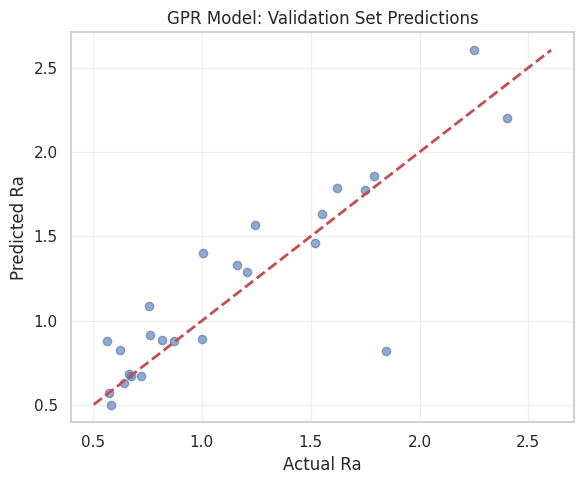

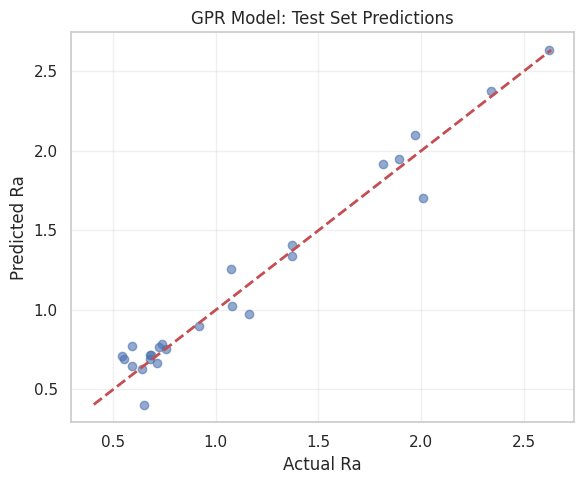


Optimized kernel parameters:
1.38**2 * RBF(length_scale=9.86) + WhiteKernel(noise_level=0.0412)

Hyperparameter Tuning
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters from CV:
{'alpha': 1e-10, 'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1), 'n_restarts_optimizer': 10}
Best CV score (neg MSE): -0.0480

Best Model Performance

Training Set Metrics:
RMSE: 0.1579
MAE: 0.1096
R²: 0.9224
MAPE: 9.31%

Validation Set Metrics:
RMSE: 0.2671
MAE: 0.1684
R²: 0.7545
MAPE: 15.36%

Test Set Metrics:
RMSE: 0.1161
MAE: 0.0788
R²: 0.9641
MAPE: 8.75%


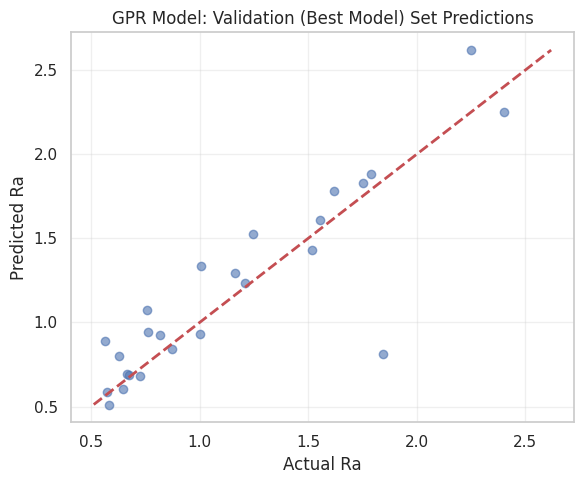

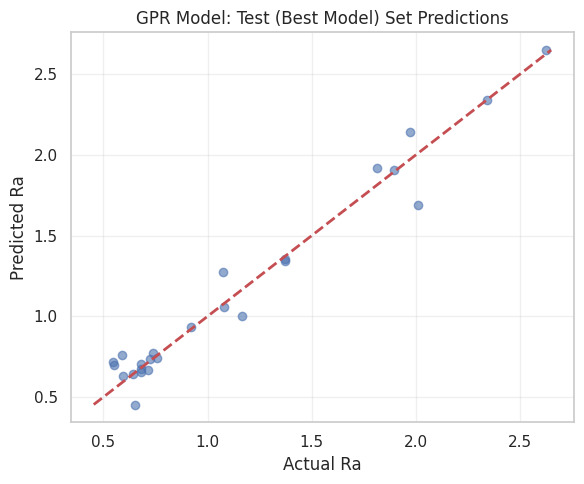


Model Comparison Summary

Default Model vs Tuned Model (Test Set):
Default RMSE: 0.1184 | Tuned RMSE: 0.1161
Default R²: 0.9626 | Tuned R²: 0.9641

Test Set: Actual vs Predicted Values
 Actual  Predicted  Absolute Error  Percentage Error
 0.5510     0.6969          0.1459           26.4752
 1.9700     2.1433          0.1733            8.7982
 1.0780     1.0597          0.0183            1.6973
 1.1640     1.0034          0.1606           13.8009
 2.0080     1.6870          0.3210           15.9855
 0.5900     0.7598          0.1698           28.7721
 0.5440     0.7142          0.1702           31.2887
 0.6490     0.4533          0.1957           30.1486
 0.9190     0.9308          0.0118            1.2869
 1.8140     1.9165          0.1025            5.6494
 0.6800     0.6717          0.0083            1.2159
 1.0730     1.2750          0.2020           18.8280
 2.3430     2.3381          0.0049            0.2112
 2.6240     2.6489          0.0249            0.9488
 0.7550     0.7403 

'\nimport joblib\njoblib.dump(best_gpr, \'/content/drive/MyDrive/gpr_model_Ra.pkl\')\njoblib.dump(scaler, \'/content/drive/MyDrive/gpr_scaler.pkl\')\nprint("\nModel and scaler saved successfully!")\n'

In [ ]:
# Train test validation ration 80:10:10

# ------------------------------------------------------------------------- GPR -------------------------------------------------------------------- #
# Assuming data is already loaded as 'df'
# Define features
top_30_F_features = ['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_max', 'Fz_median', 'Fz_rms', 'Fz_mean', 'Fm', 'Fz_snr', 'Fz_std', 'Fz_peak_amplitude', 'Fx_wav_energy', 'Fz_dom_freq', 'spatial_variability', 'Fx_temp_variability', 'ForceRatio_XY', 'Fz_margin', 'Fx_energy', 'Fx_median', 'Fx_mean', 'Fz_crest', 'Fx_rms', 'Fz_impulse', 'Fz_temp_variability', 'Fz_skew', 'Fz_range', 'Fy_mean', 'Ft_mean', 'Fx_peak_amplitude', 'Fx_dom_freq']

additional_features = ['RPM', 'Feedspeed_mm_min_', 	'Material_removal_rate', 'Class']
all_features = additional_features + top_30_F_features

# Target variable
target_var = 'Ra'

# Custom train-validation-test split (same as SVR)
def custom_train_val_test_split(df):
    """
    Custom split ensuring proper distribution across train, validation, and test sets.
    For each RPM-Feedspeed combination (assuming 9 samples each):
    - 6 samples for training (150 total)
    - 2 samples for validation (50 total)
    - 1 sample for testing (25 total)
    """
    # Get unique RPM-Feedspeed combinations
    combinations = df[['RPM', 'Feedspeed_mm_min_']].drop_duplicates().values

    train_indices = []
    val_indices = []
    test_indices = []

    print(f"Total combinations: {len(combinations)}")

    for rpm, feedspeed in combinations:
        # Get indices for this combination
        indices = df[(df['RPM'] == rpm) & (df['Feedspeed_mm_min_'] == feedspeed)].index.tolist()

        # Shuffle to randomize selection
        np.random.shuffle(indices)

        if len(indices) >= 3:
            # Ensure at least 1 sample in train from each combination
            train_indices.extend(indices[:-2])  # 7-8 samples
            val_indices.append(indices[-2])     # 1 sample
            test_indices.append(indices[-1])    # 1 sample
        else:
            train_indices.extend(indices)  # All to train

    # Create train, validation, and test sets
    X_train = df.loc[train_indices, all_features]
    X_val = df.loc[val_indices, all_features]
    X_test = df.loc[test_indices, all_features]

    y_train = df.loc[train_indices, target_var]
    y_val = df.loc[val_indices, target_var]
    y_test = df.loc[test_indices, target_var]

    print(f"Train size: {len(train_indices)}")
    print(f"Validation size: {len(val_indices)}")
    print(f"Test size: {len(test_indices)}")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Set random seed
np.random.seed(42)

# Perform the split
X_train, X_val, X_test, y_train, y_val, y_test = custom_train_val_test_split(df)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate model
def evaluate_model(model, X, y, set_name="Test"):
    """Evaluate model and print metrics"""
    y_pred = model.predict(X)

    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Calculate percentage errors
    mape = np.mean(np.abs((y - y_pred) / np.maximum(1e-10, np.abs(y)))) * 100

    print(f"\n{set_name} Set Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

# Function to plot predictions
def plot_predictions(y_true, y_pred, set_name="Test"):
    """Simple prediction plot"""
    plt.figure(figsize=(6, 5))
    plt.scatter(y_true, y_pred, alpha=0.6)

    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    plt.xlabel('Actual Ra')
    plt.ylabel('Predicted Ra')
    plt.title(f'GPR Model: {set_name} Set Predictions')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Train initial GPR model with default kernel
print("="*50)
print("Training GPR Model with Default Kernel")
print("="*50)

# Default kernel
default_kernel = ConstantKernel() * RBF() + WhiteKernel()

# Train model
gpr_default = GaussianProcessRegressor(
    kernel=default_kernel,
    n_restarts_optimizer=10,
    random_state=42
)

gpr_default.fit(X_train_scaled, y_train)

# Evaluate on all sets
train_metrics = evaluate_model(gpr_default, X_train_scaled, y_train, "Training")
val_metrics = evaluate_model(gpr_default, X_val_scaled, y_val, "Validation")
test_metrics = evaluate_model(gpr_default, X_test_scaled, y_test, "Test")

# Plot predictions for validation and test sets
plot_predictions(y_val, gpr_default.predict(X_val_scaled), "Validation")
plot_predictions(y_test, gpr_default.predict(X_test_scaled), "Test")

print(f"\nOptimized kernel parameters:")
print(gpr_default.kernel_)

# Hyperparameter tuning using validation set
print("\n" + "="*50)
print("Hyperparameter Tuning")
print("="*50)

# Define hyperparameter grid
param_grid = {
    'kernel': [
        ConstantKernel() * RBF() + WhiteKernel(),
        ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
        ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
    ],
    'alpha': [1e-10, 1e-5, 1e-2],
    'n_restarts_optimizer': [5, 10]
}

# Use 3-fold CV on training data
gpr = GaussianProcessRegressor(random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=gpr,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters from CV:")
print(grid_search.best_params_)
print(f"Best CV score (neg MSE): {grid_search.best_score_:.4f}")

# Get best model and evaluate on validation set
best_gpr = grid_search.best_estimator_

# Evaluate best model
print("\n" + "="*50)
print("Best Model Performance")
print("="*50)

train_metrics_best = evaluate_model(best_gpr, X_train_scaled, y_train, "Training")
val_metrics_best = evaluate_model(best_gpr, X_val_scaled, y_val, "Validation")
test_metrics_best = evaluate_model(best_gpr, X_test_scaled, y_test, "Test")

# Plot final predictions
plot_predictions(y_val, best_gpr.predict(X_val_scaled), "Validation (Best Model)")
plot_predictions(y_test, best_gpr.predict(X_test_scaled), "Test (Best Model)")

# Comparison summary
print("\n" + "="*50)
print("Model Comparison Summary")
print("="*50)

print("\nDefault Model vs Tuned Model (Test Set):")
print(f"Default RMSE: {test_metrics['RMSE']:.4f} | Tuned RMSE: {test_metrics_best['RMSE']:.4f}")
print(f"Default R²: {test_metrics['R2']:.4f} | Tuned R²: {test_metrics_best['R2']:.4f}")

# Print actual vs predicted for test set
y_test_pred = best_gpr.predict(X_test_scaled)
comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred,
    'Absolute Error': np.abs(y_test.values - y_test_pred),
    'Percentage Error': 100 * np.abs(y_test.values - y_test_pred) / np.abs(y_test.values)
})

print("\n" + "="*50)
print("Test Set: Actual vs Predicted Values")
print("="*50)
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print(f"\nAverage Absolute Error: {comparison_df['Absolute Error'].mean():.4f}")
print(f"Average Percentage Error: {comparison_df['Percentage Error'].mean():.2f}%")

# Save the best model
'''
import joblib
joblib.dump(best_gpr, '/content/drive/MyDrive/gpr_model_Ra.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/gpr_scaler.pkl')
print("\nModel and scaler saved successfully!")
'''

# XGBoost

COMPLETE XGBOOST ANALYSIS PIPELINE
ENHANCED XGBOOST PIPELINE WITH BAYESIAN OPTIMIZATION

1. CLASS IMBALANCE ANALYSIS
--------------------------------------------------
CLASS IMBALANCE ANALYSIS

Sample distribution by class:
Class 1: 74 samples (33.2%)
Class 2: 74 samples (33.2%)
Class 3: 75 samples (33.6%)

Ra statistics by class:
       count      mean       std    min    max
Class                                         
1         74  1.660419  0.471569  0.883  2.660
2         74  1.281554  0.482589  0.734  2.668
3         75  0.649533  0.061356  0.516  0.797


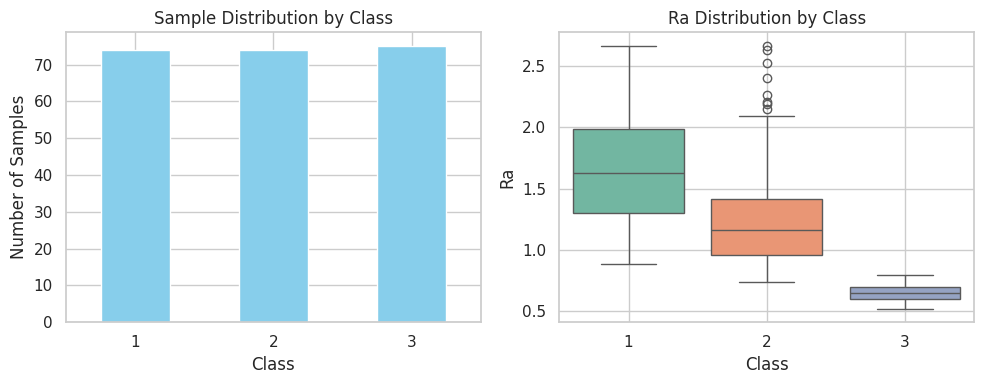


2. DATA SPLITTING
--------------------------------------------------
Creating balanced RPM chunks...
Chunk 0: 45 samples (45 concentrated, 0 scattered)
Chunk 1: 45 samples (45 concentrated, 0 scattered)
Chunk 2: 45 samples (45 concentrated, 0 scattered)
Chunk 3: 44 samples (44 concentrated, 0 scattered)
Chunk 4: 44 samples (44 concentrated, 0 scattered)

Creating balanced Feedspeed chunks...
Chunk 0: 45 samples (45 concentrated, 0 scattered)
Chunk 1: 45 samples (45 concentrated, 0 scattered)
Chunk 2: 45 samples (45 concentrated, 0 scattered)
Chunk 3: 44 samples (44 concentrated, 0 scattered)
Chunk 4: 44 samples (44 concentrated, 0 scattered)

Splitting each RPM-Feedspeed combination with ratio 0.8:0.1:0.1

Final Split Summary:
Training set: 183 samples (82.1%)
Validation set: 20 samples (9.0%)
Test set: 20 samples (9.0%)

Using 34 features for training

3. SAMPLE WEIGHTING FOR IMBALANCE
--------------------------------------------------
Applied sample weights. Weight range: [0.984, 1.

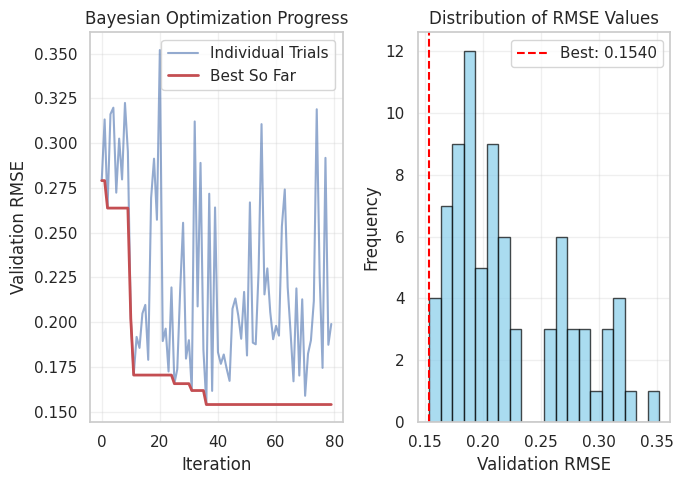


5. FINAL MODEL TRAINING
--------------------------------------------------

6. MODEL EVALUATION
--------------------------------------------------

Training Set Metrics:
R²: 0.9202
RMSE: 0.1620
MAE: 0.1090
MAPE: 10.02%

Validation Set Metrics:
R²: 0.9244
RMSE: 0.1561
MAE: 0.1120
MAPE: 8.93%

Test Set Metrics:
R²: 0.9220
RMSE: 0.1501
MAE: 0.1186
MAPE: 11.57%

7. PERFORMANCE VISUALIZATION
--------------------------------------------------


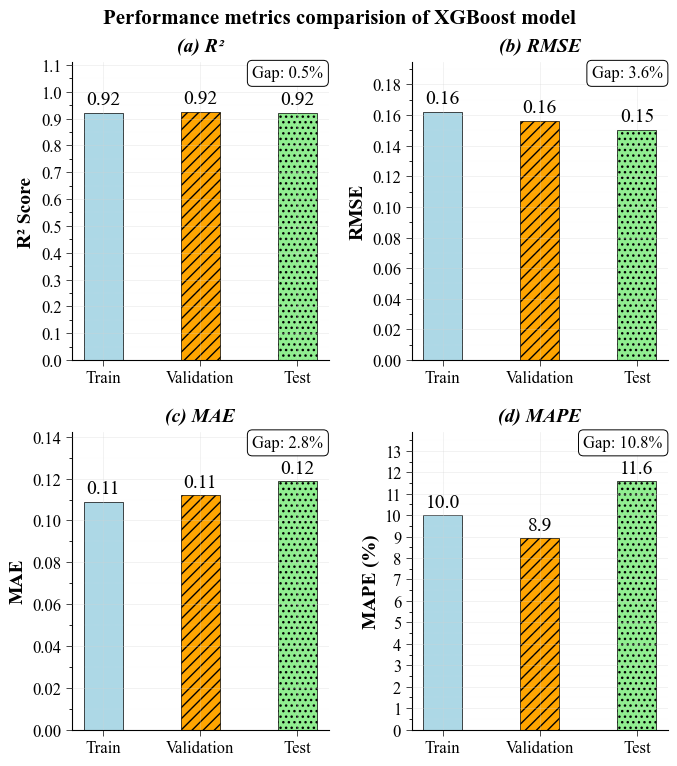

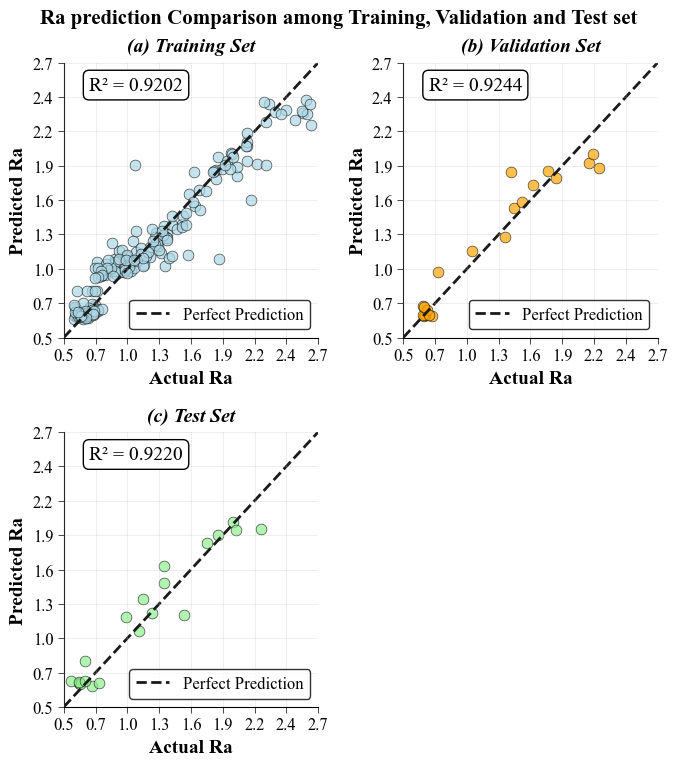


8. FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------

9. FINAL SUMMARY
--------------------------------------------------
Best Validation RMSE from Bayesian Optimization: 0.1540
Final Test Set Performance:
  R²: 0.9220
  RMSE: 0.1501
  MAE: 0.1186
  MAPE: 11.57%

Overfitting Analysis:
  Train-Validation R² Gap: 0.5%
  ✅ Model appears well-generalized

CROSS-VALIDATION STABILITY ANALYSIS

3-Fold Cross-Validation Results:
Fold   RMSE       MAE        R²         MAPE (%)  
--------------------------------------------------------------------------------
1      0.2417     0.1640     0.8122     14.07     
2      0.1822     0.1314     0.8912     12.59     
3      0.2543     0.1679     0.8185     14.54     

SUMMARY STATISTICS:
--------------------------------------------------
Metric     Mean       Std        Min        Max       
--------------------------------------------------
RMSE       0.2261     0.0314     0.1822     0.2543    
MAE        0.1545     0.0164

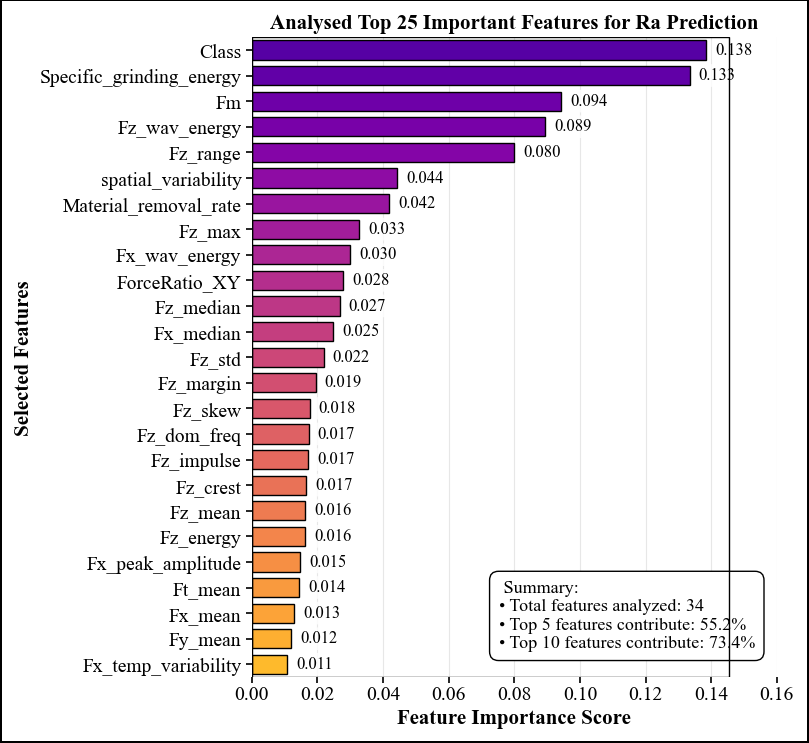

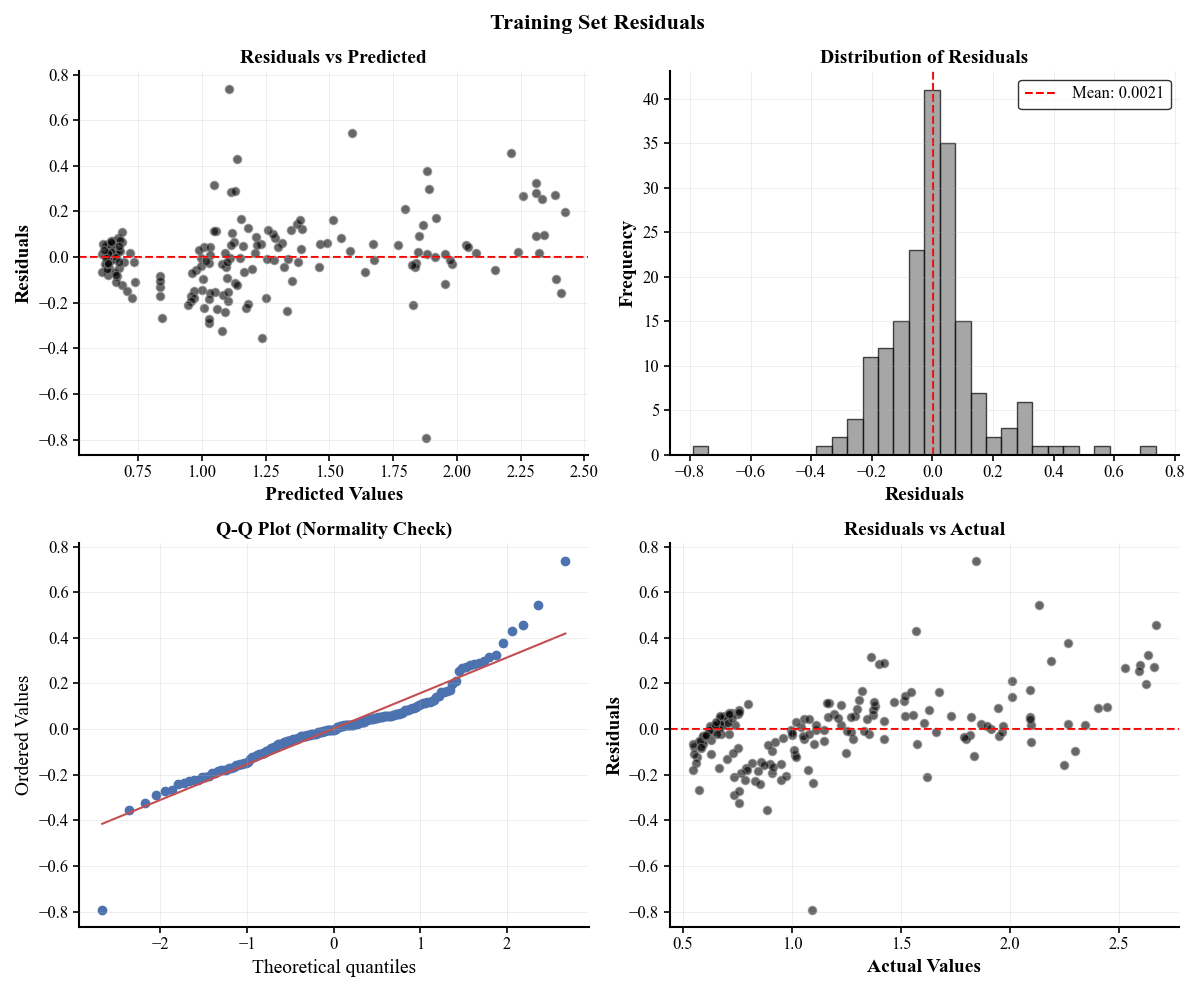


Residual Statistics:
Mean: 0.002115
Std: 0.1619
Min: -0.7906
Max: 0.7377
25th percentile: -0.0746
75th percentile: 0.0589

Shapiro-Wilk Normality Test:
Statistic: 0.9177, p-value: 0.000000
⚠️ Residuals may not be normally distributed


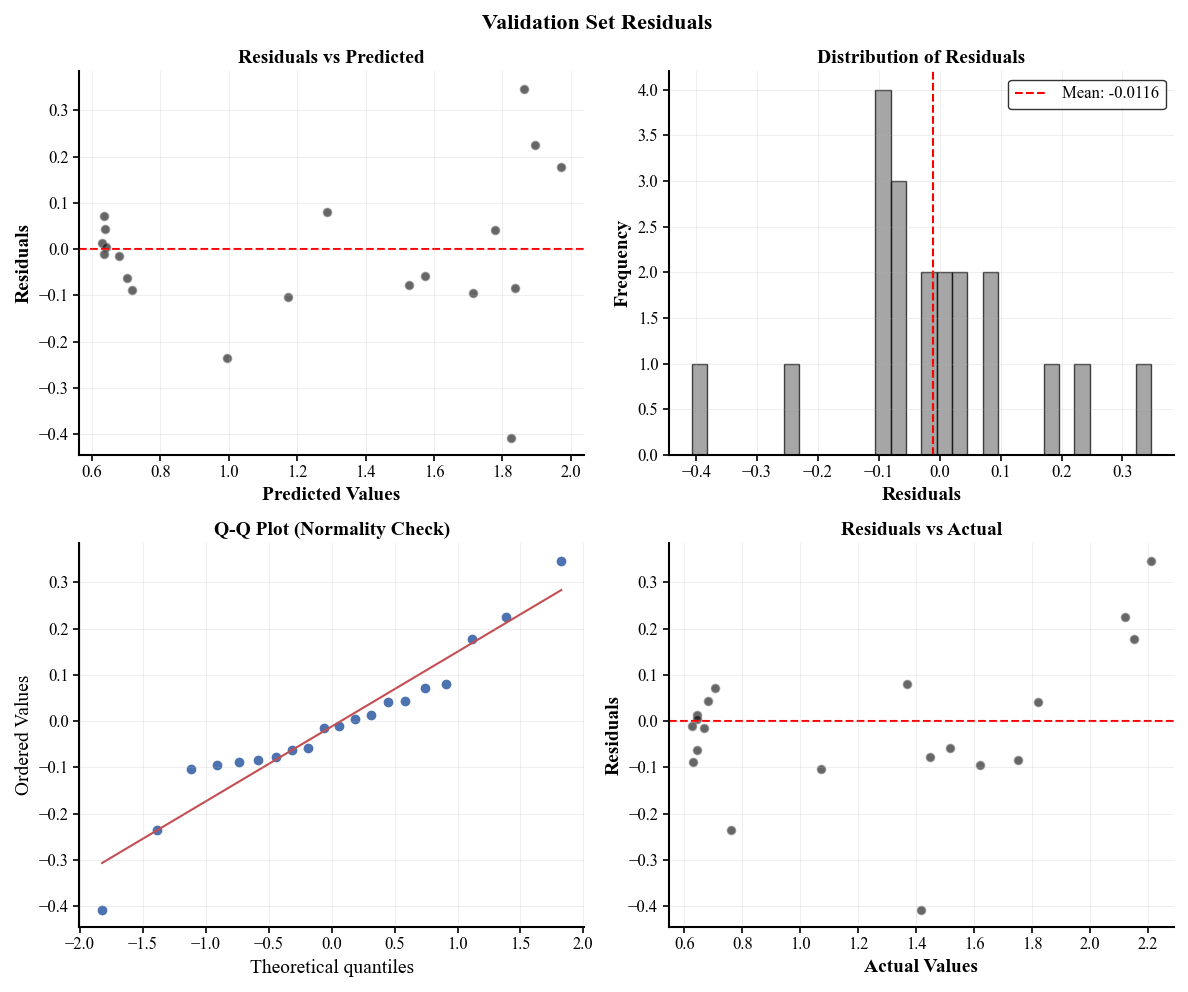


Residual Statistics:
Mean: -0.011597
Std: 0.1557
Min: -0.4076
Max: 0.3469
25th percentile: -0.0857
75th percentile: 0.0514

Shapiro-Wilk Normality Test:
Statistic: 0.9477, p-value: 0.333175
✅ Residuals appear to be normally distributed


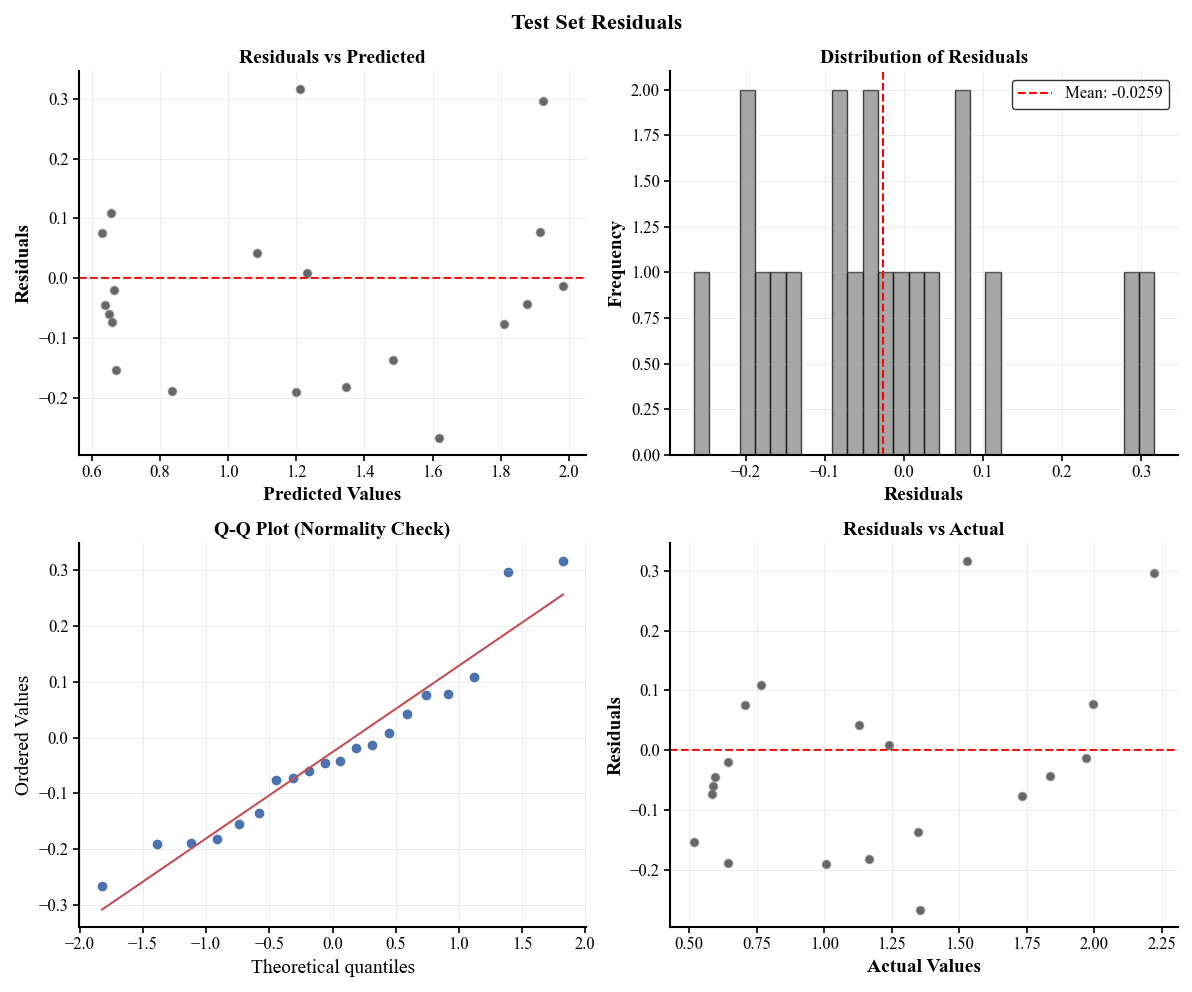


Residual Statistics:
Mean: -0.025940
Std: 0.1479
Min: -0.2661
Max: 0.3167
25th percentile: -0.1404
75th percentile: 0.0505

Shapiro-Wilk Normality Test:
Statistic: 0.9366, p-value: 0.206558
✅ Residuals appear to be normally distributed

LEARNING CURVE ANALYSIS


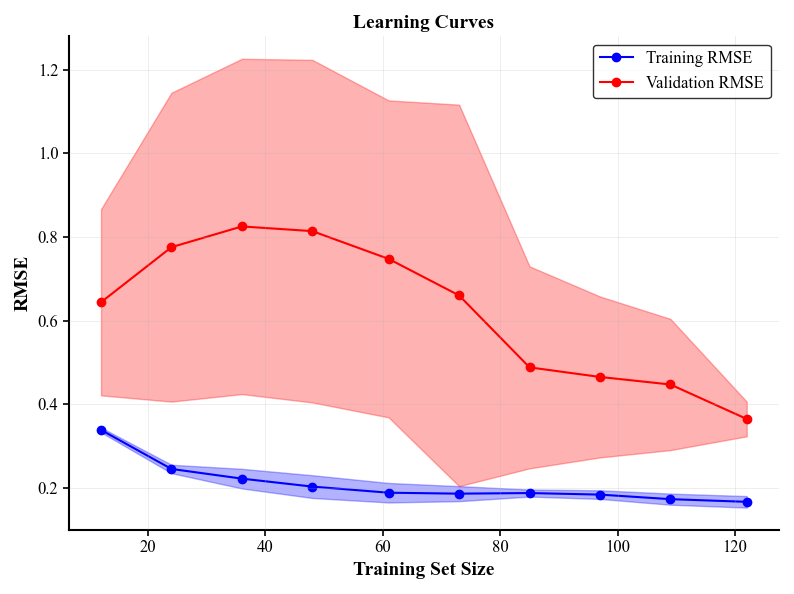

Final train-validation gap: 0.1980
Gap trend (negative means converging): -0.1071
✅ Train-validation gap is converging - model benefits from more data

FINAL COMPREHENSIVE REPORT

📊 MODEL PERFORMANCE SUMMARY:
   Test R²: 0.9220
   Test RMSE: 0.1501
   Test MAE: 0.1186
   Test MAPE: 11.57%

🔄 CROSS-VALIDATION STABILITY:
   CV Mean RMSE: 0.2261 ± 0.0314
   CV Coefficient of Variation: 0.139

⚖️ OVERFITTING ASSESSMENT:
   Train-Val R² Gap: 0.5%
   Status: ✅ Excellent generalization


In [ ]:
# -----------------------------------------------XGBoost-------------------------------------------------------------


def create_balanced_chunks(df_subset, values_col, n_chunks=5, concentrated_values=None):
    """
    Creating balanced chunks ensuring equal representation of concentrated and scattered values
    using the original DataFrame indices.
    """
    df_temp = df_subset[[values_col]].copy()

    # Identify concentrated vs scattered samples based on the original index
    if concentrated_values is not None:
        concentrated_mask = df_temp[values_col].isin(concentrated_values)
        concentrated_indices = df_temp.index[concentrated_mask].tolist()
        scattered_indices = df_temp.index[~concentrated_mask].tolist()
    else:
        concentrated_indices = []
        scattered_indices = df_temp.index.tolist()

    # Sort scattered values by the value itself, but keep original indices
    scattered_df = df_temp.loc[scattered_indices].sort_values(values_col)
    scattered_indices_sorted = scattered_df.index.tolist()

    # Calculate target size per chunk
    total_samples = len(df_subset)
    target_per_chunk = total_samples // n_chunks
    remainder = total_samples % n_chunks

    # Distribute concentrated samples evenly across chunks
    concentrated_per_chunk = len(concentrated_indices) // n_chunks
    concentrated_remainder = len(concentrated_indices) % n_chunks

    chunks = {}
    concentrated_start = 0
    scattered_start = 0

    for chunk_id in range(n_chunks):
        chunks[chunk_id] = []

        # Add concentrated samples to this chunk using original indices
        concentrated_end = concentrated_start + concentrated_per_chunk
        if chunk_id < concentrated_remainder:
            concentrated_end += 1

        chunk_concentrated = concentrated_indices[concentrated_start:concentrated_end]
        chunks[chunk_id].extend(chunk_concentrated)
        concentrated_start = concentrated_end

        # Calculate remaining space in chunk
        current_chunk_size = len(chunks[chunk_id])
        chunk_target = target_per_chunk + (1 if chunk_id < remainder else 0)
        scattered_needed = chunk_target - current_chunk_size

        # Add scattered samples to fill the chunk using sorted original indices
        scattered_end = scattered_start + scattered_needed
        chunk_scattered = scattered_indices_sorted[scattered_start:scattered_end]  # Fixed typo
        chunks[chunk_id].extend(chunk_scattered)
        scattered_start = scattered_end

        print(f"Chunk {chunk_id}: {len(chunks[chunk_id])} samples "
              f"({len(chunk_concentrated)} concentrated, {len(chunk_scattered)} scattered)")

    return chunks

def custom_train_val_test_split(df, target_col='Ra', rpm_col='RPM', feedspeed_col='Feedspeed_mm_min_',
                               train_ratio=0.7, val_ratio=0.2, test_ratio=0.1,
                               n_rpm_chunks=5, n_feedspeed_chunks=5):
    """
    Create stratified train/val/test split ensuring representation from all RPM-Feedspeed combinations
    """
    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
        raise ValueError("Split ratios must sum to 1.0")

    # Define concentrated values
    concentrated_rpm = [6000, 8000, 10000, 12000, 14000]
    concentrated_feedspeed = [150, 250, 350, 450, 550]

    print("Creating balanced RPM chunks...")
    rpm_chunks = create_balanced_chunks(df, rpm_col, n_rpm_chunks, concentrated_rpm)

    print("\nCreating balanced Feedspeed chunks...")
    feedspeed_chunks = create_balanced_chunks(df, feedspeed_col, n_feedspeed_chunks, concentrated_feedspeed)

    # Create RPM-Feedspeed grid combinations using the chunk assignments
    df_copy = df.copy()
    df_copy['rpm_chunk'] = -1
    df_copy['feedspeed_chunk'] = -1

    # Assign chunk labels based on the indices returned by create_balanced_chunks
    for chunk_id, indices in rpm_chunks.items():
        df_copy.loc[indices, 'rpm_chunk'] = chunk_id

    for chunk_id, indices in feedspeed_chunks.items():
        df_copy.loc[indices, 'feedspeed_chunk'] = chunk_id

    # Create combined chunk identifier
    df_copy['combined_chunk'] = df_copy['rpm_chunk'].astype(str) + '_' + df_copy['feedspeed_chunk'].astype(str)

    # Split each combined chunk proportionally
    train_indices = []
    val_indices = []
    test_indices = []
    chunk_info = []

    print(f"\nSplitting each RPM-Feedspeed combination with ratio {train_ratio:.1f}:{val_ratio:.1f}:{test_ratio:.1f}")

    for combined_chunk in df_copy['combined_chunk'].unique():
        chunk_data = df_copy[df_copy['combined_chunk'] == combined_chunk]
        chunk_indices = chunk_data.index.tolist()

        if len(chunk_indices) == 0:
            continue

        rpm_chunk = chunk_data['rpm_chunk'].iloc[0]
        feedspeed_chunk = chunk_data['feedspeed_chunk'].iloc[0]

        # Handle cases with very few samples
        if len(chunk_indices) == 1:
            train_indices.extend(chunk_indices)
            chunk_train, chunk_val, chunk_test = 1, 0, 0
        elif len(chunk_indices) == 2:
            train_indices.extend(chunk_indices[:1])
            val_indices.extend(chunk_indices[1:])
            chunk_train, chunk_val, chunk_test = 1, 1, 0
        else:
            # Split larger chunks proportionally
            if test_ratio > 0:
                train_val_indices, test_chunk_indices = train_test_split(
                    chunk_indices, test_size=test_ratio, random_state=42
                )
                test_indices.extend(test_chunk_indices)
                chunk_test = len(test_chunk_indices)
            else:
                train_val_indices = chunk_indices
                chunk_test = 0

            if val_ratio > 0 and len(train_val_indices) > 1:
                val_size = val_ratio / (train_ratio + val_ratio)
                train_chunk_indices, val_chunk_indices = train_test_split(
                    train_val_indices, test_size=val_size, random_state=42
                )
                train_indices.extend(train_chunk_indices)
                val_indices.extend(val_chunk_indices)
                chunk_train = len(train_chunk_indices)
                chunk_val = len(val_chunk_indices)
            else:
                train_indices.extend(train_val_indices)
                chunk_train = len(train_val_indices)
                chunk_val = 0

        chunk_info.append({
            'RPM_Chunk': rpm_chunk,
            'Feedspeed_Chunk': feedspeed_chunk,
            'Combined_Chunk': combined_chunk,
            'Total_Samples': len(chunk_indices),
            'Train_Samples': chunk_train,
            'Val_Samples': chunk_val,
            'Test_Samples': chunk_test
        })

    # Create final datasets using the collected indices
    train_df = df.loc[train_indices].copy()
    val_df = df.loc[val_indices].copy()
    test_df = df.loc[test_indices].copy()

    # Separate features and target
    feature_cols = [col for col in df.columns if col != target_col]

    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_val = val_df[feature_cols]
    y_val = val_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    # Print summary
    print(f"\nFinal Split Summary:")
    print(f"Training set: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
    print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")
    print(f"Test set: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")

    # Store split info for analysis
    split_info = {
        'train_df': train_df,
        'val_df': val_df,
        'test_df': test_df,
        'chunk_info': pd.DataFrame(chunk_info)
    }

    return X_train, X_val, X_test, y_train, y_val, y_test, split_info

def analyze_class_imbalance(df, class_col='Class', target_col='Ra'):
    """
    Analyze class distribution and Ra value distribution per class
    """
    print("="*60)
    print("CLASS IMBALANCE ANALYSIS")
    print("="*60)

    # Class distribution
    class_dist = df[class_col].value_counts().sort_index()
    print("\nSample distribution by class:")
    for class_val, count in class_dist.items():
        percentage = count / len(df) * 100
        print(f"Class {class_val}: {count} samples ({percentage:.1f}%)")

    # Ra statistics per class
    print(f"\n{target_col} statistics by class:")
    ra_stats = df.groupby(class_col)[target_col].agg(['count', 'mean', 'std', 'min', 'max'])
    print(ra_stats)

    # Plot class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Class sample counts
    class_dist.plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Sample Distribution by Class')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=0)

    # Ra distribution by class
    sns.boxplot(x=class_col, y=target_col, data=df, ax=ax2, palette="Set2")
    ax2.set_title(f'{target_col} Distribution by Class')
    ax2.grid(True)
    ax2.set_xlabel('Class')
    ax2.set_ylabel(target_col)

    plt.tight_layout()
    plt.show()

    return class_dist, ra_stats

def bayesian_xgboost_optimization(X_train, y_train, X_val, y_val, n_calls=100):
    """
    Bayesian optimization for XGBoost hyperparameters using scikit-optimize
    """
    print("="*60)
    print("BAYESIAN HYPERPARAMETER OPTIMIZATION")
    print("="*60)

    # Convert to numpy arrays
    X_train_np = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
    y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
    X_val_np = X_val.to_numpy() if isinstance(X_val, pd.DataFrame) else X_val
    y_val_np = y_val.to_numpy() if isinstance(y_val, pd.Series) else y_val

    # Define search space
    space = [
        Integer(40,1200, name='n_estimators'),
        Integer(1, 3, name='max_depth'),
        Real(0.03, 0.3, name='learning_rate', prior='log-uniform'),
        Real(0.4, 0.8, name='subsample'),
        Real(0.4, 1.0, name='colsample_bytree'),
        Integer(2, 5, name='min_child_weight'),
        Real(0.1, 1.0, name='gamma'),
        Real(1.0, 4.0, name='reg_alpha'),
        Real(2.0, 5.0, name='reg_lambda'),

    ]

    # Store results
    eval_results = []

    @use_named_args(space)
    def objective(**params):
        # Create model with current parameters
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1,
            verbosity=0,
            **params
        )

        # Fit model
        model.fit(X_train_np, y_train_np)

        # Predict on validation set
        y_pred = model.predict(X_val_np)

        # Calculate RMSE (minimize)
        rmse = np.sqrt(mean_squared_error(y_val_np, y_pred))

        # Store results for analysis
        eval_results.append({
            'params': params.copy(),
            'rmse': rmse,
            'iteration': len(eval_results)
        })

        if len(eval_results) % 10 == 0:
            print(f"Iteration {len(eval_results)}: RMSE = {rmse:.4f}")

        return rmse

    print(f"Starting Bayesian optimization with {n_calls} iterations...")

    # Run optimization
    result = gp_minimize(
        func=objective,
        dimensions=space,
        n_calls=n_calls,
        n_initial_points=10,
        acq_func='EI',  # Changed from acquisition_func to acq_func
        random_state=42,
        verbose=False
    )

    # Extract best parameters
    best_params = dict(zip([dim.name for dim in space], result.x))
    best_rmse = result.fun

    print(f"\nOptimization completed!")
    print(f"Best RMSE: {best_rmse:.4f}")
    print(f"Best parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    return best_params, best_rmse, eval_results

def plot_optimization_progress(eval_results):
    """
    Plot the optimization progress
    """
    # Handle both eval_results list and Optuna Study object
    if hasattr(eval_results, 'trials'):
        # It's an Optuna Study object
        trials = eval_results.trials
        iterations = list(range(1, len(trials) + 1))
        rmse_values = [trial.value for trial in trials]
    else:
        # It's a list of results
        iterations = [r['iteration'] for r in eval_results]
        rmse_values = [r['rmse'] for r in eval_results]

    # Calculate cumulative best
    cumulative_best = []
    best_so_far = float('inf')
    for rmse in rmse_values:
        if rmse < best_so_far:
            best_so_far = rmse
        cumulative_best.append(best_so_far)

    plt.figure(figsize=(7, 5))

    plt.subplot(1, 2, 1)
    plt.plot(iterations, rmse_values, 'b-', alpha=0.6, label='Individual Trials')
    plt.plot(iterations, cumulative_best, 'r-', linewidth=2, label='Best So Far')
    plt.xlabel('Iteration')
    plt.ylabel('Validation RMSE')
    plt.title('Bayesian Optimization Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(rmse_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(min(rmse_values), color='red', linestyle='--', label=f'Best: {min(rmse_values):.4f}')
    plt.xlabel('Validation RMSE')
    plt.ylabel('Frequency')
    plt.title('Distribution of RMSE Values')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X, y, set_name="Test"):
    """
    Evaluate model and return all core metrics
    """
    # Convert to numpy arrays if needed
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()

    y_pred = model.predict(X)

    # Calculate all metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Calculate MAPE with protection against division by zero
    mape = np.mean(np.abs((y - y_pred) / np.maximum(1e-10, np.abs(y)))) * 100

    print(f"\n{set_name} Set Metrics:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return {'R2': r2, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'predictions': y_pred}

def plot_training_validation_comparison(train_metrics, val_metrics, test_metrics=None):
    """
    Plot training vs validation performance comparison with improved styling
    """
    # Reset matplotlib to defaults first
    plt.rcdefaults()

    # Scientific publication font settings - keeping original sizes
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 14,  # Increased back to match original
        'axes.titlesize': 14,  # Match original
        'axes.labelsize': 14,  # Match original
        'xtick.labelsize': 14,  # Match original
        'ytick.labelsize': 14,  # Match original
        'legend.fontsize': 12,
        'figure.titlesize': 14,  # Match original title size
        'text.usetex': False,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'grid.alpha': 0.5,
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'xtick.direction': 'out',
        'ytick.direction': 'out',
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.axisbelow': False,  # Grid on top of bars
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'savefig.dpi': 500,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1,
        'savefig.facecolor': 'white',
        'savefig.edgecolor': 'none',
        'text.color': 'black',
        'axes.labelcolor': 'black',
        'axes.edgecolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'legend.edgecolor': 'black',
        'legend.facecolor': 'white',
    })

    metrics = ['R2', 'RMSE', 'MAE', 'MAPE']
    titles = ['(a) R²', '(b) RMSE', '(c) MAE', '(d) MAPE']
    y_labels = ['R² Score', 'RMSE', 'MAE', 'MAPE (%)']

    train_values = [train_metrics[m] for m in metrics]
    val_values = [val_metrics[m] for m in metrics]

    if test_metrics:
        test_values = [test_metrics[m] for m in metrics]

    # Keep original figure size (no dpi here - only for saving)
    fig, axes = plt.subplots(2, 2, figsize=(7, 8))
    axes = axes.flatten()

    # Keep more similar to original subplot adjustment
    plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.06, wspace=0.1, hspace=0.1)

    # Professional title styling - using original font size
    fig.suptitle('Performance metrics comparision of XGBoost model',
                fontsize=15, fontweight='bold', y=0.96)

    # Professional color palette - subtle and print-friendly
    colors = {
        'Train': 'lightblue',      # Soft blue
        'Validation': 'orange',     # Soft orange
        'Test': 'lightgreen'        # Soft green
    }

    # Define patterns for black and white printing
    patterns = ['', '///', '...']  # No pattern, diagonal lines, dots

    # Track if we need to create a legend
    legend_created = False

    for i, (metric, title, y_label) in enumerate(zip(metrics, titles, y_labels)):
        ax = axes[i]

        x_pos = np.arange(2 if not test_metrics else 3)
        values = [train_values[i], val_values[i]]
        labels = ['Train', 'Validation']

        dataset_colors = ['lightblue', 'orange']

        if test_metrics:
            values.append(test_values[i])
            labels.append('Test')
            dataset_colors.append('lightgreen')

        width = 0.4  # Keep bar width as original

        # Store all values for y-axis scaling
        all_values = []

        # Create grouped bars with improved styling
        for j, (value, label) in enumerate(zip(values, labels)):
            bar = ax.bar(x_pos[j], value, width,
                        label=label if i == 0 else "",  # Only label first subplot
                        color=dataset_colors[j],
                        edgecolor='black',
                        linewidth=0.5,
                        hatch=patterns[j],
                        alpha=1,
                        zorder=2)  # Lower zorder so grid appears on top

            all_values.append(value)

            # Add value labels on top of bars with 90 degree rotation
            height = bar[0].get_height()
            if metric in ['RMSE', 'MAE']:
                label_text = f'{value:.2f}'
            elif metric == 'MAPE':
                label_text = f'{value:.1f}'
            else:  # R2
                label_text = f'{value:.2f}'

            # Rotated text above bars with original font size
            ax.text(bar[0].get_x() + bar[0].get_width() / 2.,
                   height + max(all_values) * 0.02,
                   label_text,
                   ha='center', va='bottom',
                   fontsize=14,  # Back to original size
                   color='black',
                   )  # 90 degree rotation

        # Professional title styling with original size
        ax.set_title(title, fontsize=14, fontweight='bold', loc='center', style='italic', pad=8)

        # Axis formatting with bold labels - original size
        ax.set_ylabel(y_label, fontweight='bold', fontsize=14)

        # X-axis setup with original size
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels, fontsize=14, rotation=0)

        # Y-axis setup with appropriate scaling and ticks
        from matplotlib.ticker import MultipleLocator, MaxNLocator

        if metric == 'R2':
            # R2: 0 to 1 with 0.1 intervals
            ax.set_ylim(0, 1)  # Extra space for rotated labels
            ax.yaxis.set_major_locator(MultipleLocator(0.1))
            ax.yaxis.set_minor_locator(MultipleLocator(0.05))
        elif metric == 'RMSE' or metric == 'MAE':
            # Dynamic scaling for RMSE and MAE
            y_max = max(all_values) * 1.18  # 18% padding for rotated labels
            ax.set_ylim(0, y_max)
            if y_max <= 0.22:
                ax.yaxis.set_major_locator(MultipleLocator(0.02))
                ax.yaxis.set_minor_locator(MultipleLocator(0.01))
            else:
                ax.yaxis.set_major_locator(MaxNLocator(8))
                ax.yaxis.set_minor_locator(MaxNLocator(16))
        elif metric == 'MAPE':
            y_max = max(all_values) * 1.18
            if y_max <= 20:
                ax.set_ylim(0, min(16, y_max))
                ax.yaxis.set_major_locator(MultipleLocator(1))
                ax.yaxis.set_minor_locator(MultipleLocator(0.5))
            else:
                ax.set_ylim(0, y_max)
                ax.yaxis.set_major_locator(MultipleLocator(2.5))
                ax.yaxis.set_minor_locator(MultipleLocator(0.5))

        # Grid styling - both horizontal and vertical, on top of bars
        ax.grid(True, axis='both', which='major', color='#D3D3D3',
               linestyle='-', linewidth=0.5, alpha=0.4, zorder=3)
        ax.grid(True, axis='both', which='minor', color='#E8E8E8',
               linestyle=':', linewidth=0.3, alpha=0.4, zorder=3)

        # Make sure grid is on top
        ax.set_axisbelow(False)

        # Spine styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')

        # Tick parameters
        ax.tick_params(axis='both', which='major', colors='black', labelsize=12)
        ax.tick_params(axis='both', which='minor', colors='black', labelsize=12)
        ax.tick_params(axis='y', which='major', length=4)
        ax.tick_params(axis='y', which='minor', length=2)
        ax.tick_params(axis='x', which='major', length=4)

        # Add gap analysis in top right corner (keeping from original)
        if len(values) >= 2:
            gap = abs(values[0] - values[1])
            gap_pct = gap / abs(values[0]) * 100 if values[0] != 0 else 0
            ax.text(0.98, 0.99, f'Gap: {gap_pct:.1f}%',
                   transform=ax.transAxes,
                   ha='right', va='top', fontsize=12,
                   bbox=dict(boxstyle='round,pad=0.3',
                            facecolor='white',
                            edgecolor='black',
                            alpha=1,
                            linewidth=0.7))

        # Set y-axis limit to avoid label clipping
        ax.set_ylim(0, max(values) * 1.2)

        # Reduce margins
        ax.margins(x=0.05)

    # Adjust layout for A4 paper compatibility
    plt.tight_layout(rect=[0, 0.02, 1, 0.92])
    plt.tight_layout()

    # Save with high DPI as in the improved version
    plt.savefig('performance_comparison.png', dpi=500, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.savefig('performance_comparison.pdf', bbox_inches='tight',
                facecolor='white', edgecolor='none')

    plt.show()

def plot_predictions_comparison(y_train, train_pred, y_val, val_pred, y_test=None, test_pred=None):
    """
    Plot actual vs predicted values for all sets with Times New Roman font and subplot labels in 2x2 layout
    """
    # Set Times New Roman font globally with fallback options

    plt.rcParams['font.serif'] = ['Times New Roman',]

    n_plots = 2 if test_pred is None else 3
    # Create 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(7, 8))
    #fig, axes = plt.subplots(1, n_plots, figsize=(12, 4))

    # Flatten axes for easier indexing
    axes_flat = axes.flatten()

    datasets = [
        (y_train, train_pred, "Training"),
        (y_val, val_pred, "Validation")
    ]

    if test_pred is not None:
        datasets.append((y_test, test_pred, "Test"))

    # Calculate global min and max for consistent axis scaling
    all_actual = []
    all_pred = []

    for y_true, y_pred, _ in datasets:
        if isinstance(y_true, pd.Series):
            y_true = y_true.to_numpy()
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.to_numpy()
        all_actual.extend(y_true)
        all_pred.extend(y_pred)

    # Find global min and max
    global_min = min(min(all_actual), min(all_pred))
    global_max = max(max(all_actual), max(all_pred))

    # Add some padding (5% on each side)
    padding = (global_max - global_min) * 0.03
    axis_min = global_min - padding
    axis_max = global_max + padding

    # Create consistent tick locations
    tick_interval = (axis_max - axis_min) / 8  # Approximately 8-10 ticks
    ticks = np.arange(axis_min, axis_max + tick_interval, tick_interval)

    # Professional title styling - using original font size
    fig.suptitle('Ra prediction Comparison among Training, Validation and Test set',
                fontsize=15, fontweight='bold', y=0.96)

    subplot_labels = ['a', 'b', 'c']
    titles = ['(a) Training Set', '(b) Validation Set', '(c) Test Set']
    colors = ['lightblue', 'orange', 'lightgreen']  # Blue, Orange, Green

    for i, (y_true, y_pred, dataset_name) in enumerate(datasets):
        ax = axes_flat[i]

        # Convert to numpy if needed
        if isinstance(y_true, pd.Series):
            y_true = y_true.to_numpy()
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.to_numpy()

        # Scatter plot with colors
        ax.scatter(y_true, y_pred, alpha=0.7, s=60, c=colors[i % len(colors)],
                  edgecolors='black', linewidth=0.5)

        # Perfect prediction line using global min/max
        ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k--', lw=2,
                label='Perfect Prediction')

        # Calculate and display R²
        r2 = r2_score(y_true, y_pred)
        ax.text(0.10, 0.90, f'R² = {r2:.4f}', transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='white',
                        edgecolor='black', alpha=1), fontsize=14)

        # Set consistent axis limits and ticks for ALL subplots
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)

        # Format tick labels to show 1 decimal place
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))

        # Increased font sizes for Word compatibility
        ax.set_xlabel('Actual Ra', fontweight='bold',  fontsize=14)
        ax.set_ylabel('Predicted Ra', fontweight='bold', fontsize=14)
        ax.set_title(titles[i], fontsize=14, fontweight='bold', style='italic', pad=8)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=12)
        ax.tick_params(axis='both', labelsize=12)

        # Put subplot labels in top left corner instead of bottom
        #ax.text(0.02, 0.98, subplot_labels[i], transform=ax.transAxes,
        #        fontsize=12, fontweight='bold', va='top', ha='left')


    # Hide the last subplot (bottom-right) to create white space
    axes_flat[3].set_visible(False)

    # If only 2 plots, also hide the third subplot position (bottom-left)
    if n_plots == 2:
        axes_flat[2].set_visible(False)

    plt.tight_layout()

    # Save with 500 DPI
    plt.savefig('predictions_comparison.png', dpi=500, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.savefig('predictions_comparison.pdf', bbox_inches='tight',
                facecolor='white', edgecolor='none')

    plt.show()

def plot_feature_importance(model, feature_names, top_n=25, figsize=(7,8), dpi=500):
    """
    Create publication-ready feature importance plot with scientific formatting

    Parameters:
    -----------
    model : sklearn model
        Trained model with feature_importances_ attribute
    feature_names : list
        List of feature names
    top_n : int, default 25
        Number of top features to display
    figsize : tuple, default (8, 10)
        Figure size optimized for publication
    dpi : int, default 300
        Resolution for high-quality output

    Returns:
    --------
    tuple : (figure, feature_importance_dataframe)
    """

    # Scientific publication font settings - ALL Times New Roman
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'font.serif': ['Times New Roman'],
        'font.sans-serif': ['Times New Roman'],
        'font.monospace': ['Times New Roman'],
        'font.cursive': ['Times New Roman'],
        'font.fantasy': ['Times New Roman'],
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 16,
        'axes.linewidth': 1.5,
        'xtick.major.width': 1.2,
        'ytick.major.width': 1.2,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'savefig.dpi': dpi,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.15
    })

    # Check for feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_).flatten()
    else:
        print("Feature importance not available for this model")
        return None, None

    # Create dataframe and sort
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False).head(top_n)

    # Calculate statistics for scientific reporting
    total_importance = feature_imp['importance'].sum()
    cumulative_importance = feature_imp['importance'].cumsum() / feature_imp['importance'].sum() * 100

    # Create figure with specific layout for border
    fig = plt.figure(figsize=figsize, facecolor='white')

    # Create axis with compact layout
    ax = fig.add_axes([0.10, 0.10, 0.75, 0.80])  # [left, bottom, width, height]

    # Enhanced color palette - scientific and colorblind-friendly
    colors = plt.cm.plasma(np.linspace(0.15, 0.85, len(feature_imp)))

    # Create horizontal bars with enhanced styling
    bars = ax.barh(range(len(feature_imp)), feature_imp['importance'],
                   color=colors,
                   edgecolor='black',
                   linewidth=1.0,
                   alpha=1,
                   height=0.75)

    # Enhanced axis styling - remove default spines and add custom border
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add custom border around plot area
    plot_border = Rectangle((ax.get_xlim()[0], -0.5),
                           ax.get_xlim()[1] - ax.get_xlim()[0],
                           len(feature_imp),
                           linewidth=1.0,
                           edgecolor='black',
                           facecolor='none',
                           zorder=10)
    ax.add_patch(plot_border)

    # Scientific grid - AFTER border, with clipping to plot area
    ax.grid(True, axis='x', alpha=0.3, linestyle='-', linewidth=0.8, zorder=1)
    ax.set_axisbelow(True)

    # ADD THESE TWO LINES HERE:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(-0.5, len(feature_imp) - 0.5)

    # Enhanced labels with scientific formatting
    ax.set_xlabel('Feature Importance Score', fontsize=15, fontweight='bold', fontfamily='Times New Roman')
    ax.set_ylabel('Selected Features', fontsize=15, fontweight='bold', fontfamily='Times New Roman')

    # Scientific title with model information - closer to plot
    model_name = type(model).__name__
    title = f'Analysed Top 25 Important Features for Ra Prediction'
    ax.set_title(title, fontsize=15, fontweight='bold', ha='center', fontfamily='Times New Roman')

    # Set y-axis labels with better formatting
    ax.set_yticks(range(len(feature_imp)))
    ax.set_yticklabels(feature_imp['feature'], fontsize=14, fontweight='normal', ha='right', fontfamily='Times New Roman')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([f'{x:.2f}' for x in ax.get_xticks()], fontsize=14, fontweight='normal', fontfamily='Times New Roman')
    ax.tick_params(axis='x', pad=2)

    # Invert y-axis so most important feature is at top
    ax.invert_yaxis()

    # Add professional value labels on bars
    max_importance = feature_imp['importance'].max()
    for i, (idx, row) in enumerate(feature_imp.iterrows()):
        # Position labels inside or outside based on bar length
        label_pos = row['importance'] + max_importance * 0.02
        if label_pos > ax.get_xlim()[1] * 0.95:  # If too close to edge, put inside
            label_pos = row['importance'] - max_importance * 0.02
            color = 'black'
        else:
            color = 'black'

        ax.text(label_pos, i, f'{row["importance"]:.3f}',
                va='center', ha='left', fontsize=12, fontweight='normal',  # Size 12, not bold
                color=color,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='none'))

    # Add cumulative importance information (scientific detail)
    top_5_cumulative = cumulative_importance.iloc[4] if len(cumulative_importance) > 4 else cumulative_importance.iloc[-1]
    top_10_cumulative = cumulative_importance.iloc[9] if len(cumulative_importance) > 9 else cumulative_importance.iloc[-1]

    # Add statistical information box INSIDE the plot border (bottom right)
    stats_text = (f' Summary:\n'
                 f'• Total features analyzed: {len(feature_names)}\n'
                 f'• Top 5 features contribute: {top_5_cumulative:.1f}%\n'
                 f'• Top 10 features contribute: {top_10_cumulative:.1f}%')

    # Position stats box inside the actual plot area (within the border)
    ax.text(0.47, 0.04, stats_text, fontsize=13,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=1),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes, fontfamily='Times New Roman')



    # Add a subtle outer border to the entire figure
    fig.patch.set_edgecolor('black')
    fig.patch.set_linewidth(1.5)

    # Compact layout adjustments
    plt.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.10)
    plt.tight_layout()

    # Save with 500 DPI
    plt.savefig('Important_Features.png', dpi=500, bbox_inches='tight',
                facecolor='white', edgecolor='none')


    return fig, feature_imp

def apply_sample_weights(y_train, class_col_train=None, method='inverse_variance'):
    """
    Apply sample weights to handle class imbalance
    """
    if class_col_train is None:
        # For regression, use variance-based weighting
        if method == 'inverse_variance':
            # Weight samples inversely proportional to local variance
            # This is a simple approach - you might want to use more sophisticated methods
            weights = np.ones(len(y_train))
            return weights
    else:
        # For class-based weighting
        class_counts = class_col_train.value_counts()
        class_weights = len(class_col_train) / (len(class_counts) * class_counts)
        weights = class_col_train.map(class_weights).values
        return weights

    return np.ones(len(y_train))

def enhanced_xgboost_pipeline(df, target_col='Ra', feature_cols=None, n_optimization_calls=50):
    """
    Enhanced XGBoost pipeline with Bayesian optimization and comprehensive analysis
    """
    print("="*80)
    print("ENHANCED XGBOOST PIPELINE WITH BAYESIAN OPTIMIZATION")
    print("="*80)

    # Set random seed
    np.random.seed(42)

    # Analyze class imbalance
    print("\n1. CLASS IMBALANCE ANALYSIS")
    print("-" * 50)
    if 'Class' in df.columns:
        class_dist, ra_stats = analyze_class_imbalance(df, 'Class', target_col)
    else:
        print("No 'Class' column found. Skipping class analysis.")

    # Data splitting
    print("\n2. DATA SPLITTING")
    print("-" * 50)
    X_train, X_val, X_test, y_train, y_val, y_test, split_info = custom_train_val_test_split(
        df, target_col=target_col, train_ratio=0.85, val_ratio=0.075, test_ratio=0.075
    )

    # Prepare features
    if feature_cols is None:
        feature_cols = [col for col in df.columns if col != target_col]

    X_train = X_train[feature_cols]
    X_val = X_val[feature_cols]
    X_test = X_test[feature_cols]

    print(f"\nUsing {len(feature_cols)} features for training")

    # Apply sample weights if class column exists
    sample_weights = None
    if 'Class' in split_info['train_df'].columns:
        print("\n3. SAMPLE WEIGHTING FOR IMBALANCE")
        print("-" * 50)
        sample_weights = apply_sample_weights(y_train, split_info['train_df']['Class'])
        print(f"Applied sample weights. Weight range: [{sample_weights.min():.3f}, {sample_weights.max():.3f}]")

    # Bayesian optimization
    print("\n4. BAYESIAN HYPERPARAMETER OPTIMIZATION")
    print("-" * 50)
    best_params, best_rmse, eval_results = bayesian_xgboost_optimization(
        X_train, y_train, X_val, y_val, n_calls=n_optimization_calls
    )

    # Plot optimization progress
    plot_optimization_progress(eval_results)

    # Train final model with best parameters
    print("\n5. FINAL MODEL TRAINING")
    print("-" * 50)
    final_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        **best_params
    )

    # Fit with sample weights if available
    if sample_weights is not None:
        final_model.fit(X_train.to_numpy(), y_train.to_numpy(), sample_weight=sample_weights)
    else:
        final_model.fit(X_train.to_numpy(), y_train.to_numpy())

    # Model evaluation
    print("\n6. MODEL EVALUATION")
    print("-" * 50)
    train_metrics = evaluate_model(final_model, X_train, y_train, "Training")
    val_metrics = evaluate_model(final_model, X_val, y_val, "Validation")
    test_metrics = evaluate_model(final_model, X_test, y_test, "Test")

    # Performance comparison plots
    print("\n7. PERFORMANCE VISUALIZATION")
    print("-" * 50)
    plot_training_validation_comparison(train_metrics, val_metrics, test_metrics)

    plot_predictions_comparison(
        y_train, train_metrics['predictions'],
        y_val, val_metrics['predictions'],
        y_test, test_metrics['predictions']
    )

    # Feature importance analysis
    print("\n8. FEATURE IMPORTANCE ANALYSIS")
    print("-" * 50)
    feature_imp_df = plot_feature_importance(final_model, feature_cols, top_n=25)

    # Final summary
    print("\n9. FINAL SUMMARY")
    print("-" * 50)
    print(f"Best Validation RMSE from Bayesian Optimization: {best_rmse:.4f}")
    print(f"Final Test Set Performance:")
    print(f"  R²: {test_metrics['R2']:.4f}")
    print(f"  RMSE: {test_metrics['RMSE']:.4f}")
    print(f"  MAE: {test_metrics['MAE']:.4f}")
    print(f"  MAPE: {test_metrics['MAPE']:.2f}%")

    # Check for overfitting
    train_val_gap = abs(train_metrics['R2'] - val_metrics['R2']) / train_metrics['R2'] * 100
    print(f"\nOverfitting Analysis:")
    print(f"  Train-Validation R² Gap: {train_val_gap:.1f}%")
    if train_val_gap > 10:
        print("  ⚠️  Potential overfitting detected!")
    else:
        print("  ✅ Model appears well-generalized")

    return {
        'model': final_model,
        'best_params': best_params,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'feature_importance': feature_imp_df,
        'split_info': split_info,
        'optimization_results': eval_results,
        'sample_weights': sample_weights
    }

def cross_validation_analysis(df, target_col='Ra', feature_cols=None, best_params=None, cv_folds=3):
    """
    Perform cross-validation analysis with simple metrics table output only
    """
    from sklearn.model_selection import KFold

    print("="*60)
    print("CROSS-VALIDATION STABILITY ANALYSIS")
    print("="*60)

    if feature_cols is None:
        feature_cols = [col for col in df.columns if col != target_col]

    X = df[feature_cols]
    y = df[target_col]

    # Create model with best parameters
    if best_params is None:
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )
    else:
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1,
            verbosity=0,
            **best_params
        )

    # Manual cross-validation to get all metrics per fold
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    fold_results = []
    all_rmse = []
    all_mae = []
    all_r2 = []
    all_mape = []

    print(f"\n{cv_folds}-Fold Cross-Validation Results:")
    print("=" * 80)
    print(f"{'Fold':<6} {'RMSE':<10} {'MAE':<10} {'R²':<10} {'MAPE (%)':<10}")
    print("-" * 80)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        # Split data
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]

        # Train model
        model.fit(X_train_fold, y_train_fold)

        # Predict
        y_pred_fold = model.predict(X_val_fold)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
        mae = mean_absolute_error(y_val_fold, y_pred_fold)
        r2 = r2_score(y_val_fold, y_pred_fold)
        mape = np.mean(np.abs((y_val_fold - y_pred_fold) / np.maximum(1e-10, np.abs(y_val_fold)))) * 100

        # Store results
        fold_results.append({
            'fold': fold,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape
        })

        all_rmse.append(rmse)
        all_mae.append(mae)
        all_r2.append(r2)
        all_mape.append(mape)

        # Print fold results
        print(f"{fold:<6} {rmse:<10.4f} {mae:<10.4f} {r2:<10.4f} {mape:<10.2f}")

    # Convert to arrays for summary
    cv_rmse = np.array(all_rmse)
    cv_mae = np.array(all_mae)
    cv_r2 = np.array(all_r2)
    cv_mape = np.array(all_mape)

    print("=" * 80)
    print("\nSUMMARY STATISTICS:")
    print("-" * 50)
    print(f"{'Metric':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-" * 50)
    print(f"{'RMSE':<10} {cv_rmse.mean():<10.4f} {cv_rmse.std():<10.4f} {cv_rmse.min():<10.4f} {cv_rmse.max():<10.4f}")
    print(f"{'MAE':<10} {cv_mae.mean():<10.4f} {cv_mae.std():<10.4f} {cv_mae.min():<10.4f} {cv_mae.max():<10.4f}")
    print(f"{'R²':<10} {cv_r2.mean():<10.4f} {cv_r2.std():<10.4f} {cv_r2.min():<10.4f} {cv_r2.max():<10.4f}")
    print(f"{'MAPE':<10} {cv_mape.mean():<10.2f} {cv_mape.std():<10.2f} {cv_mape.min():<10.2f} {cv_mape.max():<10.2f}")

    # Stability assessment
    rmse_cv_coeff = cv_rmse.std() / cv_rmse.mean()
    print(f"\nStability Assessment (RMSE CV): {rmse_cv_coeff:.3f}")
    if rmse_cv_coeff < 0.05:
        print("✅ Very stable model")
    elif rmse_cv_coeff < 0.1:
        print("✅ Reasonably stable model")
    else:
        print("⚠️ Model shows instability")

    return {
        'fold_results': fold_results,
        'rmse': cv_rmse,
        'mae': cv_mae,
        'r2': cv_r2,
        'mape': cv_mape
    }

def residual_analysis(y_true, y_pred, title="Residual Analysis"):
    """
    Comprehensive residual analysis for regression models with Times New Roman font
    """
    # Set Times New Roman font globally with fallback options

    plt.rcParams['font.serif'] = ['Times New Roman', ]

    # Convert to numpy if needed
    if isinstance(y_true, pd.Series):
        y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.to_numpy()

    residuals = y_true - y_pred

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Residuals vs Predicted
    axes[0, 0].scatter(y_pred, residuals, alpha=0.6, c='black', edgecolors='gray')
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Predicted Values', fontweight='bold')
    axes[0, 0].set_ylabel('Residuals', fontweight='bold')
    axes[0, 0].set_title('Residuals vs Predicted', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Histogram of residuals
    axes[0, 1].hist(residuals, bins=30, alpha=0.7, color='#808080', edgecolor='black')
    axes[0, 1].axvline(residuals.mean(), color='red', linestyle='--',
                      label=f'Mean: {residuals.mean():.4f}')
    axes[0, 1].set_xlabel('Residuals', fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontweight='bold')
    axes[0, 1].set_title('Distribution of Residuals', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Q-Q plot for normality check
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Residuals vs Actual
    axes[1, 1].scatter(y_true, residuals, alpha=0.6, c='black', edgecolors='gray')
    axes[1, 1].axhline(y=0, color='red', linestyle='--')
    axes[1, 1].set_xlabel('Actual Values', fontweight='bold')
    axes[1, 1].set_ylabel('Residuals', fontweight='bold')
    axes[1, 1].set_title('Residuals vs Actual', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Save with 500 DPI
    plt.savefig('residual_analysis.png', dpi=500, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.savefig('residual_analysis.pdf', bbox_inches='tight',
                facecolor='white', edgecolor='none')

    plt.show()

    # Calculate residual statistics
    print(f"\nResidual Statistics:")
    print(f"Mean: {residuals.mean():.6f}")
    print(f"Std: {residuals.std():.4f}")
    print(f"Min: {residuals.min():.4f}")
    print(f"Max: {residuals.max():.4f}")
    print(f"25th percentile: {np.percentile(residuals, 25):.4f}")
    print(f"75th percentile: {np.percentile(residuals, 75):.4f}")

    # Shapiro-Wilk test for normality (if sample size is reasonable)
    if len(residuals) <= 5000:
        shapiro_stat, shapiro_p = stats.shapiro(residuals)
        print(f"\nShapiro-Wilk Normality Test:")
        print(f"Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.6f}")
        if shapiro_p > 0.05:
            print("✅ Residuals appear to be normally distributed")
        else:
            print("⚠️ Residuals may not be normally distributed")

    return residuals

def learning_curve_analysis(X_train, y_train, best_params, train_sizes=None):
    """
    Analyze learning curves to understand if more data would help with Times New Roman font
    """
    # Set Times New Roman font globally with fallback options

    plt.rcParams['font.serif'] = ['Times New Roman',]

    from sklearn.model_selection import learning_curve

    print("="*60)
    print("LEARNING CURVE ANALYSIS")
    print("="*60)

    if train_sizes is None:
        train_sizes = np.linspace(0.1, 1.0, 10)

    # Create model with best parameters
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        **best_params
    )

    # Generate learning curve
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train.to_numpy(), y_train.to_numpy(),
        train_sizes=train_sizes, cv=3, scoring='neg_mean_squared_error',
        n_jobs=-1, random_state=42
    )

    # Convert to RMSE
    train_rmse = np.sqrt(-train_scores)
    val_rmse = np.sqrt(-val_scores)

    # Calculate means and standard deviations
    train_rmse_mean = np.mean(train_rmse, axis=1)
    train_rmse_std = np.std(train_rmse, axis=1)
    val_rmse_mean = np.mean(val_rmse, axis=1)
    val_rmse_std = np.std(val_rmse, axis=1)

    # Plot learning curves
    plt.figure(figsize=(8, 6))
    plt.fill_between(train_sizes_abs, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.3, color='blue')
    plt.fill_between(train_sizes_abs, val_rmse_mean - val_rmse_std,
                     val_rmse_mean + val_rmse_std, alpha=0.3, color='red')

    plt.plot(train_sizes_abs, train_rmse_mean, 'o-', color='blue', label='Training RMSE')
    plt.plot(train_sizes_abs, val_rmse_mean, 'o-', color='red', label='Validation RMSE')

    plt.xlabel('Training Set Size', fontweight='bold')
    plt.ylabel('RMSE', fontweight='bold')
    plt.title('Learning Curves', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save with 500 DPI
    plt.savefig('learning_curves.png', dpi=500, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.savefig('learning_curves.pdf', bbox_inches='tight',
                facecolor='white', edgecolor='none')

    plt.show()

    # Analysis
    final_gap = val_rmse_mean[-1] - train_rmse_mean[-1]
    gap_trend = (val_rmse_mean[-1] - train_rmse_mean[-1]) - (val_rmse_mean[0] - train_rmse_mean[0])

    print(f"Final train-validation gap: {final_gap:.4f}")
    print(f"Gap trend (negative means converging): {gap_trend:.4f}")

    if gap_trend < -0.01:
        print("✅ Train-validation gap is converging - model benefits from more data")
    elif gap_trend > 0.01:
        print("⚠️ Train-validation gap is diverging - potential overfitting")
    else:
        print("➡️ Train-validation gap is stable")

    return train_sizes_abs, train_rmse_mean, val_rmse_mean

def complete_model_analysis_pipeline(df, target_col='Ra', feature_cols=None, n_optimization_calls=30):
    """
    Complete pipeline with all analysis components - FIXED residual analysis
    """
    print("="*80)
    print("COMPLETE XGBOOST ANALYSIS PIPELINE")
    print("="*80)

    # Step 1: Run enhanced pipeline
    results = enhanced_xgboost_pipeline(
        df, target_col=target_col, feature_cols=feature_cols,
        n_optimization_calls=n_optimization_calls
    )

    # Step 2: Cross-validation analysis
    print("\n" + "="*80)
    cv_scores = cross_validation_analysis(
        df, target_col=target_col, feature_cols=feature_cols,
        best_params=results['best_params']
    )

    # Step 3: Residual analysis - FIXED
    print("\n" + "="*80)
    print("RESIDUAL ANALYSIS")
    print("="*80)

    # Get the actual target values for each split
    train_indices = results['split_info']['train_df'].index
    val_indices = results['split_info']['val_df'].index
    test_indices = results['split_info']['test_df'].index

    # Get actual values from the original dataframe
    y_train_actual = df.loc[train_indices, target_col]
    y_val_actual = df.loc[val_indices, target_col]
    y_test_actual = df.loc[test_indices, target_col]

    # Get predictions from the results
    y_train_pred = results['train_metrics']['predictions']
    y_val_pred = results['val_metrics']['predictions']
    y_test_pred = results['test_metrics']['predictions']

    # Analyze residuals for all sets with CORRECT actual vs predicted values
    train_residuals = residual_analysis(
        y_train_actual,  # Actual values
        y_train_pred,     # Predicted values
        "Training Set Residuals"
    )

    val_residuals = residual_analysis(
        y_val_actual,     # Actual values
        y_val_pred,       # Predicted values
        "Validation Set Residuals"
    )

    test_residuals = residual_analysis(
        y_test_actual,    # Actual values
        y_test_pred,      # Predicted values
        "Test Set Residuals"
    )

    # Step 4: Learning curve analysis
    print("\n" + "="*80)
    X_train = df[feature_cols].loc[results['split_info']['train_df'].index]
    y_train = df[target_col].loc[results['split_info']['train_df'].index]

    train_sizes, train_curve, val_curve = learning_curve_analysis(
        X_train, y_train, results['best_params']
    )

    # Step 5: Final comprehensive report
    print("\n" + "="*80)
    print("FINAL COMPREHENSIVE REPORT")
    print("="*80)

    print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
    print(f"   Test R²: {results['test_metrics']['R2']:.4f}")
    print(f"   Test RMSE: {results['test_metrics']['RMSE']:.4f}")
    print(f"   Test MAE: {results['test_metrics']['MAE']:.4f}")
    print(f"   Test MAPE: {results['test_metrics']['MAPE']:.2f}%")

    print(f"\n🔄 CROSS-VALIDATION STABILITY:")
    cv_rmse = cv_scores['rmse']  # Extract RMSE array from dictionary
    print(f"   CV Mean RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
    print(f"   CV Coefficient of Variation: {cv_rmse.std()/cv_rmse.mean():.3f}")

    print(f"\n⚖️ OVERFITTING ASSESSMENT:")
    train_val_gap = abs(results['train_metrics']['R2'] - results['val_metrics']['R2'])
    train_val_gap_pct = train_val_gap / results['train_metrics']['R2'] * 100
    print(f"   Train-Val R² Gap: {train_val_gap_pct:.1f}%")

    if train_val_gap_pct < 5:
        print("   Status: ✅ Excellent generalization")
    elif train_val_gap_pct < 10:
        print("   Status: ✅ Good generalization")
    elif train_val_gap_pct < 20:
        print("   Status: ⚠️ Moderate overfitting")
    else:
        print("   Status: ❌ Significant overfitting")

    # Store all results
    comprehensive_results = results.copy()
    comprehensive_results.update({
        'cv_scores': cv_scores,
        'learning_curve': {
            'train_sizes': train_sizes,
            'train_scores': train_curve,
            'val_scores': val_curve
        },
        'residual_analysis': {
            'train_residuals': train_residuals,
            'val_residuals': val_residuals,
            'test_residuals': test_residuals
        }
    })

    return comprehensive_results

# Define your features
top_features = ['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_max', 'Fz_median', 'Fz_rms', 'Fz_mean', 'Fm', 'Fz_snr', 'Fz_std', 'Fz_peak_amplitude', 'Fx_wav_energy', 'Fz_dom_freq', 'spatial_variability', 'Fx_temp_variability', 'ForceRatio_XY', 'Fz_margin', 'Fx_energy', 'Fx_median', 'Fx_mean', 'Fz_crest', 'Fx_rms', 'Fz_impulse', 'Fz_temp_variability', 'Fz_skew', 'Fz_range', 'Fy_mean', 'Ft_mean', 'Fx_peak_amplitude', 'Fx_dom_freq']

  # ['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_dom_freq', 'Mz_dom_freq', 'Fz_margin', 'Fx_wav_energy', 'ForceRatio_XY', 'Fz_snr', 'Fz_skew', 'Fx_dom_freq', 'Fy_dom_freq', 'Fz_median', 'Fz_impulse', 'Fz_std', 'Fz_max', 'Fz_num_peaks', 'Fz_temp_variability', 'Fx_temp_variability', 'spatial_variability', 'Mz_num_peaks', 'Fx_num_peaks', 'Fy_thd', 'Fx_crest'] # Removed Highly correlated features 422 samples

  # ['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_dom_freq', 'Mz_dom_freq', 'Fz_margin', 'Fx_wav_energy', 'ForceRatio_XY', 'Fz_snr', 'Fz_skew', 'Fx_dom_freq', 'Fz_crest', 'Fy_dom_freq', 'Fz_median', 'Fx_energy', 'Fz_rms', 'Fz_impulse', 'Fz_mean', 'Fz_peak_amplitude', 'Fz_std', 'Fm', 'Fz_max', 'Fz_num_peaks', 'Fz_temp_variability', 'Fx_temp_variability', 'spatial_variability', 'Mz_num_peaks', 'Fx_num_peaks', 'Fy_thd', 'Fx_crest']

  #

  # ['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_dom_freq', 'Fx_wav_energy', 'Mz_dom_freq', 'Fz_margin', 'Fz_snr', 'Fx_energy', 'Fz_median', 'Fz_crest', 'Fz_skew', 'Fx_dom_freq', 'Fz_rms', 'Fz_mean', 'Fz_peak_amplitude', 'Fz_max', 'ForceRatio_XY', 'Fy_dom_freq', 'Fm', 'Fz_impulse', 'Fz_std', 'Fz_num_peaks', 'Mz_num_peaks', 'Fz_temp_variability', 'spatial_variability', 'Fx_num_peaks', 'Fx_temp_variability', 'Fx_median', 'Fz_range']

  #['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_dom_freq', 'Fx_wav_energy', 'Mz_dom_freq', 'Fz_margin', 'Fz_snr', 'Fx_energy', 'Fz_median', 'Fz_crest', 'Fz_skew', 'Fx_dom_freq', 'Fz_rms', 'Fz_mean',
   #             'Fz_peak_amplitude', 'Fz_max', 'ForceRatio_XY', 'Fy_dom_freq', 'Fm', 'Fz_impulse', 'Fz_std', 'Fz_num_peaks', 'Mz_num_peaks', 'Fz_temp_variability', 'spatial_variability', 'Fx_num_peaks', 'Fx_temp_variability', 'Fx_median', 'Fz_range']

additional_features = ['RPM', 'Feedspeed_mm_min_', 'Class', 'Material_removal_rate']
all_features = additional_features + top_features

# Run complete analysis (uncomment when ready to use)
final_results = complete_model_analysis_pipeline(
    df,
    target_col='Ra',
    feature_cols=all_features,
    n_optimization_calls=80  # Adjust based on time constraints
)

In [ ]:
# Loading a dataset [Main dataset with Dataset 1 (224 samples) + Dataset 2 (198 samples)]
file_path = "/content/drive/MyDrive/Thesis 2025/Main_Merged.xlsx"

df = pd.read_excel(file_path)

# duplicate column value elimination
#df = df.drop(columns=['F4', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F60', 'F61', 'F62', 'F63', 'F108', ])
df = df.drop(columns=['Mz_mean', 'Fx_var', 'Fy_var', 'Fz_var', 'Mz_var', 'Fx_peak_to_valley', 'Fy_peak_to_valley', 'Fz_peak_to_valley', 'Mz_peak_to_valley', 'grinding_force_ratio', 'Fx_variation', 'Fy_variation', 'Fz_variation', 'TorqueRipple', ])
df = df.iloc[:, :-3] # last columns Rq and Rz deletion

# Adding a new feature-Class column acording to the Tool specification, An extra feature which helps the prediction.
df['Class'] = [1]*75 + [2]*74 + [3]*75 + [4]*198

# Spliting dataset 1 and dataset 2
df1 = df.iloc[0:224]
df2 = df.iloc[224:422]

# Adjusting (Material Removal rate) in Datast 2 to match the equation with Dataset 1
df2['Material_removal_rate']= df2['Material_removal_rate']*60

# Combine dataset back using
df = pd.concat([df1, df2],ignore_index=True)

# Removing outlier values Ra greater than 2.7
#df = df[df['Ra'] <= 2.7]
#df.index = range(1, len(df) + 1)
#df = df3

class_1 = df.iloc[0:75]
class_2 = df.iloc[75:149]
class_3 = df.iloc[149:224]
class_4 = df.iloc[224:229] # or df.iloc[224:422] for full dataset
#class_1 = class_1[class_1['Ra'] <= 2.7]
#class_2 = class_2[class_2['Ra'] <= 2.7]

df = pd.concat([class_1,class_2,class_3,class_4],ignore_index=True)
#df=pd.concat([class_1,class_4],ignore_index=True)
df
# Deoping empty columns
#df= df.drop(columns=['Ra','Rq','Rz'])


,Experiment number,Diameter_mm_,RPM,Feedspeed_mm_min_,Depth of cut (mm),Speed,Material_removal_rate,Fm,Fx_mean,Fy_mean,...,Fz_dom_freq,Mz_dom_freq,Fx_wav_energy,Fy_wav_energy,Fz_wav_energy,Mz_wav_energy,Power_FxMz,ForceRatio_XY,Ra,Class
0,1,9.1,8000,450,0.2,3.809867,819.00,32.617431,9.498633,2.062786,...,133.2663,133.2663,7732272.0,3165410.0,40280780,18028.4800,-5.821875,0.612532,1.950,1
1,2,9.1,10000,550,0.2,4.762333,1001.00,32.492091,9.706576,2.165298,...,166.4245,166.4245,5325575.0,2017660.0,28710580,9867.2430,-5.443558,0.541082,2.120,1
2,3,9.1,10000,250,0.2,4.762333,455.00,23.042639,6.550310,1.266939,...,166.6707,166.6707,5396246.0,3073559.0,31378100,6938.2670,-2.157427,0.556796,1.277,1
3,4,9.1,12000,550,0.2,5.714800,1001.00,31.571103,9.031477,1.764113,...,199.7260,200.2530,5791527.0,2674003.0,25211420,5935.1580,-4.300787,0.606307,1.868,1
4,5,9.1,6000,250,0.2,2.857400,455.00,30.297367,8.977198,1.523270,...,100.1096,100.1096,10254120.0,2673728.0,52833610,11357.7500,-3.739369,0.559406,1.661,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,418,9.1,11059,1553,0.2,5.269336,2826.46,59.669630,7.501289,6.351795,...,1511.8820,150.1677,1146971.0,845729.0,40500000,775.6058,1.922757,0.264214,1.470,4
418,419,9.1,8395,1263,0.2,4.000007,2298.66,40.543031,5.601511,4.434021,...,95.1161,95.1161,3334460.0,2656672.0,102000000,3591.5250,1.548383,0.254810,1.236,4
419,420,9.1,10682,1796,0.2,5.089705,3268.72,54.637042,6.994834,5.991357,...,167.7553,167.7553,1124681.0,848324.5,35100000,1411.1870,2.764375,0.267837,1.229,4
420,421,9.1,10635,447,0.2,5.067310,813.54,36.222612,5.176383,4.067142,...,123.4787,123.4787,3369576.0,2400781.0,73700000,4452.1150,1.740060,0.289940,1.070,4


## Analysis of Ra Values Across Different Classes

The dataset contains four classes for surface roughness analysis. Classes 1, 2, and 3 each comprise 75 samples, representing different grit tools used during grinding operations. The Ra values (µm) exhibit varying ranges across these tool classes. Dataset 2 contains 198 samples generated using identical tooling but with varied processing parameters including RPM, feed speed, and depth of cut. This dataset is classified as Class 4. A numerical feature "Class" was created with values 1, 2, 3, and 4 to distinguish between the different tool configurations and processing conditions.


 Violine Plot


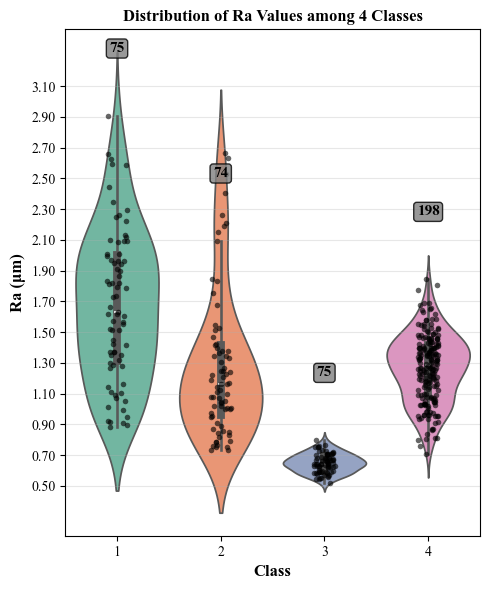

In [ ]:
# Violine Plot for Ra Values by Class

def plot_boxplots(class_1, class_2, class_3, class_4):
    """Box plots showing distribution of Ra values"""
    # Combine all data with class labels
    all_data = pd.concat([class_1, class_2, class_3, class_4])

    # Create parameter combination column
    all_data['Parameters'] = all_data['RPM'].astype(str) + '-' + all_data['Feedspeed_mm_min_'].astype(str)

    # Reset matplotlib to defaults first
    plt.rcdefaults()
    plt.rcParams.update({
            'font.family': 'serif',  # Using serif to match sample
            'font.serif': ['Times New Roman'],})
    # Create violin plot
    plt.figure(figsize=(5, 6))
    ax = sns.violinplot(data=all_data, x='Class', y='Ra', palette='Set2')
    plt.title('Distribution of Ra Values among 4 Classes', fontsize=12, fontweight='bold')
    plt.xlabel('Class', fontsize=12, fontweight='bold')
    plt.ylabel('Ra (μm)', fontsize=12, fontweight='bold')
    #plt.yticks(np.arange(all_data['Ra'].min(), all_data['Ra'].max() + 0.2, 0.2))
    plt.yticks(np.arange(0.5, 3.0 + 0.2, 0.2))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
    plt.grid(True, alpha=0.3)

    # Add mean values as points
    sns.stripplot(data=all_data, x='Class', y='Ra', color='black', size=4, alpha=0.6)

    # Add count labels at the tip of each box (Q3 or upper whisker)
    class_counts = all_data['Class'].value_counts().sort_index()

    # Get box plot statistics for each class
    for i, (class_name, count) in enumerate(class_counts.items()):
        class_data = all_data[all_data['Class'] == class_name]['Ra']

        # Calculate the upper whisker position (1.5 * IQR above Q3)
        q1 = class_data.quantile(0.25)
        q3 = class_data.quantile(0.75)
        iqr = q3 - q1
        upper_whisker = q3 + 1.5 * iqr

        # Use the actual maximum within the whisker range
        whisker_max = min(upper_whisker, class_data.max())

        # Small offset above the whisker tip
        y_offset = (all_data['Ra'].max() - all_data['Ra'].min()) * 0.02

        # Add count label at the whisker tip
        ax.text(i, whisker_max +0.4 + y_offset, f'{count}',
                ha='center', va='center_baseline', fontweight='bold',
                fontsize=11, color='black',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='grey', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":

    print("\n Violine Plot")
    plot_boxplots(class_1, class_2, class_3, class_4)


Selected 96 features between Material_removal_rate and Ra
MULTIVARIATE FEATURE SELECTION RESULTS
Analyzed: 96 features
Selected: 30 top features
Multicollinear pairs: 31

Top 10 Features:
 1. Specific_grinding_energy: 0.3364
 2. Fz_wav_energy: 0.2554
 3. Fz_energy: 0.2080
 4. Fz_dom_freq: 0.1684
 5. Mz_dom_freq: 0.1639
 6. Fz_margin: 0.1572
 7. Fx_wav_energy: 0.1551
 8. ForceRatio_XY: 0.1495
 9. Fz_snr: 0.1467
10. Fz_skew: 0.1442
Selected 96 features between Material_removal_rate and Ra


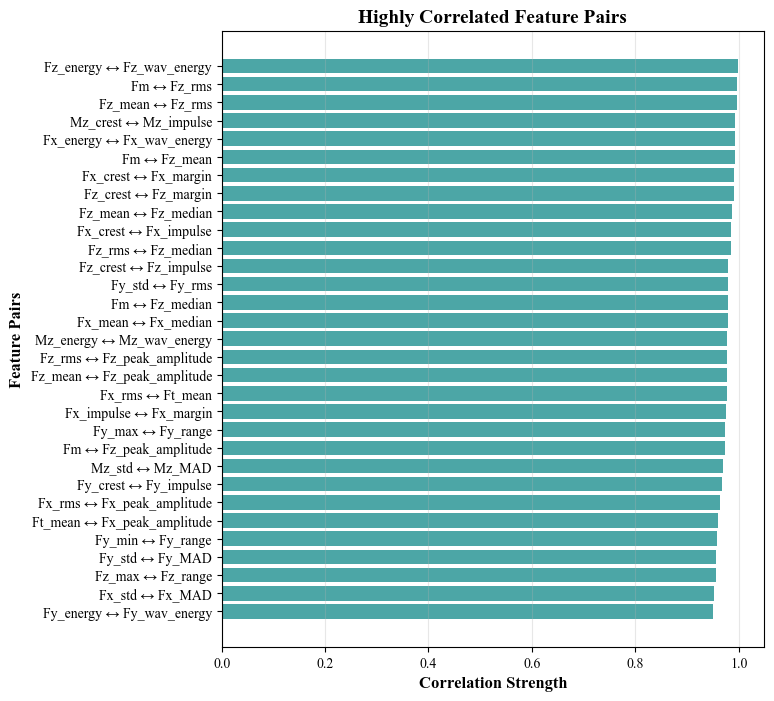


Feature Categories:
RPM_dominant: 10 features
Feedspeed_dominant: 10 features
Ra_predictive: 15 features
Balanced: 19 features

 Top 30 Features (Ready for Modelling):
['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_dom_freq', 'Mz_dom_freq', 'Fz_margin', 'Fx_wav_energy', 'ForceRatio_XY', 'Fz_snr', 'Fz_skew', 'Fz_crest', 'Fy_dom_freq', 'Fx_dom_freq', 'Fz_median', 'Fx_energy', 'Fz_rms', 'Fz_impulse', 'Fz_mean', 'Fz_peak_amplitude', 'Fz_std', 'Fm', 'Fz_max', 'Fz_temp_variability', 'Fx_temp_variability', 'Fz_num_peaks', 'spatial_variability', 'Mz_num_peaks', 'Fy_thd', 'Fx_crest', 'Mz_snr']


In [ ]:
# MULTIVARIATE FEATURE SELECTION PIPELINE
# Efficient analysis of F-features with RPM, Feedspeed, Ra dependencies

class MultivariateFeatureSelector:

    def __init__(self,df, target_features=['RPM', 'Feedspeed_mm_min_', 'Ra']):
        """
        Initialize with features between MaterialRemovedRate and Ra (Excel columns H to DM = 110 features)
        """
        self.target_features = target_features
        self.results = {}

        if df is not None:
            # Get all columns between MaterialRemovedRate and Ra
            all_columns = df.columns.tolist()

            try:
                start_idx = all_columns.index('Material_removal_rate') + 1  # Start after MaterialRemovedRate
                end_idx = all_columns.index('Ra')  # End before Ra
                self.f_features = all_columns[start_idx:end_idx]  # Extract 110 features between H-DM

                print(f"Selected {len(self.f_features)} features between Material_removal_rate and Ra")

            except ValueError as e:
                print(f"Column not found: {e}")
                self.f_features = []
        else:
            print("Warning: No dataframe provided")
            self.f_features = []

    def mutual_information_analysis(self, X, y_dict):
        """Compute mutual information for all targets"""
        mi_results = {}
        for target, y in y_dict.items():
            mi_scores = mutual_info_regression(X, y, random_state=42)
            mi_results[target] = pd.Series(mi_scores, index=X.columns)
        return mi_results

    def partial_correlation_analysis(self, df, control_vars=['RPM', 'Feedspeed_mm_min_']):
        """Compute partial correlations controlling for process parameters"""
        from sklearn.linear_model import LinearRegression

        partial_corr_results = {}
        y_ra = df['Ra'].values
        X_control = df[control_vars].values

        # Remove control variable effects from Ra
        reg_ra = LinearRegression().fit(X_control, y_ra)
        ra_residuals = y_ra - reg_ra.predict(X_control)

        for feature in self.f_features:
            if feature in df.columns:
                y_feature = df[feature].values

                # Remove control variable effects from feature
                reg_feature = LinearRegression().fit(X_control, y_feature)
                feature_residuals = y_feature - reg_feature.predict(X_control)

                # Correlation between residuals
                corr, p_value = pearsonr(feature_residuals, ra_residuals)
                partial_corr_results[feature] = {'correlation': corr, 'p_value': p_value}

        return pd.DataFrame(partial_corr_results).T

    def lasso_selection(self, X, y, cv=5):
        """LASSO feature selection with cross-validation"""
        lasso = LassoCV(cv=cv, random_state=42, max_iter=1000)
        lasso.fit(X, y)

        feature_importance = pd.Series(np.abs(lasso.coef_), index=X.columns)
        selected_features = feature_importance[feature_importance > 0].index.tolist()

        return {
            'importance': feature_importance,
            'selected': selected_features,
            'alpha': lasso.alpha_,
            'score': lasso.score(X, y)
        }

    def random_forest_importance(self, X, y):
        """Random Forest feature importance with permutation"""
        rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
        rf.fit(X, y)

        # Permutation importance
        perm_importance = permutation_importance(rf, X, y, n_repeats=5, random_state=42)

        return {
            'rf_importance': pd.Series(rf.feature_importances_, index=X.columns),
            'perm_importance': pd.Series(perm_importance.importances_mean, index=X.columns),
            'perm_std': pd.Series(perm_importance.importances_std, index=X.columns)
        }

    def correlation_matrix_analysis(self, df):
        """Analyze correlation patterns"""
        f_data = df[self.f_features]
        target_data = df[self.target_features]

        # F-feature correlations with targets
        correlations = {}
        for target in self.target_features:
            correlations[target] = f_data.corrwith(df[target])

        # Inter F-feature correlations
        f_corr_matrix = f_data.corr()

        return {
            'target_correlations': pd.DataFrame(correlations),
            'f_feature_correlations': f_corr_matrix
        }

    def detect_multicollinearity(self, X, threshold=0.95):
        """Detect highly correlated feature pairs"""
        corr_matrix = X.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        high_corr_pairs = []
        for column in upper_triangle.columns:
            high_corr_features = upper_triangle.index[upper_triangle[column] > threshold].tolist()
            for feature in high_corr_features:
                high_corr_pairs.append((feature, column, upper_triangle.loc[feature, column]))

        return high_corr_pairs

    def comprehensive_selection(self, df, top_k=30):
        """Complete feature selection pipeline"""
        X_f = df[self.f_features]

        y_dict = {target: df[target] for target in self.target_features}

        # 1. Mutual Information Analysis
        mi_results = self.mutual_information_analysis(X_f, y_dict)

        # 2. Partial Correlation (Ra only)
        partial_corr = self.partial_correlation_analysis(df)

        # 3. Correlation Analysis
        corr_results = self.correlation_matrix_analysis(df)

        # 4. Random Forest Analysis (Ra prediction)
        rf_results = self.random_forest_importance(X_f, df['Ra'])

        # 5. LASSO Selection (Ra prediction)
        lasso_results = self.lasso_selection(X_f, df['Ra'])

        # 6. Multicollinearity Detection
        high_corr_pairs = self.detect_multicollinearity(X_f)

        '''
        print("high_corr_pairs:", high_corr_pairs[:5])  # Prints the
        print("Type:", type(high_corr_pairs))
        '''

        # Combine results for ranking
        ranking_df = pd.DataFrame(index=self.f_features)

        # Add all scores
        ranking_df['MI_RPM'] = mi_results['RPM'].reindex(self.f_features, fill_value=0)
        ranking_df['MI_Feedspeed'] = mi_results['Feedspeed_mm_min_'].reindex(self.f_features, fill_value=0)
        ranking_df['MI_Ra'] = mi_results['Ra'].reindex(self.f_features, fill_value=0)
        ranking_df['Partial_Corr_Ra'] = partial_corr['correlation'].reindex(self.f_features, fill_value=0)
        ranking_df['RF_Importance'] = rf_results['rf_importance'].reindex(self.f_features, fill_value=0)
        ranking_df['Perm_Importance'] = rf_results['perm_importance'].reindex(self.f_features, fill_value=0)
        ranking_df['LASSO_Importance'] = lasso_results['importance'].reindex(self.f_features, fill_value=0)
        ranking_df['Corr_Ra'] = corr_results['target_correlations']['Ra'].reindex(self.f_features, fill_value=0)

        # Create composite scores
        ranking_df['MI_Composite'] = (ranking_df['MI_RPM'] + ranking_df['MI_Feedspeed'] + ranking_df['MI_Ra']) / 3
        ranking_df['Overall_Score'] = (
            0.25 * ranking_df['MI_Composite'] +
            0.20 * np.abs(ranking_df['Partial_Corr_Ra']) +
            0.20 * ranking_df['RF_Importance'] +
            0.20 * ranking_df['Perm_Importance'] +
            0.15 * ranking_df['LASSO_Importance']
        )

        # Rank features
        ranking_df = ranking_df.sort_values('Overall_Score', ascending=False)
        top_features = ranking_df.head(top_k).index.tolist()

        # Store results
        self.results = {
            'ranking': ranking_df,
            'top_features': top_features,
            'mi_results': mi_results,
            'partial_correlation': partial_corr,
            'correlation_analysis': corr_results,
            'rf_results': rf_results,
            'lasso_results': lasso_results,
            'multicollinearity': high_corr_pairs,
            'summary': self._create_summary(ranking_df, top_features, high_corr_pairs)
        }

        return self.results

    def _create_summary(self, ranking_df, top_features, high_corr_pairs):
        """Create analysis summary"""
        return {
            'total_features_analyzed': len(self.f_features),
            'top_features_selected': len(top_features),
            'high_correlation_pairs': len(high_corr_pairs),
            'top_10_features': top_features[:10],
            'score_range': {
                'max': ranking_df['Overall_Score'].max(),
                'min': ranking_df['Overall_Score'].min(),
                'mean': ranking_df['Overall_Score'].mean()
            }
        }

    def get_feature_categories(self):
        """Categorize features by their dominant relationships"""
        if not self.results:
            return "Run comprehensive_selection first"

        ranking = self.results['ranking']
        categories = {}

        # RPM-dominant features
        rpm_dominant = ranking[ranking['MI_RPM'] > ranking[['MI_Feedspeed', 'MI_Ra']].max(axis=1)].head(10)
        categories['RPM_dominant'] = rpm_dominant.index.tolist()

        # Feedspeed-dominant features
        feedspeed_dominant = ranking[ranking['MI_Feedspeed'] > ranking[['MI_RPM', 'MI_Ra']].max(axis=1)].head(10)
        categories['Feedspeed_dominant'] = feedspeed_dominant.index.tolist()

        # Ra-predictive features
        ra_predictive = ranking.nlargest(15, 'MI_Ra')
        categories['Ra_predictive'] = ra_predictive.index.tolist()

        # Balanced features (high in multiple categories)
        balanced = ranking[ranking['MI_Composite'] > ranking['MI_Composite'].quantile(0.8)]
        categories['Balanced'] = balanced.index.tolist()

        return categories

    def plot_multicollinearity(self, df):
        """
        Plot correlation strength of highly correlated feature pairs.
        pairs: list of tuples (feature1, feature2, correlation)
        """
        X_f = df[self.f_features]

        high_corr_pairs = self.detect_multicollinearity(X_f)

        if not high_corr_pairs:
            print("No highly correlated pairs found.")
            return

        # Clean and convert to DataFrame
        cleaned_pairs = [(f1, f2, float(corr)) for f1, f2, corr in high_corr_pairs]
        corr_df = pd.DataFrame(cleaned_pairs, columns=["Feature1", "Feature2", "Correlation"])  # Changed name

        # Create label like "Feature1 ↔ Feature2"
        corr_df["Pair"] = corr_df["Feature1"] + " ↔ " + corr_df["Feature2"]

        # Sort by correlation strength
        corr_df = corr_df.sort_values("Correlation", ascending=False)

        # Plot
        plt.figure(figsize=(7, 8))
        plt.barh(corr_df["Pair"], corr_df["Correlation"], color="teal", alpha=0.7)
        plt.xlabel("Correlation Strength", fontsize=12, fontweight="bold")
        plt.ylabel("Feature Pairs", fontsize=12, fontweight="bold")
        plt.title("Highly Correlated Feature Pairs", fontsize=14, fontweight="bold")
        plt.gca().invert_yaxis()  # Highest correlation on top
        plt.grid(axis="x", alpha=0.3)
        plt.show()


# Usage Pipeline
def run_feature_selection_pipeline(df, top_k=30):
    """Main pipeline execution"""

    selector = MultivariateFeatureSelector(df)
    results = selector.comprehensive_selection(df, top_k=top_k)

    print("="*50)
    print("MULTIVARIATE FEATURE SELECTION RESULTS")
    print("="*50)

    # Summary
    summary = results['summary']
    print(f"Analyzed: {summary['total_features_analyzed']} features")
    print(f"Selected: {summary['top_features_selected']} top features")
    print(f"Multicollinear pairs: {summary['high_correlation_pairs']}")

    # Top features
    print(f"\nTop 10 Features:")
    for i, feature in enumerate(summary['top_10_features'], 1):
        score = results['ranking'].loc[feature, 'Overall_Score']
        print(f"{i:2d}. {feature}: {score:.4f}")

    fs = MultivariateFeatureSelector(df)

    # Step 1: Detect and plot multicollinearity
    fs.plot_multicollinearity(df)


    # Feature categories
    categories = selector.get_feature_categories()
    print(f"\nFeature Categories:")
    for category, features in categories.items():
        print(f"{category}: {len(features)} features")

    return {
        'selector': selector,
        'results': results,
        'categories': categories,
        'selected_features': results['top_features']
    }

# Execute pipeline
pipeline_results = run_feature_selection_pipeline(df, top_k=30)

# Access results
selected_features = pipeline_results['selected_features']
feature_ranking = pipeline_results['results']['ranking']
feature_categories = pipeline_results['categories']



# Get top 30 features in list format
top_30_features = pipeline_results['results']['ranking'].head(30).index.tolist()

print("\n Top 30 Features (Ready for Modelling):")
print(top_30_features)

In [ ]:
# Removing few data points where Ra is >= 2.7
df = df[df['Ra'] <= 2.7]

COMPLETE XGBOOST ANALYSIS PIPELINE
ENHANCED XGBOOST PIPELINE WITH BAYESIAN OPTIMIZATION

1. CLASS IMBALANCE ANALYSIS
--------------------------------------------------
CLASS IMBALANCE ANALYSIS

Sample distribution by class:
Class 1: 74 samples (17.6%)
Class 2: 74 samples (17.6%)
Class 3: 75 samples (17.8%)
Class 4: 198 samples (47.0%)

Ra statistics by class:
       count      mean       std    min    max
Class                                         
1         74  1.660419  0.471569  0.883  2.660
2         74  1.281554  0.482589  0.734  2.668
3         75  0.649533  0.061356  0.516  0.797
4        198  1.266712  0.222928  0.710  1.844


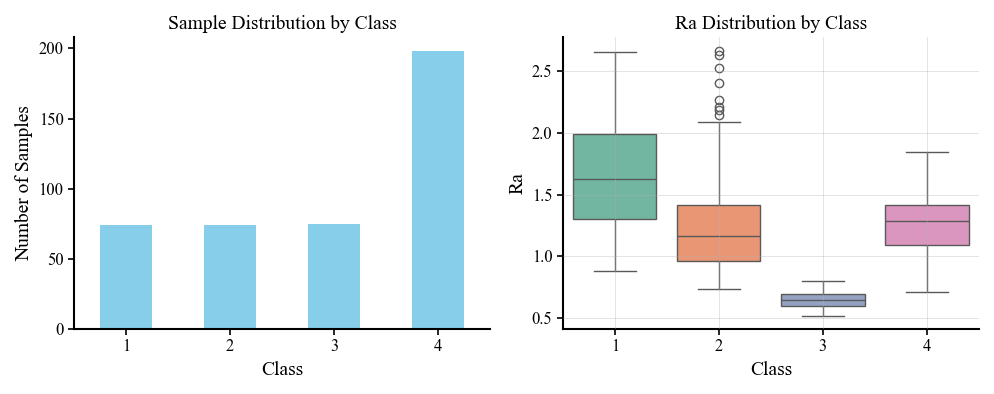


2. DATA SPLITTING
--------------------------------------------------
Creating balanced RPM chunks...
Chunk 0: 85 samples (45 concentrated, 40 scattered)
Chunk 1: 84 samples (45 concentrated, 39 scattered)
Chunk 2: 84 samples (45 concentrated, 39 scattered)
Chunk 3: 84 samples (44 concentrated, 40 scattered)
Chunk 4: 84 samples (44 concentrated, 40 scattered)

Creating balanced Feedspeed chunks...
Chunk 0: 85 samples (45 concentrated, 40 scattered)
Chunk 1: 84 samples (45 concentrated, 39 scattered)
Chunk 2: 84 samples (45 concentrated, 39 scattered)
Chunk 3: 84 samples (45 concentrated, 39 scattered)
Chunk 4: 84 samples (44 concentrated, 40 scattered)

Splitting each RPM-Feedspeed combination with ratio 0.8:0.1:0.1

Final Split Summary:
Training set: 339 samples (80.5%)
Validation set: 41 samples (9.7%)
Test set: 41 samples (9.7%)

Using 34 features for training

3. SAMPLE WEIGHTING FOR IMBALANCE
--------------------------------------------------
Applied sample weights. Weight range: 

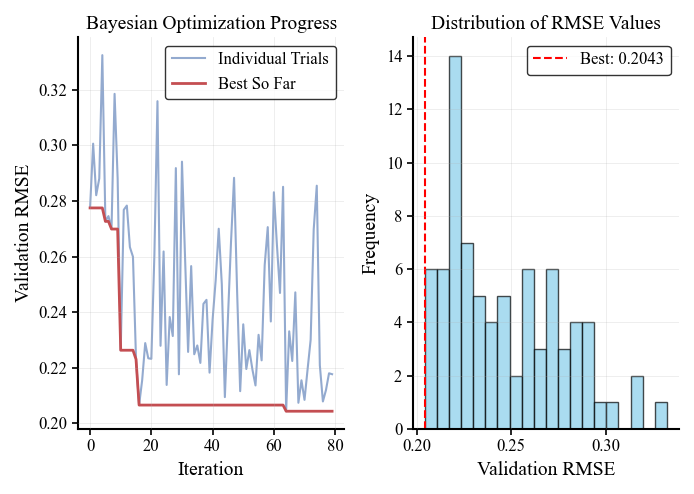


5. FINAL MODEL TRAINING
--------------------------------------------------

6. MODEL EVALUATION
--------------------------------------------------

Training Set Metrics:
R²: 0.8899
RMSE: 0.1472
MAE: 0.1105
MAPE: 9.62%

Validation Set Metrics:
R²: 0.8146
RMSE: 0.2109
MAE: 0.1317
MAPE: 9.70%

Test Set Metrics:
R²: 0.7976
RMSE: 0.1716
MAE: 0.1385
MAPE: 12.10%

7. PERFORMANCE VISUALIZATION
--------------------------------------------------


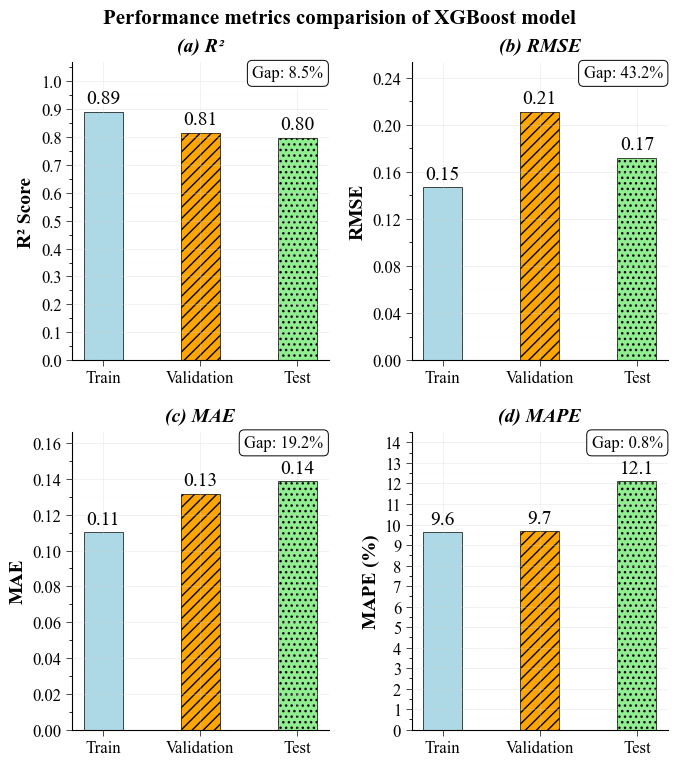

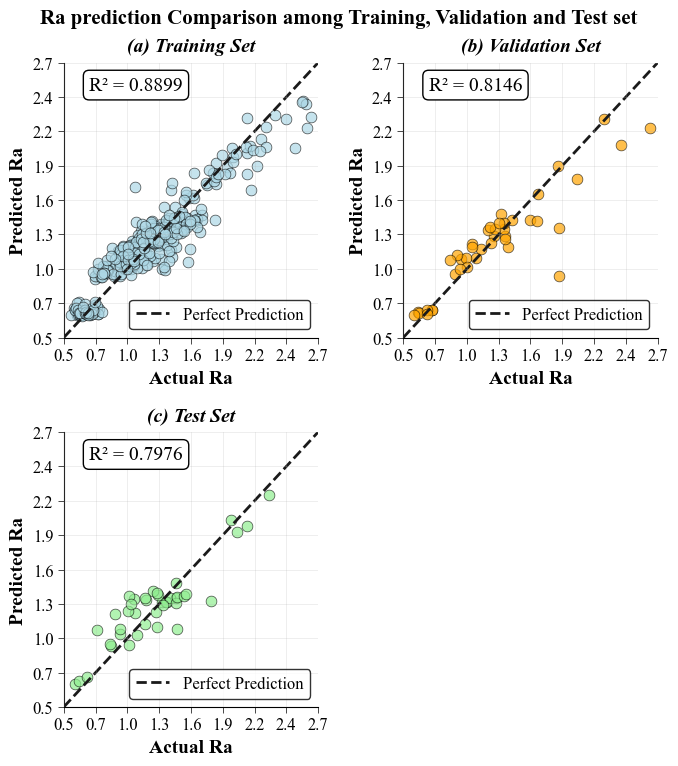


8. FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------

9. FINAL SUMMARY
--------------------------------------------------
Best Validation RMSE from Bayesian Optimization: 0.2043
Final Test Set Performance:
  R²: 0.7976
  RMSE: 0.1716
  MAE: 0.1385
  MAPE: 12.10%

Overfitting Analysis:
  Train-Validation R² Gap: 8.5%
  ✅ Model appears well-generalized

CROSS-VALIDATION STABILITY ANALYSIS

3-Fold Cross-Validation Results:
Fold   RMSE       MAE        R²         MAPE (%)  
--------------------------------------------------------------------------------
1      0.2317     0.1699     0.7643     13.03     
2      0.2085     0.1492     0.7179     13.51     
3      0.1712     0.1338     0.8489     12.14     

SUMMARY STATISTICS:
--------------------------------------------------
Metric     Mean       Std        Min        Max       
--------------------------------------------------
RMSE       0.2038     0.0249     0.1712     0.2317    
MAE        0.1510     0.0148

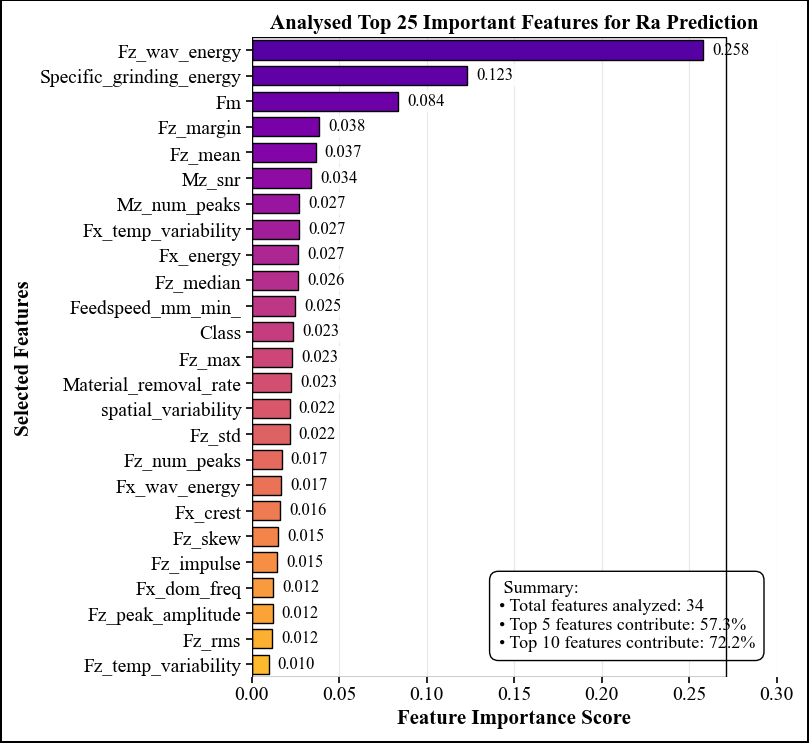

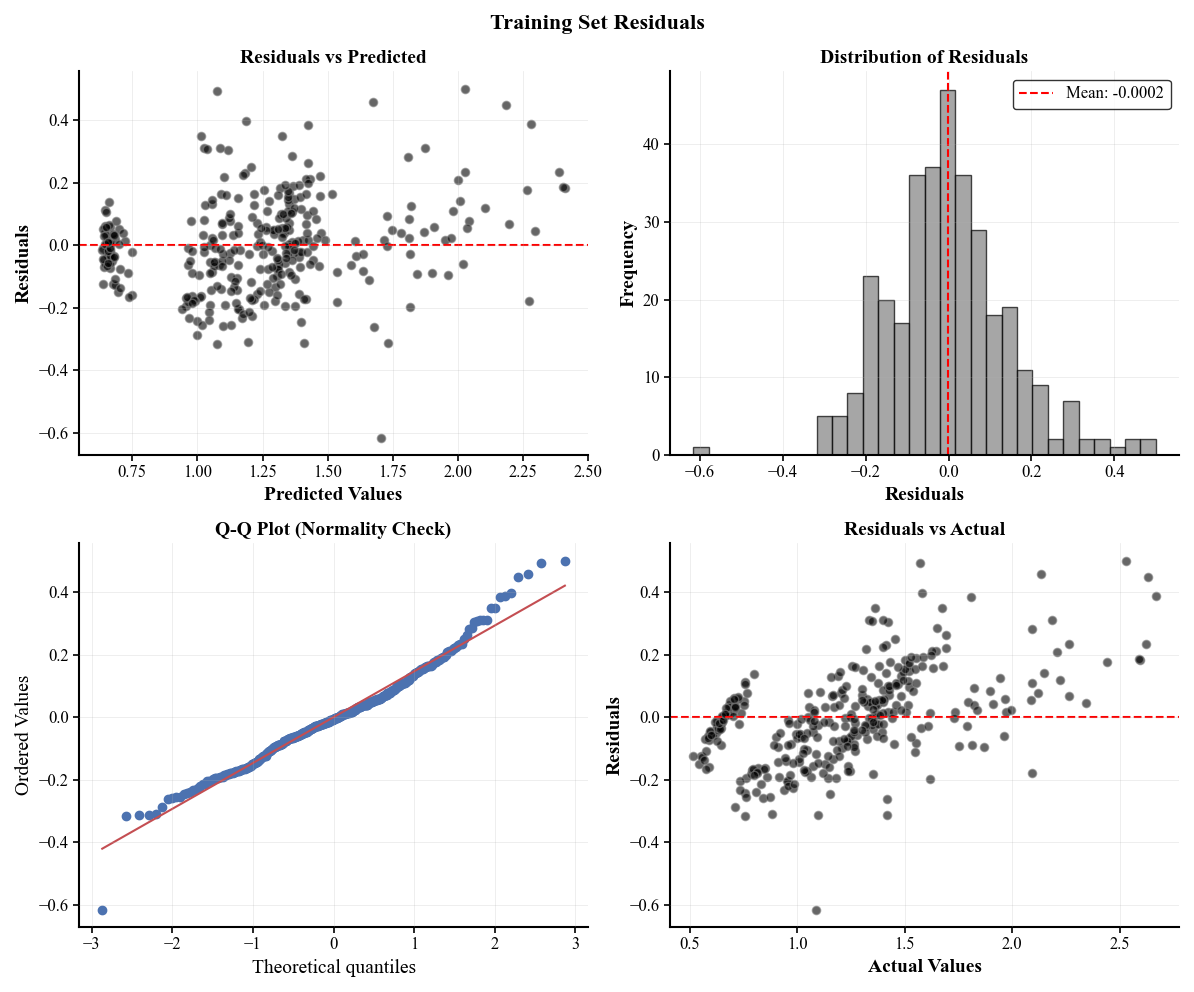


Residual Statistics:
Mean: -0.000189
Std: 0.1472
Min: -0.6155
Max: 0.4999
25th percentile: -0.0880
75th percentile: 0.0764

Shapiro-Wilk Normality Test:
Statistic: 0.9781, p-value: 0.000049
⚠️ Residuals may not be normally distributed


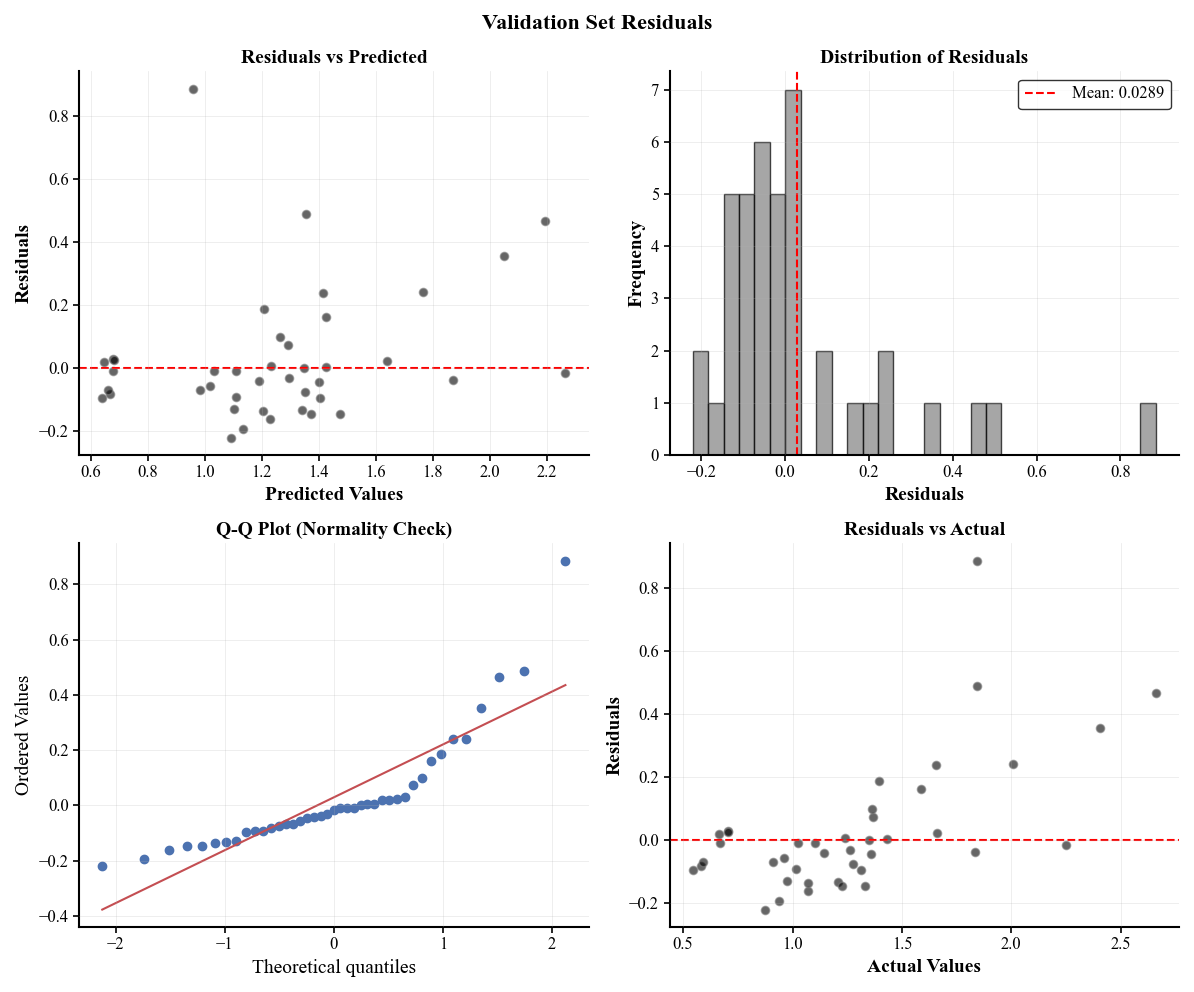


Residual Statistics:
Mean: 0.028908
Std: 0.2089
Min: -0.2209
Max: 0.8849
25th percentile: -0.0936
75th percentile: 0.0292

Shapiro-Wilk Normality Test:
Statistic: 0.7821, p-value: 0.000002
⚠️ Residuals may not be normally distributed


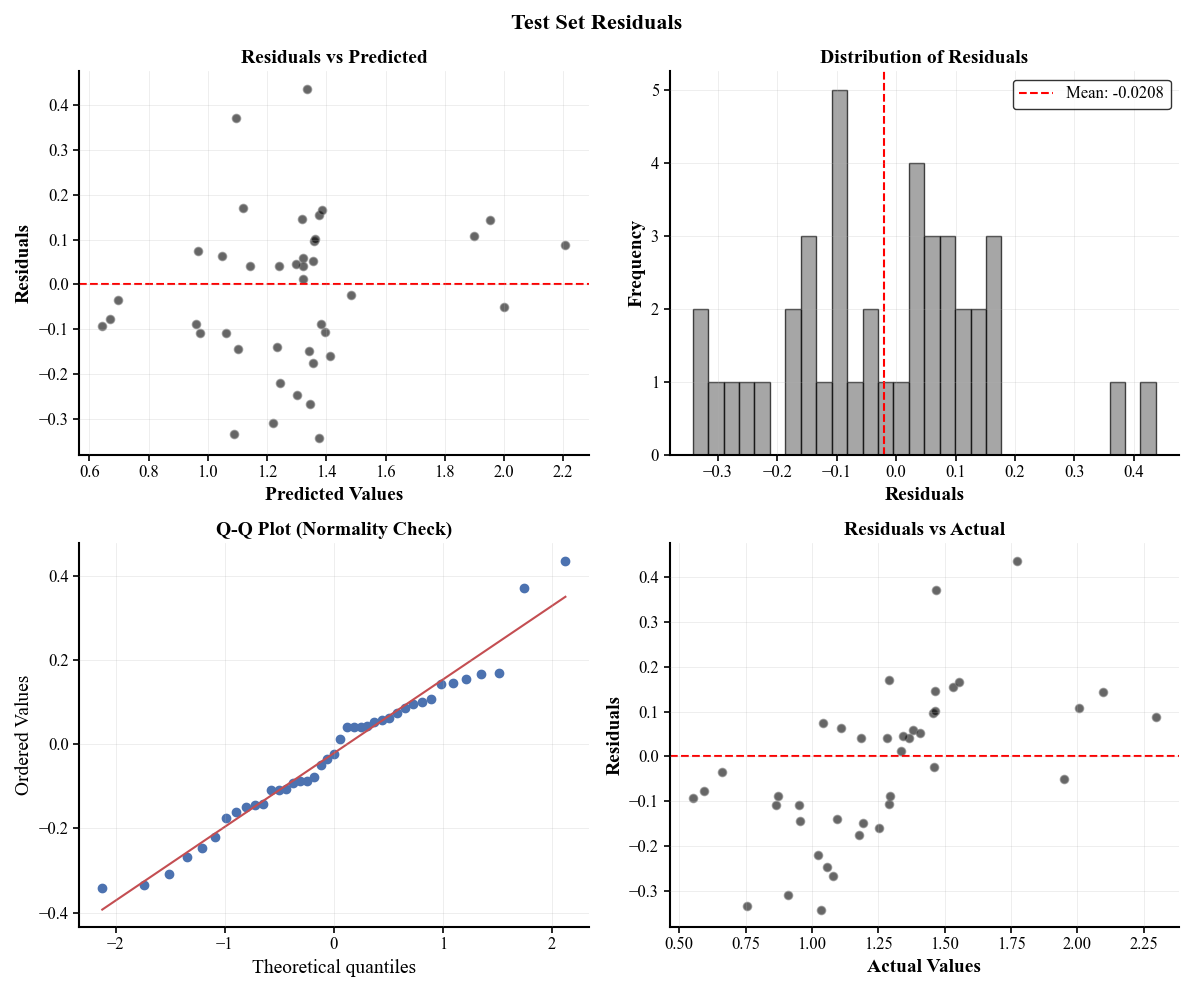


Residual Statistics:
Mean: -0.020833
Std: 0.1703
Min: -0.3423
Max: 0.4370
25th percentile: -0.1408
75th percentile: 0.0875

Shapiro-Wilk Normality Test:
Statistic: 0.9709, p-value: 0.369985
✅ Residuals appear to be normally distributed

LEARNING CURVE ANALYSIS


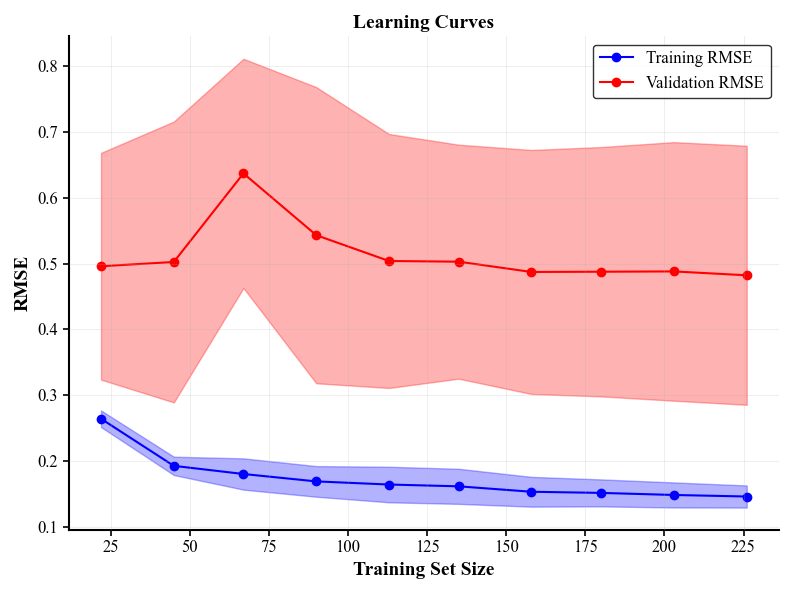

Final train-validation gap: 0.3361
Gap trend (negative means converging): 0.1044
⚠️ Train-validation gap is diverging - potential overfitting

FINAL COMPREHENSIVE REPORT

📊 MODEL PERFORMANCE SUMMARY:
   Test R²: 0.7976
   Test RMSE: 0.1716
   Test MAE: 0.1385
   Test MAPE: 12.10%

🔄 CROSS-VALIDATION STABILITY:
   CV Mean RMSE: 0.2038 ± 0.0249
   CV Coefficient of Variation: 0.122

⚖️ OVERFITTING ASSESSMENT:
   Train-Val R² Gap: 8.5%
   Status: ✅ Good generalization


In [ ]:
# -----------------------------------------------XGBoost-------------------------------------------------------------


def create_balanced_chunks(df_subset, values_col, n_chunks=5, concentrated_values=None):
    """
    Creating balanced chunks ensuring equal representation of concentrated and scattered values
    using the original DataFrame indices.
    """
    df_temp = df_subset[[values_col]].copy()

    # Identify concentrated vs scattered samples based on the original index
    if concentrated_values is not None:
        concentrated_mask = df_temp[values_col].isin(concentrated_values)
        concentrated_indices = df_temp.index[concentrated_mask].tolist()
        scattered_indices = df_temp.index[~concentrated_mask].tolist()
    else:
        concentrated_indices = []
        scattered_indices = df_temp.index.tolist()

    # Sort scattered values by the value itself, but keep original indices
    scattered_df = df_temp.loc[scattered_indices].sort_values(values_col)
    scattered_indices_sorted = scattered_df.index.tolist()

    # Calculate target size per chunk
    total_samples = len(df_subset)
    target_per_chunk = total_samples // n_chunks
    remainder = total_samples % n_chunks

    # Distribute concentrated samples evenly across chunks
    concentrated_per_chunk = len(concentrated_indices) // n_chunks
    concentrated_remainder = len(concentrated_indices) % n_chunks

    chunks = {}
    concentrated_start = 0
    scattered_start = 0

    for chunk_id in range(n_chunks):
        chunks[chunk_id] = []

        # Add concentrated samples to this chunk using original indices
        concentrated_end = concentrated_start + concentrated_per_chunk
        if chunk_id < concentrated_remainder:
            concentrated_end += 1

        chunk_concentrated = concentrated_indices[concentrated_start:concentrated_end]
        chunks[chunk_id].extend(chunk_concentrated)
        concentrated_start = concentrated_end

        # Calculate remaining space in chunk
        current_chunk_size = len(chunks[chunk_id])
        chunk_target = target_per_chunk + (1 if chunk_id < remainder else 0)
        scattered_needed = chunk_target - current_chunk_size

        # Add scattered samples to fill the chunk using sorted original indices
        scattered_end = scattered_start + scattered_needed
        chunk_scattered = scattered_indices_sorted[scattered_start:scattered_end]  # Fixed typo
        chunks[chunk_id].extend(chunk_scattered)
        scattered_start = scattered_end

        print(f"Chunk {chunk_id}: {len(chunks[chunk_id])} samples "
              f"({len(chunk_concentrated)} concentrated, {len(chunk_scattered)} scattered)")

    return chunks

def custom_train_val_test_split(df, target_col='Ra', rpm_col='RPM', feedspeed_col='Feedspeed_mm_min_',
                               train_ratio=0.7, val_ratio=0.2, test_ratio=0.1,
                               n_rpm_chunks=5, n_feedspeed_chunks=5):
    """
    Create stratified train/val/test split ensuring representation from all RPM-Feedspeed combinations
    """
    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
        raise ValueError("Split ratios must sum to 1.0")

    # Define concentrated values
    concentrated_rpm = [6000, 8000, 10000, 12000, 14000]
    concentrated_feedspeed = [150, 250, 350, 450, 550]

    print("Creating balanced RPM chunks...")
    rpm_chunks = create_balanced_chunks(df, rpm_col, n_rpm_chunks, concentrated_rpm)

    print("\nCreating balanced Feedspeed chunks...")
    feedspeed_chunks = create_balanced_chunks(df, feedspeed_col, n_feedspeed_chunks, concentrated_feedspeed)

    # Create RPM-Feedspeed grid combinations using the chunk assignments
    df_copy = df.copy()
    df_copy['rpm_chunk'] = -1
    df_copy['feedspeed_chunk'] = -1

    # Assign chunk labels based on the indices returned by create_balanced_chunks
    for chunk_id, indices in rpm_chunks.items():
        df_copy.loc[indices, 'rpm_chunk'] = chunk_id

    for chunk_id, indices in feedspeed_chunks.items():
        df_copy.loc[indices, 'feedspeed_chunk'] = chunk_id

    # Create combined chunk identifier
    df_copy['combined_chunk'] = df_copy['rpm_chunk'].astype(str) + '_' + df_copy['feedspeed_chunk'].astype(str)

    # Split each combined chunk proportionally
    train_indices = []
    val_indices = []
    test_indices = []
    chunk_info = []

    print(f"\nSplitting each RPM-Feedspeed combination with ratio {train_ratio:.1f}:{val_ratio:.1f}:{test_ratio:.1f}")

    for combined_chunk in df_copy['combined_chunk'].unique():
        chunk_data = df_copy[df_copy['combined_chunk'] == combined_chunk]
        chunk_indices = chunk_data.index.tolist()

        if len(chunk_indices) == 0:
            continue

        rpm_chunk = chunk_data['rpm_chunk'].iloc[0]
        feedspeed_chunk = chunk_data['feedspeed_chunk'].iloc[0]

        # Handle cases with very few samples
        if len(chunk_indices) == 1:
            train_indices.extend(chunk_indices)
            chunk_train, chunk_val, chunk_test = 1, 0, 0
        elif len(chunk_indices) == 2:
            train_indices.extend(chunk_indices[:1])
            val_indices.extend(chunk_indices[1:])
            chunk_train, chunk_val, chunk_test = 1, 1, 0
        else:
            # Split larger chunks proportionally
            if test_ratio > 0:
                train_val_indices, test_chunk_indices = train_test_split(
                    chunk_indices, test_size=test_ratio, random_state=42
                )
                test_indices.extend(test_chunk_indices)
                chunk_test = len(test_chunk_indices)
            else:
                train_val_indices = chunk_indices
                chunk_test = 0

            if val_ratio > 0 and len(train_val_indices) > 1:
                val_size = val_ratio / (train_ratio + val_ratio)
                train_chunk_indices, val_chunk_indices = train_test_split(
                    train_val_indices, test_size=val_size, random_state=42
                )
                train_indices.extend(train_chunk_indices)
                val_indices.extend(val_chunk_indices)
                chunk_train = len(train_chunk_indices)
                chunk_val = len(val_chunk_indices)
            else:
                train_indices.extend(train_val_indices)
                chunk_train = len(train_val_indices)
                chunk_val = 0

        chunk_info.append({
            'RPM_Chunk': rpm_chunk,
            'Feedspeed_Chunk': feedspeed_chunk,
            'Combined_Chunk': combined_chunk,
            'Total_Samples': len(chunk_indices),
            'Train_Samples': chunk_train,
            'Val_Samples': chunk_val,
            'Test_Samples': chunk_test
        })

    # Create final datasets using the collected indices
    train_df = df.loc[train_indices].copy()
    val_df = df.loc[val_indices].copy()
    test_df = df.loc[test_indices].copy()

    # Separate features and target
    feature_cols = [col for col in df.columns if col != target_col]

    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_val = val_df[feature_cols]
    y_val = val_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    # Print summary
    print(f"\nFinal Split Summary:")
    print(f"Training set: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
    print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")
    print(f"Test set: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")

    # Store split info for analysis
    split_info = {
        'train_df': train_df,
        'val_df': val_df,
        'test_df': test_df,
        'chunk_info': pd.DataFrame(chunk_info)
    }

    return X_train, X_val, X_test, y_train, y_val, y_test, split_info

def analyze_class_imbalance(df, class_col='Class', target_col='Ra'):
    """
    Analyze class distribution and Ra value distribution per class
    """
    print("="*60)
    print("CLASS IMBALANCE ANALYSIS")
    print("="*60)

    # Class distribution
    class_dist = df[class_col].value_counts().sort_index()
    print("\nSample distribution by class:")
    for class_val, count in class_dist.items():
        percentage = count / len(df) * 100
        print(f"Class {class_val}: {count} samples ({percentage:.1f}%)")

    # Ra statistics per class
    print(f"\n{target_col} statistics by class:")
    ra_stats = df.groupby(class_col)[target_col].agg(['count', 'mean', 'std', 'min', 'max'])
    print(ra_stats)

    # Plot class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Class sample counts
    class_dist.plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Sample Distribution by Class')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=0)

    # Ra distribution by class
    sns.boxplot(x=class_col, y=target_col, data=df, ax=ax2, palette="Set2")
    ax2.set_title(f'{target_col} Distribution by Class')
    ax2.grid(True)
    ax2.set_xlabel('Class')
    ax2.set_ylabel(target_col)

    plt.tight_layout()
    plt.show()

    return class_dist, ra_stats

def bayesian_xgboost_optimization(X_train, y_train, X_val, y_val, n_calls=100):
    """
    Bayesian optimization for XGBoost hyperparameters using scikit-optimize
    """
    print("="*60)
    print("BAYESIAN HYPERPARAMETER OPTIMIZATION")
    print("="*60)

    # Convert to numpy arrays
    X_train_np = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
    y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
    X_val_np = X_val.to_numpy() if isinstance(X_val, pd.DataFrame) else X_val
    y_val_np = y_val.to_numpy() if isinstance(y_val, pd.Series) else y_val

    # Define search space
    space = [
        Integer(40,1200, name='n_estimators'),
        Integer(1, 3, name='max_depth'),
        Real(0.03, 0.3, name='learning_rate', prior='log-uniform'),
        Real(0.4, 0.8, name='subsample'),
        Real(0.4, 1.0, name='colsample_bytree'),
        Integer(2, 5, name='min_child_weight'),
        Real(0.1, 1.0, name='gamma'),
        Real(1.0, 4.0, name='reg_alpha'),
        Real(2.0, 5.0, name='reg_lambda'),

    ]

    # Store results
    eval_results = []

    @use_named_args(space)
    def objective(**params):
        # Create model with current parameters
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1,
            verbosity=0,
            **params
        )

        # Fit model
        model.fit(X_train_np, y_train_np)

        # Predict on validation set
        y_pred = model.predict(X_val_np)

        # Calculate RMSE (minimize)
        rmse = np.sqrt(mean_squared_error(y_val_np, y_pred))

        # Store results for analysis
        eval_results.append({
            'params': params.copy(),
            'rmse': rmse,
            'iteration': len(eval_results)
        })

        if len(eval_results) % 10 == 0:
            print(f"Iteration {len(eval_results)}: RMSE = {rmse:.4f}")

        return rmse

    print(f"Starting Bayesian optimization with {n_calls} iterations...")

    # Run optimization
    result = gp_minimize(
        func=objective,
        dimensions=space,
        n_calls=n_calls,
        n_initial_points=10,
        acq_func='EI',  # Changed from acquisition_func to acq_func
        random_state=42,
        verbose=False
    )

    # Extract best parameters
    best_params = dict(zip([dim.name for dim in space], result.x))
    best_rmse = result.fun

    print(f"\nOptimization completed!")
    print(f"Best RMSE: {best_rmse:.4f}")
    print(f"Best parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    return best_params, best_rmse, eval_results

def plot_optimization_progress(eval_results):
    """
    Plot the optimization progress
    """
    # Handle both eval_results list and Optuna Study object
    if hasattr(eval_results, 'trials'):
        # It's an Optuna Study object
        trials = eval_results.trials
        iterations = list(range(1, len(trials) + 1))
        rmse_values = [trial.value for trial in trials]
    else:
        # It's a list of results
        iterations = [r['iteration'] for r in eval_results]
        rmse_values = [r['rmse'] for r in eval_results]

    # Calculate cumulative best
    cumulative_best = []
    best_so_far = float('inf')
    for rmse in rmse_values:
        if rmse < best_so_far:
            best_so_far = rmse
        cumulative_best.append(best_so_far)

    plt.figure(figsize=(7, 5))

    plt.subplot(1, 2, 1)
    plt.plot(iterations, rmse_values, 'b-', alpha=0.6, label='Individual Trials')
    plt.plot(iterations, cumulative_best, 'r-', linewidth=2, label='Best So Far')
    plt.xlabel('Iteration')
    plt.ylabel('Validation RMSE')
    plt.title('Bayesian Optimization Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(rmse_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(min(rmse_values), color='red', linestyle='--', label=f'Best: {min(rmse_values):.4f}')
    plt.xlabel('Validation RMSE')
    plt.ylabel('Frequency')
    plt.title('Distribution of RMSE Values')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X, y, set_name="Test"):
    """
    Evaluate model and return all core metrics
    """
    # Convert to numpy arrays if needed
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()

    y_pred = model.predict(X)

    # Calculate all metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    # Calculate MAPE with protection against division by zero
    mape = np.mean(np.abs((y - y_pred) / np.maximum(1e-10, np.abs(y)))) * 100

    print(f"\n{set_name} Set Metrics:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return {'R2': r2, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'predictions': y_pred}

def plot_training_validation_comparison(train_metrics, val_metrics, test_metrics=None):
    """
    Plot training vs validation performance comparison with improved styling
    """
    # Reset matplotlib to defaults first
    plt.rcdefaults()

    # Scientific publication font settings - keeping original sizes
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 14,  # Increased back to match original
        'axes.titlesize': 14,  # Match original
        'axes.labelsize': 14,  # Match original
        'xtick.labelsize': 14,  # Match original
        'ytick.labelsize': 14,  # Match original
        'legend.fontsize': 12,
        'figure.titlesize': 14,  # Match original title size
        'text.usetex': False,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'grid.alpha': 0.5,
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'xtick.direction': 'out',
        'ytick.direction': 'out',
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.axisbelow': False,  # Grid on top of bars
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'savefig.dpi': 500,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1,
        'savefig.facecolor': 'white',
        'savefig.edgecolor': 'none',
        'text.color': 'black',
        'axes.labelcolor': 'black',
        'axes.edgecolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'legend.edgecolor': 'black',
        'legend.facecolor': 'white',
    })

    metrics = ['R2', 'RMSE', 'MAE', 'MAPE']
    titles = ['(a) R²', '(b) RMSE', '(c) MAE', '(d) MAPE']
    y_labels = ['R² Score', 'RMSE', 'MAE', 'MAPE (%)']

    train_values = [train_metrics[m] for m in metrics]
    val_values = [val_metrics[m] for m in metrics]

    if test_metrics:
        test_values = [test_metrics[m] for m in metrics]

    # Keep original figure size (no dpi here - only for saving)
    fig, axes = plt.subplots(2, 2, figsize=(7, 8))
    axes = axes.flatten()

    # Keep more similar to original subplot adjustment
    plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.06, wspace=0.1, hspace=0.1)

    # Professional title styling - using original font size
    fig.suptitle('Performance metrics comparision of XGBoost model',
                fontsize=15, fontweight='bold', y=0.96)

    # Professional color palette - subtle and print-friendly
    colors = {
        'Train': 'lightblue',      # Soft blue
        'Validation': 'orange',     # Soft orange
        'Test': 'lightgreen'        # Soft green
    }

    # Define patterns for black and white printing
    patterns = ['', '///', '...']  # No pattern, diagonal lines, dots

    # Track if we need to create a legend
    legend_created = False

    for i, (metric, title, y_label) in enumerate(zip(metrics, titles, y_labels)):
        ax = axes[i]

        x_pos = np.arange(2 if not test_metrics else 3)
        values = [train_values[i], val_values[i]]
        labels = ['Train', 'Validation']

        dataset_colors = ['lightblue', 'orange']

        if test_metrics:
            values.append(test_values[i])
            labels.append('Test')
            dataset_colors.append('lightgreen')

        width = 0.4  # Keep bar width as original

        # Store all values for y-axis scaling
        all_values = []

        # Create grouped bars with improved styling
        for j, (value, label) in enumerate(zip(values, labels)):
            bar = ax.bar(x_pos[j], value, width,
                        label=label if i == 0 else "",  # Only label first subplot
                        color=dataset_colors[j],
                        edgecolor='black',
                        linewidth=0.5,
                        hatch=patterns[j],
                        alpha=1,
                        zorder=2)  # Lower zorder so grid appears on top

            all_values.append(value)

            # Add value labels on top of bars with 90 degree rotation
            height = bar[0].get_height()
            if metric in ['RMSE', 'MAE']:
                label_text = f'{value:.2f}'
            elif metric == 'MAPE':
                label_text = f'{value:.1f}'
            else:  # R2
                label_text = f'{value:.2f}'

            # Rotated text above bars with original font size
            ax.text(bar[0].get_x() + bar[0].get_width() / 2.,
                   height + max(all_values) * 0.02,
                   label_text,
                   ha='center', va='bottom',
                   fontsize=14,  # Back to original size
                   color='black',
                   )  # 90 degree rotation

        # Professional title styling with original size
        ax.set_title(title, fontsize=14, fontweight='bold', loc='center', style='italic', pad=8)

        # Axis formatting with bold labels - original size
        ax.set_ylabel(y_label, fontweight='bold', fontsize=14)

        # X-axis setup with original size
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels, fontsize=14, rotation=0)

        # Y-axis setup with appropriate scaling and ticks
        from matplotlib.ticker import MultipleLocator, MaxNLocator

        if metric == 'R2':
            # R2: 0 to 1 with 0.1 intervals
            ax.set_ylim(0, 1)  # Extra space for rotated labels
            ax.yaxis.set_major_locator(MultipleLocator(0.1))
            ax.yaxis.set_minor_locator(MultipleLocator(0.05))
        elif metric == 'RMSE' or metric == 'MAE':
            # Dynamic scaling for RMSE and MAE
            y_max = max(all_values) * 1.18  # 18% padding for rotated labels
            ax.set_ylim(0, y_max)
            if y_max <= 0.22:
                ax.yaxis.set_major_locator(MultipleLocator(0.02))
                ax.yaxis.set_minor_locator(MultipleLocator(0.01))
            else:
                ax.yaxis.set_major_locator(MaxNLocator(8))
                ax.yaxis.set_minor_locator(MaxNLocator(16))
        elif metric == 'MAPE':
            y_max = max(all_values) * 1.18
            if y_max <= 20:
                ax.set_ylim(0, min(16, y_max))
                ax.yaxis.set_major_locator(MultipleLocator(1))
                ax.yaxis.set_minor_locator(MultipleLocator(0.5))
            else:
                ax.set_ylim(0, y_max)
                ax.yaxis.set_major_locator(MultipleLocator(2.5))
                ax.yaxis.set_minor_locator(MultipleLocator(0.5))

        # Grid styling - both horizontal and vertical, on top of bars
        ax.grid(True, axis='both', which='major', color='#D3D3D3',
               linestyle='-', linewidth=0.5, alpha=0.4, zorder=3)
        ax.grid(True, axis='both', which='minor', color='#E8E8E8',
               linestyle=':', linewidth=0.3, alpha=0.4, zorder=3)

        # Make sure grid is on top
        ax.set_axisbelow(False)

        # Spine styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')

        # Tick parameters
        ax.tick_params(axis='both', which='major', colors='black', labelsize=12)
        ax.tick_params(axis='both', which='minor', colors='black', labelsize=12)
        ax.tick_params(axis='y', which='major', length=4)
        ax.tick_params(axis='y', which='minor', length=2)
        ax.tick_params(axis='x', which='major', length=4)

        # Add gap analysis in top right corner (keeping from original)
        if len(values) >= 2:
            gap = abs(values[0] - values[1])
            gap_pct = gap / abs(values[0]) * 100 if values[0] != 0 else 0
            ax.text(0.98, 0.99, f'Gap: {gap_pct:.1f}%',
                   transform=ax.transAxes,
                   ha='right', va='top', fontsize=12,
                   bbox=dict(boxstyle='round,pad=0.3',
                            facecolor='white',
                            edgecolor='black',
                            alpha=1,
                            linewidth=0.7))

        # Set y-axis limit to avoid label clipping
        ax.set_ylim(0, max(values) * 1.2)

        # Reduce margins
        ax.margins(x=0.05)

    # Adjust layout for A4 paper compatibility
    plt.tight_layout(rect=[0, 0.02, 1, 0.92])
    plt.tight_layout()

    # Save with high DPI as in the improved version
    plt.savefig('performance_comparison.png', dpi=500, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.savefig('performance_comparison.pdf', bbox_inches='tight',
                facecolor='white', edgecolor='none')

    plt.show()

def plot_predictions_comparison(y_train, train_pred, y_val, val_pred, y_test=None, test_pred=None):
    """
    Plot actual vs predicted values for all sets with Times New Roman font and subplot labels in 2x2 layout
    """
    # Set Times New Roman font globally with fallback options

    plt.rcParams['font.serif'] = ['Times New Roman',]

    n_plots = 2 if test_pred is None else 3
    # Create 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(7, 8))
    #fig, axes = plt.subplots(1, n_plots, figsize=(12, 4))

    # Flatten axes for easier indexing
    axes_flat = axes.flatten()

    datasets = [
        (y_train, train_pred, "Training"),
        (y_val, val_pred, "Validation")
    ]

    if test_pred is not None:
        datasets.append((y_test, test_pred, "Test"))

    # Calculate global min and max for consistent axis scaling
    all_actual = []
    all_pred = []

    for y_true, y_pred, _ in datasets:
        if isinstance(y_true, pd.Series):
            y_true = y_true.to_numpy()
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.to_numpy()
        all_actual.extend(y_true)
        all_pred.extend(y_pred)

    # Find global min and max
    global_min = min(min(all_actual), min(all_pred))
    global_max = max(max(all_actual), max(all_pred))

    # Add some padding (5% on each side)
    padding = (global_max - global_min) * 0.03
    axis_min = global_min - padding
    axis_max = global_max + padding

    # Create consistent tick locations
    tick_interval = (axis_max - axis_min) / 8  # Approximately 8-10 ticks
    ticks = np.arange(axis_min, axis_max + tick_interval, tick_interval)

    # Professional title styling - using original font size
    fig.suptitle('Ra prediction Comparison among Training, Validation and Test set',
                fontsize=15, fontweight='bold', y=0.96)

    subplot_labels = ['a', 'b', 'c']
    titles = ['(a) Training Set', '(b) Validation Set', '(c) Test Set']
    colors = ['lightblue', 'orange', 'lightgreen']  # Blue, Orange, Green

    for i, (y_true, y_pred, dataset_name) in enumerate(datasets):
        ax = axes_flat[i]

        # Convert to numpy if needed
        if isinstance(y_true, pd.Series):
            y_true = y_true.to_numpy()
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.to_numpy()

        # Scatter plot with colors
        ax.scatter(y_true, y_pred, alpha=0.7, s=60, c=colors[i % len(colors)],
                  edgecolors='black', linewidth=0.5)

        # Perfect prediction line using global min/max
        ax.plot([axis_min, axis_max], [axis_min, axis_max], 'k--', lw=2,
                label='Perfect Prediction')

        # Calculate and display R²
        r2 = r2_score(y_true, y_pred)
        ax.text(0.10, 0.90, f'R² = {r2:.4f}', transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='white',
                        edgecolor='black', alpha=1), fontsize=14)

        # Set consistent axis limits and ticks for ALL subplots
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)

        # Format tick labels to show 1 decimal place
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))

        # Increased font sizes for Word compatibility
        ax.set_xlabel('Actual Ra', fontweight='bold',  fontsize=14)
        ax.set_ylabel('Predicted Ra', fontweight='bold', fontsize=14)
        ax.set_title(titles[i], fontsize=14, fontweight='bold', style='italic', pad=8)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=12)
        ax.tick_params(axis='both', labelsize=12)

        # Put subplot labels in top left corner instead of bottom
        #ax.text(0.02, 0.98, subplot_labels[i], transform=ax.transAxes,
        #        fontsize=12, fontweight='bold', va='top', ha='left')


    # Hide the last subplot (bottom-right) to create white space
    axes_flat[3].set_visible(False)

    # If only 2 plots, also hide the third subplot position (bottom-left)
    if n_plots == 2:
        axes_flat[2].set_visible(False)

    plt.tight_layout()

    # Save with 500 DPI
    plt.savefig('predictions_comparison.png', dpi=500, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.savefig('predictions_comparison.pdf', bbox_inches='tight',
                facecolor='white', edgecolor='none')

    plt.show()

def plot_feature_importance(model, feature_names, top_n=25, figsize=(7,8), dpi=500):
    """
    Create publication-ready feature importance plot with scientific formatting

    Parameters:
    -----------
    model : sklearn model
        Trained model with feature_importances_ attribute
    feature_names : list
        List of feature names
    top_n : int, default 25
        Number of top features to display
    figsize : tuple, default (8, 10)
        Figure size optimized for publication
    dpi : int, default 300
        Resolution for high-quality output

    Returns:
    --------
    tuple : (figure, feature_importance_dataframe)
    """

    # Scientific publication font settings - ALL Times New Roman
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'font.serif': ['Times New Roman'],
        'font.sans-serif': ['Times New Roman'],
        'font.monospace': ['Times New Roman'],
        'font.cursive': ['Times New Roman'],
        'font.fantasy': ['Times New Roman'],
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 16,
        'axes.linewidth': 1.5,
        'xtick.major.width': 1.2,
        'ytick.major.width': 1.2,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'savefig.dpi': dpi,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.15
    })

    # Check for feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_).flatten()
    else:
        print("Feature importance not available for this model")
        return None, None

    # Create dataframe and sort
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False).head(top_n)

    # Calculate statistics for scientific reporting
    total_importance = feature_imp['importance'].sum()
    cumulative_importance = feature_imp['importance'].cumsum() / feature_imp['importance'].sum() * 100

    # Create figure with specific layout for border
    fig = plt.figure(figsize=figsize, facecolor='white')

    # Create axis with compact layout
    ax = fig.add_axes([0.10, 0.10, 0.75, 0.80])  # [left, bottom, width, height]

    # Enhanced color palette - scientific and colorblind-friendly
    colors = plt.cm.plasma(np.linspace(0.15, 0.85, len(feature_imp)))

    # Create horizontal bars with enhanced styling
    bars = ax.barh(range(len(feature_imp)), feature_imp['importance'],
                   color=colors,
                   edgecolor='black',
                   linewidth=1.0,
                   alpha=1,
                   height=0.75)

    # Enhanced axis styling - remove default spines and add custom border
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add custom border around plot area
    plot_border = Rectangle((ax.get_xlim()[0], -0.5),
                           ax.get_xlim()[1] - ax.get_xlim()[0],
                           len(feature_imp),
                           linewidth=1.0,
                           edgecolor='black',
                           facecolor='none',
                           zorder=10)
    ax.add_patch(plot_border)

    # Scientific grid - AFTER border, with clipping to plot area
    ax.grid(True, axis='x', alpha=0.3, linestyle='-', linewidth=0.8, zorder=1)
    ax.set_axisbelow(True)

    # ADD THESE TWO LINES HERE:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(-0.5, len(feature_imp) - 0.5)

    # Enhanced labels with scientific formatting
    ax.set_xlabel('Feature Importance Score', fontsize=15, fontweight='bold', fontfamily='Times New Roman')
    ax.set_ylabel('Selected Features', fontsize=15, fontweight='bold', fontfamily='Times New Roman')

    # Scientific title with model information - closer to plot
    model_name = type(model).__name__
    title = f'Analysed Top 25 Important Features for Ra Prediction'
    ax.set_title(title, fontsize=15, fontweight='bold', ha='center', fontfamily='Times New Roman')

    # Set y-axis labels with better formatting
    ax.set_yticks(range(len(feature_imp)))
    ax.set_yticklabels(feature_imp['feature'], fontsize=14, fontweight='normal', ha='right', fontfamily='Times New Roman')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels([f'{x:.2f}' for x in ax.get_xticks()], fontsize=14, fontweight='normal', fontfamily='Times New Roman')
    ax.tick_params(axis='x', pad=2)

    # Invert y-axis so most important feature is at top
    ax.invert_yaxis()

    # Add professional value labels on bars
    max_importance = feature_imp['importance'].max()
    for i, (idx, row) in enumerate(feature_imp.iterrows()):
        # Position labels inside or outside based on bar length
        label_pos = row['importance'] + max_importance * 0.02
        if label_pos > ax.get_xlim()[1] * 0.95:  # If too close to edge, put inside
            label_pos = row['importance'] - max_importance * 0.02
            color = 'black'
        else:
            color = 'black'

        ax.text(label_pos, i, f'{row["importance"]:.3f}',
                va='center', ha='left', fontsize=12, fontweight='normal',  # Size 12, not bold
                color=color,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='none'))

    # Add cumulative importance information (scientific detail)
    top_5_cumulative = cumulative_importance.iloc[4] if len(cumulative_importance) > 4 else cumulative_importance.iloc[-1]
    top_10_cumulative = cumulative_importance.iloc[9] if len(cumulative_importance) > 9 else cumulative_importance.iloc[-1]

    # Add statistical information box INSIDE the plot border (bottom right)
    stats_text = (f' Summary:\n'
                 f'• Total features analyzed: {len(feature_names)}\n'
                 f'• Top 5 features contribute: {top_5_cumulative:.1f}%\n'
                 f'• Top 10 features contribute: {top_10_cumulative:.1f}%')

    # Position stats box inside the actual plot area (within the border)
    ax.text(0.47, 0.04, stats_text, fontsize=13,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=1),
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes, fontfamily='Times New Roman')



    # Add a subtle outer border to the entire figure
    fig.patch.set_edgecolor('black')
    fig.patch.set_linewidth(1.5)

    # Compact layout adjustments
    plt.subplots_adjust(left=0.05, right=0.98, top=0.95, bottom=0.10)
    plt.tight_layout()

    # Save with 500 DPI
    plt.savefig('Important_Features.png', dpi=500, bbox_inches='tight',
                facecolor='white', edgecolor='none')


    return fig, feature_imp

def apply_sample_weights(y_train, class_col_train=None, method='inverse_variance'):
    """
    Apply sample weights to handle class imbalance
    """
    if class_col_train is None:
        # For regression, use variance-based weighting
        if method == 'inverse_variance':
            # Weight samples inversely proportional to local variance
            # This is a simple approach - you might want to use more sophisticated methods
            weights = np.ones(len(y_train))
            return weights
    else:
        # For class-based weighting
        class_counts = class_col_train.value_counts()
        class_weights = len(class_col_train) / (len(class_counts) * class_counts)
        weights = class_col_train.map(class_weights).values
        return weights

    return np.ones(len(y_train))

def enhanced_xgboost_pipeline(df, target_col='Ra', feature_cols=None, n_optimization_calls=50):
    """
    Enhanced XGBoost pipeline with Bayesian optimization and comprehensive analysis
    """
    print("="*80)
    print("ENHANCED XGBOOST PIPELINE WITH BAYESIAN OPTIMIZATION")
    print("="*80)

    # Set random seed
    np.random.seed(42)

    # Analyze class imbalance
    print("\n1. CLASS IMBALANCE ANALYSIS")
    print("-" * 50)
    if 'Class' in df.columns:
        class_dist, ra_stats = analyze_class_imbalance(df, 'Class', target_col)
    else:
        print("No 'Class' column found. Skipping class analysis.")

    # Data splitting
    print("\n2. DATA SPLITTING")
    print("-" * 50)
    X_train, X_val, X_test, y_train, y_val, y_test, split_info = custom_train_val_test_split(
        df, target_col=target_col, train_ratio=0.85, val_ratio=0.075, test_ratio=0.075
    )

    # Prepare features
    if feature_cols is None:
        feature_cols = [col for col in df.columns if col != target_col]

    X_train = X_train[feature_cols]
    X_val = X_val[feature_cols]
    X_test = X_test[feature_cols]

    print(f"\nUsing {len(feature_cols)} features for training")

    # Apply sample weights if class column exists
    sample_weights = None
    if 'Class' in split_info['train_df'].columns:
        print("\n3. SAMPLE WEIGHTING FOR IMBALANCE")
        print("-" * 50)
        sample_weights = apply_sample_weights(y_train, split_info['train_df']['Class'])
        print(f"Applied sample weights. Weight range: [{sample_weights.min():.3f}, {sample_weights.max():.3f}]")

    # Bayesian optimization
    print("\n4. BAYESIAN HYPERPARAMETER OPTIMIZATION")
    print("-" * 50)
    best_params, best_rmse, eval_results = bayesian_xgboost_optimization(
        X_train, y_train, X_val, y_val, n_calls=n_optimization_calls
    )

    # Plot optimization progress
    plot_optimization_progress(eval_results)

    # Train final model with best parameters
    print("\n5. FINAL MODEL TRAINING")
    print("-" * 50)
    final_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        **best_params
    )

    # Fit with sample weights if available
    if sample_weights is not None:
        final_model.fit(X_train.to_numpy(), y_train.to_numpy(), sample_weight=sample_weights)
    else:
        final_model.fit(X_train.to_numpy(), y_train.to_numpy())

    # Model evaluation
    print("\n6. MODEL EVALUATION")
    print("-" * 50)
    train_metrics = evaluate_model(final_model, X_train, y_train, "Training")
    val_metrics = evaluate_model(final_model, X_val, y_val, "Validation")
    test_metrics = evaluate_model(final_model, X_test, y_test, "Test")

    # Performance comparison plots
    print("\n7. PERFORMANCE VISUALIZATION")
    print("-" * 50)
    plot_training_validation_comparison(train_metrics, val_metrics, test_metrics)

    plot_predictions_comparison(
        y_train, train_metrics['predictions'],
        y_val, val_metrics['predictions'],
        y_test, test_metrics['predictions']
    )

    # Feature importance analysis
    print("\n8. FEATURE IMPORTANCE ANALYSIS")
    print("-" * 50)
    feature_imp_df = plot_feature_importance(final_model, feature_cols, top_n=25)

    # Final summary
    print("\n9. FINAL SUMMARY")
    print("-" * 50)
    print(f"Best Validation RMSE from Bayesian Optimization: {best_rmse:.4f}")
    print(f"Final Test Set Performance:")
    print(f"  R²: {test_metrics['R2']:.4f}")
    print(f"  RMSE: {test_metrics['RMSE']:.4f}")
    print(f"  MAE: {test_metrics['MAE']:.4f}")
    print(f"  MAPE: {test_metrics['MAPE']:.2f}%")

    # Check for overfitting
    train_val_gap = abs(train_metrics['R2'] - val_metrics['R2']) / train_metrics['R2'] * 100
    print(f"\nOverfitting Analysis:")
    print(f"  Train-Validation R² Gap: {train_val_gap:.1f}%")
    if train_val_gap > 10:
        print("  ⚠️  Potential overfitting detected!")
    else:
        print("  ✅ Model appears well-generalized")

    return {
        'model': final_model,
        'best_params': best_params,
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'feature_importance': feature_imp_df,
        'split_info': split_info,
        'optimization_results': eval_results,
        'sample_weights': sample_weights
    }

def cross_validation_analysis(df, target_col='Ra', feature_cols=None, best_params=None, cv_folds=3):
    """
    Perform cross-validation analysis with simple metrics table output only
    """
    from sklearn.model_selection import KFold

    print("="*60)
    print("CROSS-VALIDATION STABILITY ANALYSIS")
    print("="*60)

    if feature_cols is None:
        feature_cols = [col for col in df.columns if col != target_col]

    X = df[feature_cols]
    y = df[target_col]

    # Create model with best parameters
    if best_params is None:
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )
    else:
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1,
            verbosity=0,
            **best_params
        )

    # Manual cross-validation to get all metrics per fold
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    fold_results = []
    all_rmse = []
    all_mae = []
    all_r2 = []
    all_mape = []

    print(f"\n{cv_folds}-Fold Cross-Validation Results:")
    print("=" * 80)
    print(f"{'Fold':<6} {'RMSE':<10} {'MAE':<10} {'R²':<10} {'MAPE (%)':<10}")
    print("-" * 80)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        # Split data
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]

        # Train model
        model.fit(X_train_fold, y_train_fold)

        # Predict
        y_pred_fold = model.predict(X_val_fold)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
        mae = mean_absolute_error(y_val_fold, y_pred_fold)
        r2 = r2_score(y_val_fold, y_pred_fold)
        mape = np.mean(np.abs((y_val_fold - y_pred_fold) / np.maximum(1e-10, np.abs(y_val_fold)))) * 100

        # Store results
        fold_results.append({
            'fold': fold,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'mape': mape
        })

        all_rmse.append(rmse)
        all_mae.append(mae)
        all_r2.append(r2)
        all_mape.append(mape)

        # Print fold results
        print(f"{fold:<6} {rmse:<10.4f} {mae:<10.4f} {r2:<10.4f} {mape:<10.2f}")

    # Convert to arrays for summary
    cv_rmse = np.array(all_rmse)
    cv_mae = np.array(all_mae)
    cv_r2 = np.array(all_r2)
    cv_mape = np.array(all_mape)

    print("=" * 80)
    print("\nSUMMARY STATISTICS:")
    print("-" * 50)
    print(f"{'Metric':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-" * 50)
    print(f"{'RMSE':<10} {cv_rmse.mean():<10.4f} {cv_rmse.std():<10.4f} {cv_rmse.min():<10.4f} {cv_rmse.max():<10.4f}")
    print(f"{'MAE':<10} {cv_mae.mean():<10.4f} {cv_mae.std():<10.4f} {cv_mae.min():<10.4f} {cv_mae.max():<10.4f}")
    print(f"{'R²':<10} {cv_r2.mean():<10.4f} {cv_r2.std():<10.4f} {cv_r2.min():<10.4f} {cv_r2.max():<10.4f}")
    print(f"{'MAPE':<10} {cv_mape.mean():<10.2f} {cv_mape.std():<10.2f} {cv_mape.min():<10.2f} {cv_mape.max():<10.2f}")

    # Stability assessment
    rmse_cv_coeff = cv_rmse.std() / cv_rmse.mean()
    print(f"\nStability Assessment (RMSE CV): {rmse_cv_coeff:.3f}")
    if rmse_cv_coeff < 0.05:
        print("✅ Very stable model")
    elif rmse_cv_coeff < 0.1:
        print("✅ Reasonably stable model")
    else:
        print("⚠️ Model shows instability")

    return {
        'fold_results': fold_results,
        'rmse': cv_rmse,
        'mae': cv_mae,
        'r2': cv_r2,
        'mape': cv_mape
    }

def residual_analysis(y_true, y_pred, title="Residual Analysis"):
    """
    Comprehensive residual analysis for regression models with Times New Roman font
    """
    # Set Times New Roman font globally with fallback options

    plt.rcParams['font.serif'] = ['Times New Roman', ]

    # Convert to numpy if needed
    if isinstance(y_true, pd.Series):
        y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.to_numpy()

    residuals = y_true - y_pred

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Residuals vs Predicted
    axes[0, 0].scatter(y_pred, residuals, alpha=0.6, c='black', edgecolors='gray')
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Predicted Values', fontweight='bold')
    axes[0, 0].set_ylabel('Residuals', fontweight='bold')
    axes[0, 0].set_title('Residuals vs Predicted', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Histogram of residuals
    axes[0, 1].hist(residuals, bins=30, alpha=0.7, color='#808080', edgecolor='black')
    axes[0, 1].axvline(residuals.mean(), color='red', linestyle='--',
                      label=f'Mean: {residuals.mean():.4f}')
    axes[0, 1].set_xlabel('Residuals', fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontweight='bold')
    axes[0, 1].set_title('Distribution of Residuals', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Q-Q plot for normality check
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Residuals vs Actual
    axes[1, 1].scatter(y_true, residuals, alpha=0.6, c='black', edgecolors='gray')
    axes[1, 1].axhline(y=0, color='red', linestyle='--')
    axes[1, 1].set_xlabel('Actual Values', fontweight='bold')
    axes[1, 1].set_ylabel('Residuals', fontweight='bold')
    axes[1, 1].set_title('Residuals vs Actual', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Save with 500 DPI
    plt.savefig('residual_analysis.png', dpi=500, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.savefig('residual_analysis.pdf', bbox_inches='tight',
                facecolor='white', edgecolor='none')

    plt.show()

    # Calculate residual statistics
    print(f"\nResidual Statistics:")
    print(f"Mean: {residuals.mean():.6f}")
    print(f"Std: {residuals.std():.4f}")
    print(f"Min: {residuals.min():.4f}")
    print(f"Max: {residuals.max():.4f}")
    print(f"25th percentile: {np.percentile(residuals, 25):.4f}")
    print(f"75th percentile: {np.percentile(residuals, 75):.4f}")

    # Shapiro-Wilk test for normality (if sample size is reasonable)
    if len(residuals) <= 5000:
        shapiro_stat, shapiro_p = stats.shapiro(residuals)
        print(f"\nShapiro-Wilk Normality Test:")
        print(f"Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.6f}")
        if shapiro_p > 0.05:
            print("✅ Residuals appear to be normally distributed")
        else:
            print("⚠️ Residuals may not be normally distributed")

    return residuals

def learning_curve_analysis(X_train, y_train, best_params, train_sizes=None):
    """
    Analyze learning curves to understand if more data would help with Times New Roman font
    """
    # Set Times New Roman font globally with fallback options

    plt.rcParams['font.serif'] = ['Times New Roman',]

    from sklearn.model_selection import learning_curve

    print("="*60)
    print("LEARNING CURVE ANALYSIS")
    print("="*60)

    if train_sizes is None:
        train_sizes = np.linspace(0.1, 1.0, 10)

    # Create model with best parameters
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        **best_params
    )

    # Generate learning curve
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train.to_numpy(), y_train.to_numpy(),
        train_sizes=train_sizes, cv=3, scoring='neg_mean_squared_error',
        n_jobs=-1, random_state=42
    )

    # Convert to RMSE
    train_rmse = np.sqrt(-train_scores)
    val_rmse = np.sqrt(-val_scores)

    # Calculate means and standard deviations
    train_rmse_mean = np.mean(train_rmse, axis=1)
    train_rmse_std = np.std(train_rmse, axis=1)
    val_rmse_mean = np.mean(val_rmse, axis=1)
    val_rmse_std = np.std(val_rmse, axis=1)

    # Plot learning curves
    plt.figure(figsize=(8, 6))
    plt.fill_between(train_sizes_abs, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.3, color='blue')
    plt.fill_between(train_sizes_abs, val_rmse_mean - val_rmse_std,
                     val_rmse_mean + val_rmse_std, alpha=0.3, color='red')

    plt.plot(train_sizes_abs, train_rmse_mean, 'o-', color='blue', label='Training RMSE')
    plt.plot(train_sizes_abs, val_rmse_mean, 'o-', color='red', label='Validation RMSE')

    plt.xlabel('Training Set Size', fontweight='bold')
    plt.ylabel('RMSE', fontweight='bold')
    plt.title('Learning Curves', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save with 500 DPI
    plt.savefig('learning_curves.png', dpi=500, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.savefig('learning_curves.pdf', bbox_inches='tight',
                facecolor='white', edgecolor='none')

    plt.show()

    # Analysis
    final_gap = val_rmse_mean[-1] - train_rmse_mean[-1]
    gap_trend = (val_rmse_mean[-1] - train_rmse_mean[-1]) - (val_rmse_mean[0] - train_rmse_mean[0])

    print(f"Final train-validation gap: {final_gap:.4f}")
    print(f"Gap trend (negative means converging): {gap_trend:.4f}")

    if gap_trend < -0.01:
        print("✅ Train-validation gap is converging - model benefits from more data")
    elif gap_trend > 0.01:
        print("⚠️ Train-validation gap is diverging - potential overfitting")
    else:
        print("➡️ Train-validation gap is stable")

    return train_sizes_abs, train_rmse_mean, val_rmse_mean

def complete_model_analysis_pipeline(df, target_col='Ra', feature_cols=None, n_optimization_calls=30):
    """
    Complete pipeline with all analysis components - FIXED residual analysis
    """
    print("="*80)
    print("COMPLETE XGBOOST ANALYSIS PIPELINE")
    print("="*80)

    # Step 1: Run enhanced pipeline
    results = enhanced_xgboost_pipeline(
        df, target_col=target_col, feature_cols=feature_cols,
        n_optimization_calls=n_optimization_calls
    )

    # Step 2: Cross-validation analysis
    print("\n" + "="*80)
    cv_scores = cross_validation_analysis(
        df, target_col=target_col, feature_cols=feature_cols,
        best_params=results['best_params']
    )

    # Step 3: Residual analysis - FIXED
    print("\n" + "="*80)
    print("RESIDUAL ANALYSIS")
    print("="*80)

    # Get the actual target values for each split
    train_indices = results['split_info']['train_df'].index
    val_indices = results['split_info']['val_df'].index
    test_indices = results['split_info']['test_df'].index

    # Get actual values from the original dataframe
    y_train_actual = df.loc[train_indices, target_col]
    y_val_actual = df.loc[val_indices, target_col]
    y_test_actual = df.loc[test_indices, target_col]

    # Get predictions from the results
    y_train_pred = results['train_metrics']['predictions']
    y_val_pred = results['val_metrics']['predictions']
    y_test_pred = results['test_metrics']['predictions']

    # Analyze residuals for all sets with CORRECT actual vs predicted values
    train_residuals = residual_analysis(
        y_train_actual,  # Actual values
        y_train_pred,     # Predicted values
        "Training Set Residuals"
    )

    val_residuals = residual_analysis(
        y_val_actual,     # Actual values
        y_val_pred,       # Predicted values
        "Validation Set Residuals"
    )

    test_residuals = residual_analysis(
        y_test_actual,    # Actual values
        y_test_pred,      # Predicted values
        "Test Set Residuals"
    )

    # Step 4: Learning curve analysis
    print("\n" + "="*80)
    X_train = df[feature_cols].loc[results['split_info']['train_df'].index]
    y_train = df[target_col].loc[results['split_info']['train_df'].index]

    train_sizes, train_curve, val_curve = learning_curve_analysis(
        X_train, y_train, results['best_params']
    )

    # Step 5: Final comprehensive report
    print("\n" + "="*80)
    print("FINAL COMPREHENSIVE REPORT")
    print("="*80)

    print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
    print(f"   Test R²: {results['test_metrics']['R2']:.4f}")
    print(f"   Test RMSE: {results['test_metrics']['RMSE']:.4f}")
    print(f"   Test MAE: {results['test_metrics']['MAE']:.4f}")
    print(f"   Test MAPE: {results['test_metrics']['MAPE']:.2f}%")

    print(f"\n🔄 CROSS-VALIDATION STABILITY:")
    cv_rmse = cv_scores['rmse']  # Extract RMSE array from dictionary
    print(f"   CV Mean RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
    print(f"   CV Coefficient of Variation: {cv_rmse.std()/cv_rmse.mean():.3f}")

    print(f"\n⚖️ OVERFITTING ASSESSMENT:")
    train_val_gap = abs(results['train_metrics']['R2'] - results['val_metrics']['R2'])
    train_val_gap_pct = train_val_gap / results['train_metrics']['R2'] * 100
    print(f"   Train-Val R² Gap: {train_val_gap_pct:.1f}%")

    if train_val_gap_pct < 5:
        print("   Status: ✅ Excellent generalization")
    elif train_val_gap_pct < 10:
        print("   Status: ✅ Good generalization")
    elif train_val_gap_pct < 20:
        print("   Status: ⚠️ Moderate overfitting")
    else:
        print("   Status: ❌ Significant overfitting")

    # Store all results
    comprehensive_results = results.copy()
    comprehensive_results.update({
        'cv_scores': cv_scores,
        'learning_curve': {
            'train_sizes': train_sizes,
            'train_scores': train_curve,
            'val_scores': val_curve
        },
        'residual_analysis': {
            'train_residuals': train_residuals,
            'val_residuals': val_residuals,
            'test_residuals': test_residuals
        }
    })

    return comprehensive_results

# Define your features
top_features = ['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_dom_freq', 'Mz_dom_freq', 'Fz_margin', 'Fx_wav_energy', 'ForceRatio_XY', 'Fz_snr', 'Fz_skew', 'Fz_crest', 'Fy_dom_freq', 'Fx_dom_freq', 'Fz_median', 'Fx_energy', 'Fz_rms', 'Fz_impulse', 'Fz_mean', 'Fz_peak_amplitude', 'Fz_std', 'Fm', 'Fz_max', 'Fz_temp_variability', 'Fx_temp_variability', 'Fz_num_peaks', 'spatial_variability', 'Mz_num_peaks', 'Fy_thd', 'Fx_crest', 'Mz_snr']
  # ['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_dom_freq', 'Mz_dom_freq', 'Fz_margin', 'Fx_wav_energy', 'ForceRatio_XY', 'Fz_snr', 'Fz_skew', 'Fx_dom_freq', 'Fy_dom_freq', 'Fz_median', 'Fz_impulse', 'Fz_std', 'Fz_max', 'Fz_num_peaks', 'Fz_temp_variability', 'Fx_temp_variability', 'spatial_variability', 'Mz_num_peaks', 'Fx_num_peaks', 'Fy_thd', 'Fx_crest'] # Removed Highly correlated features 422 samples

  # ['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_dom_freq', 'Mz_dom_freq', 'Fz_margin', 'Fx_wav_energy', 'ForceRatio_XY', 'Fz_snr', 'Fz_skew', 'Fx_dom_freq', 'Fz_crest', 'Fy_dom_freq', 'Fz_median', 'Fx_energy', 'Fz_rms', 'Fz_impulse', 'Fz_mean', 'Fz_peak_amplitude', 'Fz_std', 'Fm', 'Fz_max', 'Fz_num_peaks', 'Fz_temp_variability', 'Fx_temp_variability', 'spatial_variability', 'Mz_num_peaks', 'Fx_num_peaks', 'Fy_thd', 'Fx_crest']

  #

  # ['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_dom_freq', 'Fx_wav_energy', 'Mz_dom_freq', 'Fz_margin', 'Fz_snr', 'Fx_energy', 'Fz_median', 'Fz_crest', 'Fz_skew', 'Fx_dom_freq', 'Fz_rms', 'Fz_mean', 'Fz_peak_amplitude', 'Fz_max', 'ForceRatio_XY', 'Fy_dom_freq', 'Fm', 'Fz_impulse', 'Fz_std', 'Fz_num_peaks', 'Mz_num_peaks', 'Fz_temp_variability', 'spatial_variability', 'Fx_num_peaks', 'Fx_temp_variability', 'Fx_median', 'Fz_range']

  #['Specific_grinding_energy', 'Fz_wav_energy', 'Fz_energy', 'Fz_dom_freq', 'Fx_wav_energy', 'Mz_dom_freq', 'Fz_margin', 'Fz_snr', 'Fx_energy', 'Fz_median', 'Fz_crest', 'Fz_skew', 'Fx_dom_freq', 'Fz_rms', 'Fz_mean',
   #             'Fz_peak_amplitude', 'Fz_max', 'ForceRatio_XY', 'Fy_dom_freq', 'Fm', 'Fz_impulse', 'Fz_std', 'Fz_num_peaks', 'Mz_num_peaks', 'Fz_temp_variability', 'spatial_variability', 'Fx_num_peaks', 'Fx_temp_variability', 'Fx_median', 'Fz_range']

additional_features = ['RPM', 'Feedspeed_mm_min_', 'Class', 'Material_removal_rate']
all_features = additional_features + top_features

# Run complete analysis (uncomment when ready to use)
final_results = complete_model_analysis_pipeline(
    df,
    target_col='Ra',
    feature_cols=all_features,
    n_optimization_calls=80  # Adjust based on time constraints
)